<a href="https://colab.research.google.com/github/quanndm/kltn/blob/main/notebooks/training/liver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Init - import library - download data

In [1]:
!rm -rf kltn
!rm -rf sample_data
!git clone -b dev https://github.com/quanndm/kltn.git

Cloning into 'kltn'...
remote: Enumerating objects: 1699, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 1699 (delta 4), reused 5 (delta 2), pack-reused 1686 (from 2)
Receiving objects: 100% (1699/1699), 18.80 MiB | 28.60 MiB/s, done.
Resolving deltas: 100% (1149/1149), done.


In [2]:
from kltn.init.install_dependencies import install_packages, load_config
install_packages("./kltn")
config = load_config("./kltn/parameters.yaml")

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
import json

from kltn import *
from kltn.datasets.get_datasets import get_datasets_lits
from kltn.utils.logger import init_logger
from kltn.utils.train_val_epochs import  trainer_stage1
from kltn.utils.metrics import  DiceMetric, TverskyLossWSigmoid, DiceLossWSigmoid
from kltn.models.model_factory import ModelFactory
from kltn.utils.visualize_results import visualize_results, visualize_results_stage_1
from kltn.processing.preprocessing import resize_crop_to_bbox_size, uncrop_to_full_image

In [4]:
drive.flush_and_unmount()
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [5]:
LOGGER = init_logger(config["log_path"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
from kltn.datasets.prepare_data import prepare_dataset_LiTS
prepare_dataset_LiTS(dir_name=config["source_folder_lits"])

0.00% complete (down: 0.0 kB/s up: 0.0 kB/s peers: 4) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
LITS17 (udp://tracker.opentrackr.org:1337/announce)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
5.39% complete (down: 73744.0 kB/s up: 2091.4 kB/s peers: 10) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://academictorrents.com/announce.php)[

## Load data

In [6]:
full_train_dataset, val_dataset = get_datasets_lits(source_folder=config["source_folder_lits"], seed=123, fold_number=2, mode="liver")
print(len(full_train_dataset), len(val_dataset))

105 26


In [7]:
train_loader = torch.utils.data.DataLoader(full_train_dataset, batch_size=1, shuffle=True,
                                           num_workers=1, pin_memory=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False,
                                         pin_memory=True, num_workers=1)

## visualize

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def plot_sample(image_tensor, label_tensor):
    image_np = image_tensor.squeeze().cpu().numpy()
    label_np = label_tensor.squeeze().cpu().numpy()

    slide_index = image_np.shape[0] // 2

    # Lấy slice tại slice_index
    image_slice = image_np[slide_index, :, :]
    label_slice = label_np[slide_index, :, :]

    # Vẽ ảnh
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(image_slice, cmap='gray')
    axes[0].set_title("Image Slice")
    axes[0].axis('off')

    axes[1].imshow(label_slice, cmap='gray')
    axes[1].set_title("Label Slice")
    axes[1].axis('off')

    plt.show()


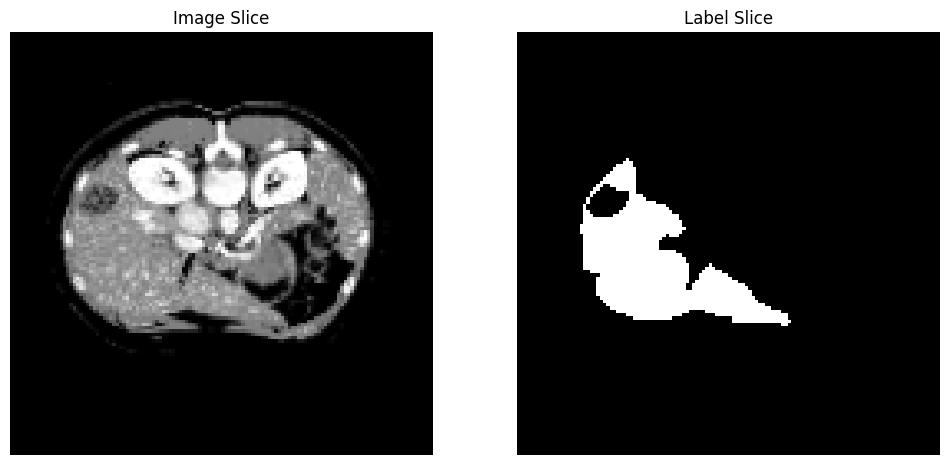

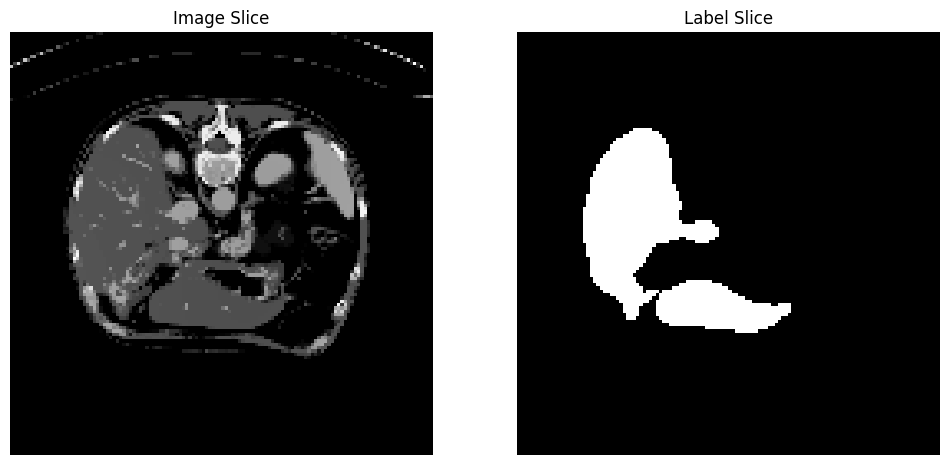

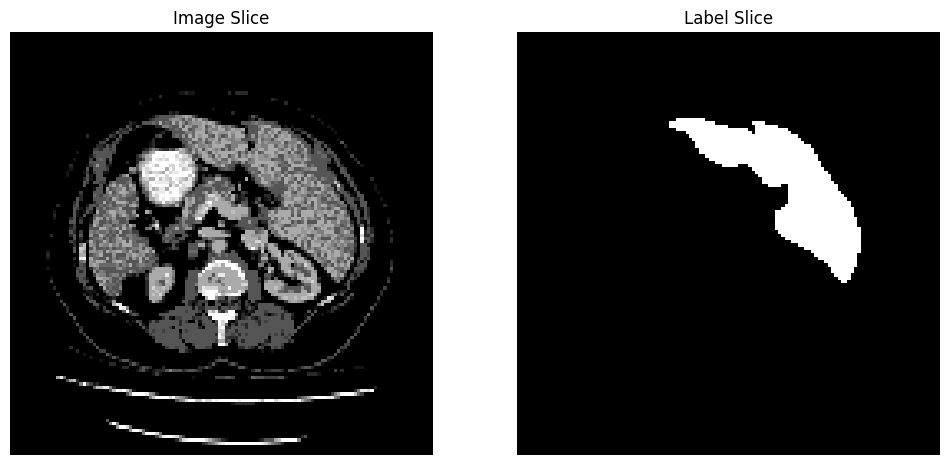

In [10]:
i = 0
for batch in train_loader:
    i+=1
    image, label = batch["image"], batch["label"]
    plot_sample(image, label)

    if i == 3:
      break

## Training

In [11]:
model = ModelFactory.get_model("unet3d_resnextcot",in_channels=1, n_classes=1, n_channels=16).to(device)

In [12]:
criterion = DiceLossWSigmoid().to(device)

dice_acc = DiceMetric(include_background=False, reduction='mean_batch', get_not_nans=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=float(config["learning_rate"]), weight_decay=float(config["weight_decay"]))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=int(config["max_epochs"]), eta_min = float(config["eta_min"]))

In [13]:
LOGGER.info("[TRAINER] Start TRAIN process...")

(
    val_acc_max,
    best_epoch,
    dices_liver,
    loss_epochs,
    trains_epoch,
    ious_liver,
    precisions_liver,
    recalls_liver,
    time_tmp
) = trainer_stage1(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_func=criterion,
    acc_func=dice_acc,
    scheduler=scheduler,
    batch_size=config["batch_size"],
    max_epochs = config["max_epochs"],
    start_epoch = config["start_epoch"],
    val_every=config["val_every"],
    path_save_model=config["path_save_model_state"],
    logger=LOGGER,
    save_model=True,
    post_fix="liver"
)

[TRAINER] Start TRAIN process...
INFO:kltn.utils.logger:[TRAINER] Start TRAIN process...

==============================Training epoch 1==============================
INFO:kltn.utils.logger:
==============================Training epoch 1==============================


Epoch 1/100 1/105 loss: 0.8930 time 14.16s
Epoch 1/100 2/105 loss: 0.8773 time 0.62s
Epoch 1/100 3/105 loss: 0.8653 time 0.63s
Epoch 1/100 4/105 loss: 0.8569 time 1.51s
Epoch 1/100 5/105 loss: 0.8502 time 6.26s
Epoch 1/100 6/105 loss: 0.8456 time 4.67s
Epoch 1/100 7/105 loss: 0.8418 time 9.79s
Epoch 1/100 8/105 loss: 0.8363 time 8.78s
Epoch 1/100 9/105 loss: 0.8328 time 1.26s
Epoch 1/100 10/105 loss: 0.8303 time 7.61s
Epoch 1/100 11/105 loss: 0.8283 time 2.48s
Epoch 1/100 12/105 loss: 0.8259 time 10.17s
Epoch 1/100 13/105 loss: 0.8249 time 2.13s
Epoch 1/100 14/105 loss: 0.8230 time 9.76s
Epoch 1/100 15/105 loss: 0.8212 time 5.21s
Epoch 1/100 16/105 loss: 0.8192 time 4.63s
Epoch 1/100 17/105 loss: 0.8185 time 1.55s
Epoch 1/100 18/105 loss: 0.8168 time 2.58s
Epoch 1/100 19/105 loss: 0.8151 time 0.88s
Epoch 1/100 20/105 loss: 0.8132 time 13.15s
Epoch 1/100 21/105 loss: 0.8114 time 10.80s
Epoch 1/100 22/105 loss: 0.8104 time 1.63s
Epoch 1/100 23/105 loss: 0.8088 time 8.33s
Epoch 1/100 24/1

Final training epochs: 1/100 ---[loss: 0.4462] ---[time 584.70s]
INFO:kltn.utils.logger:Final training epochs: 1/100 ---[loss: 0.4462] ---[time 584.70s]

********************Epoch 1 Validation********************
INFO:kltn.utils.logger:
********************Epoch 1 Validation********************


Epoch 1/100 105/105 loss: 0.4462 time 1.57s


Val 1/100 1/26, Dice_Liver: 0.796726, time 9.46s
INFO:kltn.utils.logger:Val 1/100 1/26, Dice_Liver: 0.796726, time 9.46s
Val 1/100 2/26, Dice_Liver: 0.830953, time 0.83s
INFO:kltn.utils.logger:Val 1/100 2/26, Dice_Liver: 0.830953, time 0.83s
Val 1/100 3/26, Dice_Liver: 0.847517, time 6.28s
INFO:kltn.utils.logger:Val 1/100 3/26, Dice_Liver: 0.847517, time 6.28s
Val 1/100 4/26, Dice_Liver: 0.850449, time 5.53s
INFO:kltn.utils.logger:Val 1/100 4/26, Dice_Liver: 0.850449, time 5.53s
Val 1/100 5/26, Dice_Liver: 0.822944, time 10.58s
INFO:kltn.utils.logger:Val 1/100 5/26, Dice_Liver: 0.822944, time 10.58s
Val 1/100 6/26, Dice_Liver: 0.771274, time 6.39s
INFO:kltn.utils.logger:Val 1/100 6/26, Dice_Liver: 0.771274, time 6.39s
Val 1/100 7/26, Dice_Liver: 0.868075, time 12.85s
INFO:kltn.utils.logger:Val 1/100 7/26, Dice_Liver: 0.868075, time 12.85s
Val 1/100 8/26, Dice_Liver: 0.697993, time 2.02s
INFO:kltn.utils.logger:Val 1/100 8/26, Dice_Liver: 0.697993, time 2.02s
Val 1/100 9/26, Dice_Liver: 

New best (0.000000 --> 0.737125). At epoch 1


Epoch 1/100 ---[loss: 0.4462] ---[val_dice: 0.737125] ---[time 142.71s]
INFO:kltn.utils.logger:Epoch 1/100 ---[loss: 0.4462] ---[val_dice: 0.737125] ---[time 142.71s]

==============================Training epoch 2==============================
INFO:kltn.utils.logger:
==============================Training epoch 2==============================


Epoch 2/100 1/105 loss: 0.1004 time 11.43s
Epoch 2/100 2/105 loss: 0.1143 time 4.76s
Epoch 2/100 3/105 loss: 0.1353 time 10.14s
Epoch 2/100 4/105 loss: 0.1466 time 8.17s
Epoch 2/100 5/105 loss: 0.1396 time 1.77s
Epoch 2/100 6/105 loss: 0.1866 time 9.88s
Epoch 2/100 7/105 loss: 0.2641 time 1.03s
Epoch 2/100 8/105 loss: 0.2526 time 5.98s
Epoch 2/100 9/105 loss: 0.2440 time 9.76s
Epoch 2/100 10/105 loss: 0.2374 time 2.59s
Epoch 2/100 11/105 loss: 0.2278 time 2.07s
Epoch 2/100 12/105 loss: 0.2252 time 9.20s
Epoch 2/100 13/105 loss: 0.2176 time 3.51s
Epoch 2/100 14/105 loss: 0.2206 time 4.44s
Epoch 2/100 15/105 loss: 0.2231 time 9.23s
Epoch 2/100 16/105 loss: 0.2143 time 2.44s
Epoch 2/100 17/105 loss: 0.2092 time 2.56s
Epoch 2/100 18/105 loss: 0.2035 time 10.94s
Epoch 2/100 19/105 loss: 0.2032 time 9.14s
Epoch 2/100 20/105 loss: 0.1994 time 6.31s
Epoch 2/100 21/105 loss: 0.1992 time 7.66s
Epoch 2/100 22/105 loss: 0.1955 time 9.38s
Epoch 2/100 23/105 loss: 0.1916 time 4.42s
Epoch 2/100 24/10

Final training epochs: 2/100 ---[loss: 0.1656] ---[time 584.82s]
INFO:kltn.utils.logger:Final training epochs: 2/100 ---[loss: 0.1656] ---[time 584.82s]

********************Epoch 2 Validation********************
INFO:kltn.utils.logger:
********************Epoch 2 Validation********************


Epoch 2/100 105/105 loss: 0.1656 time 4.70s


Val 2/100 1/26, Dice_Liver: 0.856718, time 8.37s
INFO:kltn.utils.logger:Val 2/100 1/26, Dice_Liver: 0.856718, time 8.37s
Val 2/100 2/26, Dice_Liver: 0.851251, time 1.83s
INFO:kltn.utils.logger:Val 2/100 2/26, Dice_Liver: 0.851251, time 1.83s
Val 2/100 3/26, Dice_Liver: 0.856298, time 5.80s
INFO:kltn.utils.logger:Val 2/100 3/26, Dice_Liver: 0.856298, time 5.80s
Val 2/100 4/26, Dice_Liver: 0.880061, time 5.45s
INFO:kltn.utils.logger:Val 2/100 4/26, Dice_Liver: 0.880061, time 5.45s
Val 2/100 5/26, Dice_Liver: 0.887857, time 10.76s
INFO:kltn.utils.logger:Val 2/100 5/26, Dice_Liver: 0.887857, time 10.76s
Val 2/100 6/26, Dice_Liver: 0.760571, time 6.38s
INFO:kltn.utils.logger:Val 2/100 6/26, Dice_Liver: 0.760571, time 6.38s
Val 2/100 7/26, Dice_Liver: 0.856809, time 12.87s
INFO:kltn.utils.logger:Val 2/100 7/26, Dice_Liver: 0.856809, time 12.87s
Val 2/100 8/26, Dice_Liver: 0.754430, time 2.05s
INFO:kltn.utils.logger:Val 2/100 8/26, Dice_Liver: 0.754430, time 2.05s
Val 2/100 9/26, Dice_Liver: 

New best (0.737125 --> 0.787804). At epoch 2
Epoch 3/100 1/105 loss: 0.1918 time 8.90s
Epoch 3/100 2/105 loss: 0.1761 time 10.05s
Epoch 3/100 3/105 loss: 0.1448 time 2.03s
Epoch 3/100 4/105 loss: 0.1402 time 2.11s
Epoch 3/100 5/105 loss: 0.1477 time 5.98s
Epoch 3/100 6/105 loss: 0.1561 time 11.17s
Epoch 3/100 7/105 loss: 0.2208 time 6.21s
Epoch 3/100 8/105 loss: 0.2227 time 1.69s
Epoch 3/100 9/105 loss: 0.2355 time 1.09s
Epoch 3/100 10/105 loss: 0.2307 time 6.67s
Epoch 3/100 11/105 loss: 0.2249 time 2.03s
Epoch 3/100 12/105 loss: 0.2160 time 6.42s
Epoch 3/100 13/105 loss: 0.2086 time 9.60s
Epoch 3/100 14/105 loss: 0.2006 time 10.43s
Epoch 3/100 15/105 loss: 0.1965 time 12.44s
Epoch 3/100 16/105 loss: 0.1952 time 3.78s
Epoch 3/100 17/105 loss: 0.1897 time 0.81s
Epoch 3/100 18/105 loss: 0.1851 time 4.58s
Epoch 3/100 19/105 loss: 0.1832 time 6.49s
Epoch 3/100 20/105 loss: 0.1812 time 2.12s
Epoch 3/100 21/105 loss: 0.1775 time 3.25s
Epoch 3/100 22/105 loss: 0.1776 time 8.77s
Epoch 3/100 23

Final training epochs: 3/100 ---[loss: 0.1361] ---[time 583.68s]
INFO:kltn.utils.logger:Final training epochs: 3/100 ---[loss: 0.1361] ---[time 583.68s]

********************Epoch 3 Validation********************
INFO:kltn.utils.logger:
********************Epoch 3 Validation********************


Epoch 3/100 105/105 loss: 0.1361 time 11.35s


Val 3/100 1/26, Dice_Liver: 0.888536, time 6.64s
INFO:kltn.utils.logger:Val 3/100 1/26, Dice_Liver: 0.888536, time 6.64s
Val 3/100 2/26, Dice_Liver: 0.868700, time 2.21s
INFO:kltn.utils.logger:Val 3/100 2/26, Dice_Liver: 0.868700, time 2.21s
Val 3/100 3/26, Dice_Liver: 0.875075, time 5.37s
INFO:kltn.utils.logger:Val 3/100 3/26, Dice_Liver: 0.875075, time 5.37s
Val 3/100 4/26, Dice_Liver: 0.882625, time 4.71s
INFO:kltn.utils.logger:Val 3/100 4/26, Dice_Liver: 0.882625, time 4.71s
Val 3/100 5/26, Dice_Liver: 0.896351, time 10.49s
INFO:kltn.utils.logger:Val 3/100 5/26, Dice_Liver: 0.896351, time 10.49s
Val 3/100 6/26, Dice_Liver: 0.874413, time 6.65s
INFO:kltn.utils.logger:Val 3/100 6/26, Dice_Liver: 0.874413, time 6.65s
Val 3/100 7/26, Dice_Liver: 0.853039, time 12.66s
INFO:kltn.utils.logger:Val 3/100 7/26, Dice_Liver: 0.853039, time 12.66s
Val 3/100 8/26, Dice_Liver: 0.845240, time 2.02s
INFO:kltn.utils.logger:Val 3/100 8/26, Dice_Liver: 0.845240, time 2.02s
Val 3/100 9/26, Dice_Liver: 

New best (0.787804 --> 0.863943). At epoch 3
Epoch 4/100 1/105 loss: 0.0720 time 1.76s
Epoch 4/100 2/105 loss: 0.0707 time 2.24s
Epoch 4/100 3/105 loss: 0.0862 time 8.41s
Epoch 4/100 4/105 loss: 0.0920 time 7.33s
Epoch 4/100 5/105 loss: 0.0930 time 12.57s
Epoch 4/100 6/105 loss: 0.0938 time 7.92s
Epoch 4/100 7/105 loss: 0.0958 time 3.17s
Epoch 4/100 8/105 loss: 0.0995 time 1.50s
Epoch 4/100 9/105 loss: 0.0999 time 1.31s
Epoch 4/100 10/105 loss: 0.1033 time 10.61s
Epoch 4/100 11/105 loss: 0.1012 time 1.82s
Epoch 4/100 12/105 loss: 0.1007 time 10.74s
Epoch 4/100 13/105 loss: 0.0994 time 1.78s
Epoch 4/100 14/105 loss: 0.0989 time 8.84s
Epoch 4/100 15/105 loss: 0.0974 time 4.87s
Epoch 4/100 16/105 loss: 0.0988 time 1.62s
Epoch 4/100 17/105 loss: 0.0969 time 12.74s
Epoch 4/100 18/105 loss: 0.0962 time 8.48s
Epoch 4/100 19/105 loss: 0.0953 time 2.11s
Epoch 4/100 20/105 loss: 0.0950 time 5.42s
Epoch 4/100 21/105 loss: 0.0941 time 2.01s
Epoch 4/100 22/105 loss: 0.0934 time 7.30s
Epoch 4/100 23

Final training epochs: 4/100 ---[loss: 0.1015] ---[time 579.77s]
INFO:kltn.utils.logger:Final training epochs: 4/100 ---[loss: 0.1015] ---[time 579.77s]

********************Epoch 4 Validation********************
INFO:kltn.utils.logger:
********************Epoch 4 Validation********************


Epoch 4/100 105/105 loss: 0.1015 time 7.51s


Val 4/100 1/26, Dice_Liver: 0.920571, time 6.96s
INFO:kltn.utils.logger:Val 4/100 1/26, Dice_Liver: 0.920571, time 6.96s
Val 4/100 2/26, Dice_Liver: 0.909883, time 1.86s
INFO:kltn.utils.logger:Val 4/100 2/26, Dice_Liver: 0.909883, time 1.86s
Val 4/100 3/26, Dice_Liver: 0.887166, time 6.25s
INFO:kltn.utils.logger:Val 4/100 3/26, Dice_Liver: 0.887166, time 6.25s
Val 4/100 4/26, Dice_Liver: 0.882403, time 4.92s
INFO:kltn.utils.logger:Val 4/100 4/26, Dice_Liver: 0.882403, time 4.92s
Val 4/100 5/26, Dice_Liver: 0.884271, time 11.36s
INFO:kltn.utils.logger:Val 4/100 5/26, Dice_Liver: 0.884271, time 11.36s
Val 4/100 6/26, Dice_Liver: 0.835784, time 6.09s
INFO:kltn.utils.logger:Val 4/100 6/26, Dice_Liver: 0.835784, time 6.09s
Val 4/100 7/26, Dice_Liver: 0.846437, time 11.91s
INFO:kltn.utils.logger:Val 4/100 7/26, Dice_Liver: 0.846437, time 11.91s
Val 4/100 8/26, Dice_Liver: 0.881291, time 2.09s
INFO:kltn.utils.logger:Val 4/100 8/26, Dice_Liver: 0.881291, time 2.09s
Val 4/100 9/26, Dice_Liver: 

Epoch 5/100 1/105 loss: 0.1156 time 5.76s
Epoch 5/100 2/105 loss: 0.1075 time 8.19s
Epoch 5/100 3/105 loss: 0.0995 time 9.87s
Epoch 5/100 4/105 loss: 0.1029 time 9.68s
Epoch 5/100 5/105 loss: 0.0974 time 9.30s
Epoch 5/100 6/105 loss: 0.1107 time 6.56s
Epoch 5/100 7/105 loss: 0.1092 time 5.39s
Epoch 5/100 8/105 loss: 0.1094 time 8.67s
Epoch 5/100 9/105 loss: 0.1049 time 2.04s
Epoch 5/100 10/105 loss: 0.1026 time 7.07s
Epoch 5/100 11/105 loss: 0.1036 time 2.71s
Epoch 5/100 12/105 loss: 0.1130 time 11.40s
Epoch 5/100 13/105 loss: 0.1156 time 1.35s
Epoch 5/100 14/105 loss: 0.1132 time 1.21s
Epoch 5/100 15/105 loss: 0.1117 time 8.18s
Epoch 5/100 16/105 loss: 0.1137 time 6.04s
Epoch 5/100 17/105 loss: 0.1102 time 2.43s
Epoch 5/100 18/105 loss: 0.1076 time 1.38s
Epoch 5/100 19/105 loss: 0.1074 time 10.64s
Epoch 5/100 20/105 loss: 0.1062 time 3.81s
Epoch 5/100 21/105 loss: 0.1037 time 1.06s
Epoch 5/100 22/105 loss: 0.1018 time 1.27s
Epoch 5/100 23/105 loss: 0.1012 time 12.74s
Epoch 5/100 24/10

Final training epochs: 5/100 ---[loss: 0.0906] ---[time 578.48s]
INFO:kltn.utils.logger:Final training epochs: 5/100 ---[loss: 0.0906] ---[time 578.48s]

********************Epoch 5 Validation********************
INFO:kltn.utils.logger:
********************Epoch 5 Validation********************


Epoch 5/100 105/105 loss: 0.0906 time 1.70s


Val 5/100 1/26, Dice_Liver: 0.904618, time 9.23s
INFO:kltn.utils.logger:Val 5/100 1/26, Dice_Liver: 0.904618, time 9.23s
Val 5/100 2/26, Dice_Liver: 0.877079, time 1.93s
INFO:kltn.utils.logger:Val 5/100 2/26, Dice_Liver: 0.877079, time 1.93s
Val 5/100 3/26, Dice_Liver: 0.846907, time 6.02s
INFO:kltn.utils.logger:Val 5/100 3/26, Dice_Liver: 0.846907, time 6.02s
Val 5/100 4/26, Dice_Liver: 0.886058, time 5.37s
INFO:kltn.utils.logger:Val 5/100 4/26, Dice_Liver: 0.886058, time 5.37s
Val 5/100 5/26, Dice_Liver: 0.805982, time 10.78s
INFO:kltn.utils.logger:Val 5/100 5/26, Dice_Liver: 0.805982, time 10.78s
Val 5/100 6/26, Dice_Liver: 0.751718, time 6.02s
INFO:kltn.utils.logger:Val 5/100 6/26, Dice_Liver: 0.751718, time 6.02s
Val 5/100 7/26, Dice_Liver: 0.842831, time 12.89s
INFO:kltn.utils.logger:Val 5/100 7/26, Dice_Liver: 0.842831, time 12.89s
Val 5/100 8/26, Dice_Liver: 0.821380, time 2.06s
INFO:kltn.utils.logger:Val 5/100 8/26, Dice_Liver: 0.821380, time 2.06s
Val 5/100 9/26, Dice_Liver: 

Epoch 6/100 1/105 loss: 0.0635 time 1.76s
Epoch 6/100 2/105 loss: 0.1113 time 2.69s
Epoch 6/100 3/105 loss: 0.2101 time 6.98s
Epoch 6/100 4/105 loss: 0.1905 time 2.13s
Epoch 6/100 5/105 loss: 0.1767 time 2.27s
Epoch 6/100 6/105 loss: 0.1672 time 1.65s
Epoch 6/100 7/105 loss: 0.1543 time 2.84s
Epoch 6/100 8/105 loss: 0.1595 time 11.87s
Epoch 6/100 9/105 loss: 0.1484 time 2.06s
Epoch 6/100 10/105 loss: 0.1412 time 2.21s
Epoch 6/100 11/105 loss: 0.1435 time 3.34s
Epoch 6/100 12/105 loss: 0.1403 time 2.74s
Epoch 6/100 13/105 loss: 0.1345 time 1.64s
Epoch 6/100 14/105 loss: 0.1356 time 8.62s
Epoch 6/100 15/105 loss: 0.1323 time 0.86s
Epoch 6/100 16/105 loss: 0.1349 time 1.63s
Epoch 6/100 17/105 loss: 0.1310 time 9.51s
Epoch 6/100 18/105 loss: 0.1317 time 4.51s
Epoch 6/100 19/105 loss: 0.1348 time 3.86s
Epoch 6/100 20/105 loss: 0.1316 time 3.58s
Epoch 6/100 21/105 loss: 0.1288 time 1.96s
Epoch 6/100 22/105 loss: 0.1267 time 1.71s
Epoch 6/100 23/105 loss: 0.1242 time 1.35s
Epoch 6/100 24/105 

Final training epochs: 6/100 ---[loss: 0.1050] ---[time 578.26s]
INFO:kltn.utils.logger:Final training epochs: 6/100 ---[loss: 0.1050] ---[time 578.26s]

********************Epoch 6 Validation********************
INFO:kltn.utils.logger:
********************Epoch 6 Validation********************


Epoch 6/100 105/105 loss: 0.1050 time 7.67s


Val 6/100 1/26, Dice_Liver: 0.903792, time 7.15s
INFO:kltn.utils.logger:Val 6/100 1/26, Dice_Liver: 0.903792, time 7.15s
Val 6/100 2/26, Dice_Liver: 0.896913, time 2.19s
INFO:kltn.utils.logger:Val 6/100 2/26, Dice_Liver: 0.896913, time 2.19s
Val 6/100 3/26, Dice_Liver: 0.878403, time 5.83s
INFO:kltn.utils.logger:Val 6/100 3/26, Dice_Liver: 0.878403, time 5.83s
Val 6/100 4/26, Dice_Liver: 0.912782, time 4.84s
INFO:kltn.utils.logger:Val 6/100 4/26, Dice_Liver: 0.912782, time 4.84s
Val 6/100 5/26, Dice_Liver: 0.881681, time 10.76s
INFO:kltn.utils.logger:Val 6/100 5/26, Dice_Liver: 0.881681, time 10.76s
Val 6/100 6/26, Dice_Liver: 0.895412, time 6.78s
INFO:kltn.utils.logger:Val 6/100 6/26, Dice_Liver: 0.895412, time 6.78s
Val 6/100 7/26, Dice_Liver: 0.920258, time 12.77s
INFO:kltn.utils.logger:Val 6/100 7/26, Dice_Liver: 0.920258, time 12.77s
Val 6/100 8/26, Dice_Liver: 0.892715, time 2.03s
INFO:kltn.utils.logger:Val 6/100 8/26, Dice_Liver: 0.892715, time 2.03s
Val 6/100 9/26, Dice_Liver: 

New best (0.863943 --> 0.892032). At epoch 6
Epoch 7/100 1/105 loss: 0.0630 time 6.81s
Epoch 7/100 2/105 loss: 0.0861 time 1.52s
Epoch 7/100 3/105 loss: 0.0727 time 5.58s
Epoch 7/100 4/105 loss: 0.0712 time 7.10s
Epoch 7/100 5/105 loss: 0.0689 time 9.01s
Epoch 7/100 6/105 loss: 0.0679 time 1.99s
Epoch 7/100 7/105 loss: 0.0697 time 2.13s
Epoch 7/100 8/105 loss: 0.0683 time 2.90s
Epoch 7/100 9/105 loss: 0.0687 time 3.41s
Epoch 7/100 10/105 loss: 0.0679 time 1.41s
Epoch 7/100 11/105 loss: 0.0684 time 2.87s
Epoch 7/100 12/105 loss: 0.0687 time 1.46s
Epoch 7/100 13/105 loss: 0.0686 time 10.51s
Epoch 7/100 14/105 loss: 0.0706 time 1.67s
Epoch 7/100 15/105 loss: 0.0697 time 8.79s
Epoch 7/100 16/105 loss: 0.0707 time 4.10s
Epoch 7/100 17/105 loss: 0.0709 time 4.92s
Epoch 7/100 18/105 loss: 0.0717 time 5.25s
Epoch 7/100 19/105 loss: 0.0721 time 11.07s
Epoch 7/100 20/105 loss: 0.0717 time 8.42s
Epoch 7/100 21/105 loss: 0.0727 time 7.69s
Epoch 7/100 22/105 loss: 0.0730 time 8.42s
Epoch 7/100 23/1

Final training epochs: 7/100 ---[loss: 0.0815] ---[time 572.33s]
INFO:kltn.utils.logger:Final training epochs: 7/100 ---[loss: 0.0815] ---[time 572.33s]

********************Epoch 7 Validation********************
INFO:kltn.utils.logger:
********************Epoch 7 Validation********************


Epoch 7/100 105/105 loss: 0.0815 time 5.96s


Val 7/100 1/26, Dice_Liver: 0.912206, time 8.36s
INFO:kltn.utils.logger:Val 7/100 1/26, Dice_Liver: 0.912206, time 8.36s
Val 7/100 2/26, Dice_Liver: 0.916239, time 1.81s
INFO:kltn.utils.logger:Val 7/100 2/26, Dice_Liver: 0.916239, time 1.81s
Val 7/100 3/26, Dice_Liver: 0.903191, time 5.75s
INFO:kltn.utils.logger:Val 7/100 3/26, Dice_Liver: 0.903191, time 5.75s
Val 7/100 4/26, Dice_Liver: 0.898393, time 5.48s
INFO:kltn.utils.logger:Val 7/100 4/26, Dice_Liver: 0.898393, time 5.48s
Val 7/100 5/26, Dice_Liver: 0.886840, time 10.55s
INFO:kltn.utils.logger:Val 7/100 5/26, Dice_Liver: 0.886840, time 10.55s
Val 7/100 6/26, Dice_Liver: 0.893374, time 6.47s
INFO:kltn.utils.logger:Val 7/100 6/26, Dice_Liver: 0.893374, time 6.47s
Val 7/100 7/26, Dice_Liver: 0.906350, time 12.65s
INFO:kltn.utils.logger:Val 7/100 7/26, Dice_Liver: 0.906350, time 12.65s
Val 7/100 8/26, Dice_Liver: 0.911281, time 2.06s
INFO:kltn.utils.logger:Val 7/100 8/26, Dice_Liver: 0.911281, time 2.06s
Val 7/100 9/26, Dice_Liver: 

New best (0.892032 --> 0.900640). At epoch 7
Epoch 8/100 1/105 loss: 0.0691 time 3.10s
Epoch 8/100 2/105 loss: 0.0654 time 7.10s
Epoch 8/100 3/105 loss: 0.0624 time 2.12s
Epoch 8/100 4/105 loss: 0.0587 time 2.19s
Epoch 8/100 5/105 loss: 0.0626 time 4.61s
Epoch 8/100 6/105 loss: 0.0692 time 2.67s
Epoch 8/100 7/105 loss: 0.0715 time 2.72s
Epoch 8/100 8/105 loss: 0.0682 time 10.42s
Epoch 8/100 9/105 loss: 0.0711 time 9.14s
Epoch 8/100 10/105 loss: 0.0740 time 7.15s
Epoch 8/100 11/105 loss: 0.0727 time 4.36s
Epoch 8/100 12/105 loss: 0.0731 time 6.33s
Epoch 8/100 13/105 loss: 0.0719 time 7.36s
Epoch 8/100 14/105 loss: 0.0741 time 3.42s
Epoch 8/100 15/105 loss: 0.0738 time 10.74s
Epoch 8/100 16/105 loss: 0.0729 time 2.01s
Epoch 8/100 17/105 loss: 0.0725 time 8.30s
Epoch 8/100 18/105 loss: 0.0720 time 11.02s
Epoch 8/100 19/105 loss: 0.0713 time 6.03s
Epoch 8/100 20/105 loss: 0.0710 time 1.25s
Epoch 8/100 21/105 loss: 0.0697 time 2.05s
Epoch 8/100 22/105 loss: 0.0721 time 2.43s
Epoch 8/100 23/

Final training epochs: 8/100 ---[loss: 0.0751] ---[time 580.81s]
INFO:kltn.utils.logger:Final training epochs: 8/100 ---[loss: 0.0751] ---[time 580.81s]

********************Epoch 8 Validation********************
INFO:kltn.utils.logger:
********************Epoch 8 Validation********************


Epoch 8/100 105/105 loss: 0.0751 time 1.06s


Val 8/100 1/26, Dice_Liver: 0.929159, time 7.16s
INFO:kltn.utils.logger:Val 8/100 1/26, Dice_Liver: 0.929159, time 7.16s
Val 8/100 2/26, Dice_Liver: 0.932003, time 2.24s
INFO:kltn.utils.logger:Val 8/100 2/26, Dice_Liver: 0.932003, time 2.24s
Val 8/100 3/26, Dice_Liver: 0.912730, time 5.78s
INFO:kltn.utils.logger:Val 8/100 3/26, Dice_Liver: 0.912730, time 5.78s
Val 8/100 4/26, Dice_Liver: 0.899165, time 4.88s
INFO:kltn.utils.logger:Val 8/100 4/26, Dice_Liver: 0.899165, time 4.88s
Val 8/100 5/26, Dice_Liver: 0.916737, time 10.61s
INFO:kltn.utils.logger:Val 8/100 5/26, Dice_Liver: 0.916737, time 10.61s
Val 8/100 6/26, Dice_Liver: 0.907555, time 6.55s
INFO:kltn.utils.logger:Val 8/100 6/26, Dice_Liver: 0.907555, time 6.55s
Val 8/100 7/26, Dice_Liver: 0.907001, time 12.55s
INFO:kltn.utils.logger:Val 8/100 7/26, Dice_Liver: 0.907001, time 12.55s
Val 8/100 8/26, Dice_Liver: 0.918191, time 2.04s
INFO:kltn.utils.logger:Val 8/100 8/26, Dice_Liver: 0.918191, time 2.04s
Val 8/100 9/26, Dice_Liver: 

New best (0.900640 --> 0.905218). At epoch 8
Epoch 9/100 1/105 loss: 0.0610 time 12.28s
Epoch 9/100 2/105 loss: 0.0592 time 2.14s
Epoch 9/100 3/105 loss: 0.0601 time 6.06s
Epoch 9/100 4/105 loss: 0.0639 time 9.04s
Epoch 9/100 5/105 loss: 0.0665 time 1.23s
Epoch 9/100 6/105 loss: 0.0645 time 5.38s
Epoch 9/100 7/105 loss: 0.0639 time 4.26s
Epoch 9/100 8/105 loss: 0.0632 time 1.65s
Epoch 9/100 9/105 loss: 0.0631 time 1.58s
Epoch 9/100 10/105 loss: 0.0656 time 2.35s
Epoch 9/100 11/105 loss: 0.0666 time 12.23s
Epoch 9/100 12/105 loss: 0.0710 time 3.46s
Epoch 9/100 13/105 loss: 0.0775 time 11.80s
Epoch 9/100 14/105 loss: 0.0762 time 2.68s
Epoch 9/100 15/105 loss: 0.0826 time 3.94s
Epoch 9/100 16/105 loss: 0.0817 time 2.20s
Epoch 9/100 17/105 loss: 0.0807 time 1.96s
Epoch 9/100 18/105 loss: 0.0796 time 7.72s
Epoch 9/100 19/105 loss: 0.0788 time 11.60s
Epoch 9/100 20/105 loss: 0.0780 time 8.49s
Epoch 9/100 21/105 loss: 0.0774 time 1.03s
Epoch 9/100 22/105 loss: 0.0777 time 8.52s
Epoch 9/100 23

Final training epochs: 9/100 ---[loss: 0.0733] ---[time 579.37s]
INFO:kltn.utils.logger:Final training epochs: 9/100 ---[loss: 0.0733] ---[time 579.37s]

********************Epoch 9 Validation********************
INFO:kltn.utils.logger:
********************Epoch 9 Validation********************


Epoch 9/100 105/105 loss: 0.0733 time 11.42s


Val 9/100 1/26, Dice_Liver: 0.935406, time 6.87s
INFO:kltn.utils.logger:Val 9/100 1/26, Dice_Liver: 0.935406, time 6.87s
Val 9/100 2/26, Dice_Liver: 0.935786, time 1.82s
INFO:kltn.utils.logger:Val 9/100 2/26, Dice_Liver: 0.935786, time 1.82s
Val 9/100 3/26, Dice_Liver: 0.888408, time 5.72s
INFO:kltn.utils.logger:Val 9/100 3/26, Dice_Liver: 0.888408, time 5.72s
Val 9/100 4/26, Dice_Liver: 0.912490, time 4.57s
INFO:kltn.utils.logger:Val 9/100 4/26, Dice_Liver: 0.912490, time 4.57s
Val 9/100 5/26, Dice_Liver: 0.900666, time 10.87s
INFO:kltn.utils.logger:Val 9/100 5/26, Dice_Liver: 0.900666, time 10.87s
Val 9/100 6/26, Dice_Liver: 0.909495, time 6.06s
INFO:kltn.utils.logger:Val 9/100 6/26, Dice_Liver: 0.909495, time 6.06s
Val 9/100 7/26, Dice_Liver: 0.895009, time 11.84s
INFO:kltn.utils.logger:Val 9/100 7/26, Dice_Liver: 0.895009, time 11.84s
Val 9/100 8/26, Dice_Liver: 0.901511, time 2.02s
INFO:kltn.utils.logger:Val 9/100 8/26, Dice_Liver: 0.901511, time 2.02s
Val 9/100 9/26, Dice_Liver: 

Epoch 10/100 1/105 loss: 0.0694 time 5.63s
Epoch 10/100 2/105 loss: 0.0802 time 3.49s
Epoch 10/100 3/105 loss: 0.0723 time 2.67s
Epoch 10/100 4/105 loss: 0.0699 time 1.22s
Epoch 10/100 5/105 loss: 0.0699 time 10.40s
Epoch 10/100 6/105 loss: 0.0715 time 7.69s
Epoch 10/100 7/105 loss: 0.0746 time 8.79s
Epoch 10/100 8/105 loss: 0.0723 time 3.62s
Epoch 10/100 9/105 loss: 0.0718 time 12.39s
Epoch 10/100 10/105 loss: 0.0701 time 6.03s
Epoch 10/100 11/105 loss: 0.0681 time 11.32s
Epoch 10/100 12/105 loss: 0.0710 time 5.22s
Epoch 10/100 13/105 loss: 0.0719 time 4.28s
Epoch 10/100 14/105 loss: 0.0713 time 1.02s
Epoch 10/100 15/105 loss: 0.0706 time 7.89s
Epoch 10/100 16/105 loss: 0.0702 time 5.16s
Epoch 10/100 17/105 loss: 0.0699 time 10.98s
Epoch 10/100 18/105 loss: 0.0703 time 10.22s
Epoch 10/100 19/105 loss: 0.0724 time 11.29s
Epoch 10/100 20/105 loss: 0.0717 time 0.92s
Epoch 10/100 21/105 loss: 0.0715 time 1.70s
Epoch 10/100 22/105 loss: 0.0710 time 6.61s
Epoch 10/100 23/105 loss: 0.0705 ti

Final training epochs: 10/100 ---[loss: 0.0682] ---[time 578.05s]
INFO:kltn.utils.logger:Final training epochs: 10/100 ---[loss: 0.0682] ---[time 578.05s]

********************Epoch 10 Validation********************
INFO:kltn.utils.logger:
********************Epoch 10 Validation********************


Epoch 10/100 105/105 loss: 0.0682 time 3.77s


Val 10/100 1/26, Dice_Liver: 0.946438, time 8.16s
INFO:kltn.utils.logger:Val 10/100 1/26, Dice_Liver: 0.946438, time 8.16s
Val 10/100 2/26, Dice_Liver: 0.941487, time 2.04s
INFO:kltn.utils.logger:Val 10/100 2/26, Dice_Liver: 0.941487, time 2.04s
Val 10/100 3/26, Dice_Liver: 0.901175, time 5.78s
INFO:kltn.utils.logger:Val 10/100 3/26, Dice_Liver: 0.901175, time 5.78s
Val 10/100 4/26, Dice_Liver: 0.920059, time 5.30s
INFO:kltn.utils.logger:Val 10/100 4/26, Dice_Liver: 0.920059, time 5.30s
Val 10/100 5/26, Dice_Liver: 0.918094, time 10.40s
INFO:kltn.utils.logger:Val 10/100 5/26, Dice_Liver: 0.918094, time 10.40s
Val 10/100 6/26, Dice_Liver: 0.916566, time 6.53s
INFO:kltn.utils.logger:Val 10/100 6/26, Dice_Liver: 0.916566, time 6.53s
Val 10/100 7/26, Dice_Liver: 0.899268, time 12.88s
INFO:kltn.utils.logger:Val 10/100 7/26, Dice_Liver: 0.899268, time 12.88s
Val 10/100 8/26, Dice_Liver: 0.920379, time 2.03s
INFO:kltn.utils.logger:Val 10/100 8/26, Dice_Liver: 0.920379, time 2.03s
Val 10/100 9

New best (0.905218 --> 0.915337). At epoch 10



==============================Training epoch 11==============================
INFO:kltn.utils.logger:
==============================Training epoch 11==============================


Epoch 11/100 1/105 loss: 0.0506 time 2.68s
Epoch 11/100 2/105 loss: 0.0591 time 9.71s
Epoch 11/100 3/105 loss: 0.0580 time 9.05s
Epoch 11/100 4/105 loss: 0.0574 time 1.99s
Epoch 11/100 5/105 loss: 0.0580 time 3.87s
Epoch 11/100 6/105 loss: 0.0623 time 1.66s
Epoch 11/100 7/105 loss: 0.0640 time 9.87s
Epoch 11/100 8/105 loss: 0.0624 time 7.93s
Epoch 11/100 9/105 loss: 0.0626 time 8.00s
Epoch 11/100 10/105 loss: 0.0624 time 8.41s
Epoch 11/100 11/105 loss: 0.0616 time 5.46s
Epoch 11/100 12/105 loss: 0.0601 time 6.57s
Epoch 11/100 13/105 loss: 0.0613 time 1.91s
Epoch 11/100 14/105 loss: 0.0609 time 5.50s
Epoch 11/100 15/105 loss: 0.0663 time 4.47s
Epoch 11/100 16/105 loss: 0.0659 time 7.18s
Epoch 11/100 17/105 loss: 0.0647 time 1.65s
Epoch 11/100 18/105 loss: 0.0642 time 1.75s
Epoch 11/100 19/105 loss: 0.0633 time 1.75s
Epoch 11/100 20/105 loss: 0.0634 time 0.91s
Epoch 11/100 21/105 loss: 0.0630 time 0.62s
Epoch 11/100 22/105 loss: 0.0620 time 2.11s
Epoch 11/100 23/105 loss: 0.0627 time 3.3

Final training epochs: 11/100 ---[loss: 0.0614] ---[time 571.85s]
INFO:kltn.utils.logger:Final training epochs: 11/100 ---[loss: 0.0614] ---[time 571.85s]

********************Epoch 11 Validation********************
INFO:kltn.utils.logger:
********************Epoch 11 Validation********************


Epoch 11/100 105/105 loss: 0.0614 time 9.74s


Val 11/100 1/26, Dice_Liver: 0.934532, time 6.72s
INFO:kltn.utils.logger:Val 11/100 1/26, Dice_Liver: 0.934532, time 6.72s
Val 11/100 2/26, Dice_Liver: 0.942808, time 2.02s
INFO:kltn.utils.logger:Val 11/100 2/26, Dice_Liver: 0.942808, time 2.02s
Val 11/100 3/26, Dice_Liver: 0.915629, time 5.43s
INFO:kltn.utils.logger:Val 11/100 3/26, Dice_Liver: 0.915629, time 5.43s
Val 11/100 4/26, Dice_Liver: 0.925800, time 5.11s
INFO:kltn.utils.logger:Val 11/100 4/26, Dice_Liver: 0.925800, time 5.11s
Val 11/100 5/26, Dice_Liver: 0.928821, time 10.25s
INFO:kltn.utils.logger:Val 11/100 5/26, Dice_Liver: 0.928821, time 10.25s
Val 11/100 6/26, Dice_Liver: 0.922861, time 6.39s
INFO:kltn.utils.logger:Val 11/100 6/26, Dice_Liver: 0.922861, time 6.39s
Val 11/100 7/26, Dice_Liver: 0.916182, time 12.55s
INFO:kltn.utils.logger:Val 11/100 7/26, Dice_Liver: 0.916182, time 12.55s
Val 11/100 8/26, Dice_Liver: 0.915232, time 2.00s
INFO:kltn.utils.logger:Val 11/100 8/26, Dice_Liver: 0.915232, time 2.00s
Val 11/100 9

New best (0.915337 --> 0.916397). At epoch 11
Epoch 12/100 1/105 loss: 0.0497 time 10.68s
Epoch 12/100 2/105 loss: 0.0494 time 6.32s
Epoch 12/100 3/105 loss: 0.0523 time 1.05s
Epoch 12/100 4/105 loss: 0.0545 time 10.18s
Epoch 12/100 5/105 loss: 0.0509 time 1.59s
Epoch 12/100 6/105 loss: 0.0481 time 6.01s
Epoch 12/100 7/105 loss: 0.0489 time 3.85s
Epoch 12/100 8/105 loss: 0.0532 time 4.40s
Epoch 12/100 9/105 loss: 0.0522 time 8.78s
Epoch 12/100 10/105 loss: 0.0545 time 8.99s
Epoch 12/100 11/105 loss: 0.0541 time 1.16s
Epoch 12/100 12/105 loss: 0.0543 time 1.71s
Epoch 12/100 13/105 loss: 0.0529 time 3.03s
Epoch 12/100 14/105 loss: 0.0533 time 4.92s
Epoch 12/100 15/105 loss: 0.0543 time 10.44s
Epoch 12/100 16/105 loss: 0.0538 time 6.70s
Epoch 12/100 17/105 loss: 0.0546 time 7.35s
Epoch 12/100 18/105 loss: 0.0552 time 1.49s
Epoch 12/100 19/105 loss: 0.0556 time 10.88s
Epoch 12/100 20/105 loss: 0.0562 time 2.62s
Epoch 12/100 21/105 loss: 0.0559 time 5.74s
Epoch 12/100 22/105 loss: 0.0569 ti

Final training epochs: 12/100 ---[loss: 0.0604] ---[time 578.83s]
INFO:kltn.utils.logger:Final training epochs: 12/100 ---[loss: 0.0604] ---[time 578.83s]

********************Epoch 12 Validation********************
INFO:kltn.utils.logger:
********************Epoch 12 Validation********************


Epoch 12/100 105/105 loss: 0.0604 time 10.30s


Val 12/100 1/26, Dice_Liver: 0.900996, time 7.56s
INFO:kltn.utils.logger:Val 12/100 1/26, Dice_Liver: 0.900996, time 7.56s
Val 12/100 2/26, Dice_Liver: 0.923030, time 1.87s
INFO:kltn.utils.logger:Val 12/100 2/26, Dice_Liver: 0.923030, time 1.87s
Val 12/100 3/26, Dice_Liver: 0.928194, time 5.69s
INFO:kltn.utils.logger:Val 12/100 3/26, Dice_Liver: 0.928194, time 5.69s
Val 12/100 4/26, Dice_Liver: 0.912368, time 5.44s
INFO:kltn.utils.logger:Val 12/100 4/26, Dice_Liver: 0.912368, time 5.44s
Val 12/100 5/26, Dice_Liver: 0.931778, time 10.67s
INFO:kltn.utils.logger:Val 12/100 5/26, Dice_Liver: 0.931778, time 10.67s
Val 12/100 6/26, Dice_Liver: 0.929546, time 6.05s
INFO:kltn.utils.logger:Val 12/100 6/26, Dice_Liver: 0.929546, time 6.05s
Val 12/100 7/26, Dice_Liver: 0.917483, time 12.80s
INFO:kltn.utils.logger:Val 12/100 7/26, Dice_Liver: 0.917483, time 12.80s
Val 12/100 8/26, Dice_Liver: 0.911044, time 2.01s
INFO:kltn.utils.logger:Val 12/100 8/26, Dice_Liver: 0.911044, time 2.01s
Val 12/100 9

Epoch 13/100 1/105 loss: 0.0787 time 2.89s
Epoch 13/100 2/105 loss: 0.0617 time 1.99s
Epoch 13/100 3/105 loss: 0.0545 time 12.19s
Epoch 13/100 4/105 loss: 0.0567 time 9.73s
Epoch 13/100 5/105 loss: 0.0545 time 1.25s
Epoch 13/100 6/105 loss: 0.0522 time 8.21s
Epoch 13/100 7/105 loss: 0.0508 time 3.32s
Epoch 13/100 8/105 loss: 0.0518 time 5.04s
Epoch 13/100 9/105 loss: 0.0524 time 10.61s
Epoch 13/100 10/105 loss: 0.0548 time 10.82s
Epoch 13/100 11/105 loss: 0.0548 time 1.55s
Epoch 13/100 12/105 loss: 0.0557 time 10.70s
Epoch 13/100 13/105 loss: 0.0547 time 5.22s
Epoch 13/100 14/105 loss: 0.0567 time 2.45s
Epoch 13/100 15/105 loss: 0.0593 time 4.10s
Epoch 13/100 16/105 loss: 0.0594 time 1.70s
Epoch 13/100 17/105 loss: 0.0600 time 2.72s
Epoch 13/100 18/105 loss: 0.0604 time 2.60s
Epoch 13/100 19/105 loss: 0.0600 time 1.60s
Epoch 13/100 20/105 loss: 0.0604 time 2.47s
Epoch 13/100 21/105 loss: 0.0603 time 9.68s
Epoch 13/100 22/105 loss: 0.0600 time 6.65s
Epoch 13/100 23/105 loss: 0.0605 time

Final training epochs: 13/100 ---[loss: 0.0678] ---[time 570.50s]
INFO:kltn.utils.logger:Final training epochs: 13/100 ---[loss: 0.0678] ---[time 570.50s]

********************Epoch 13 Validation********************
INFO:kltn.utils.logger:
********************Epoch 13 Validation********************


Epoch 13/100 105/105 loss: 0.0678 time 6.82s


Val 13/100 1/26, Dice_Liver: 0.882516, time 7.92s
INFO:kltn.utils.logger:Val 13/100 1/26, Dice_Liver: 0.882516, time 7.92s
Val 13/100 2/26, Dice_Liver: 0.903692, time 1.84s
INFO:kltn.utils.logger:Val 13/100 2/26, Dice_Liver: 0.903692, time 1.84s
Val 13/100 3/26, Dice_Liver: 0.905687, time 5.79s
INFO:kltn.utils.logger:Val 13/100 3/26, Dice_Liver: 0.905687, time 5.79s
Val 13/100 4/26, Dice_Liver: 0.898457, time 5.34s
INFO:kltn.utils.logger:Val 13/100 4/26, Dice_Liver: 0.898457, time 5.34s
Val 13/100 5/26, Dice_Liver: 0.922042, time 10.61s
INFO:kltn.utils.logger:Val 13/100 5/26, Dice_Liver: 0.922042, time 10.61s
Val 13/100 6/26, Dice_Liver: 0.905525, time 6.27s
INFO:kltn.utils.logger:Val 13/100 6/26, Dice_Liver: 0.905525, time 6.27s
Val 13/100 7/26, Dice_Liver: 0.908927, time 12.65s
INFO:kltn.utils.logger:Val 13/100 7/26, Dice_Liver: 0.908927, time 12.65s
Val 13/100 8/26, Dice_Liver: 0.863300, time 2.02s
INFO:kltn.utils.logger:Val 13/100 8/26, Dice_Liver: 0.863300, time 2.02s
Val 13/100 9

Epoch 14/100 1/105 loss: 0.0609 time 2.58s
Epoch 14/100 2/105 loss: 0.0589 time 2.01s
Epoch 14/100 3/105 loss: 0.0616 time 11.00s
Epoch 14/100 4/105 loss: 0.0612 time 1.11s
Epoch 14/100 5/105 loss: 0.0627 time 1.13s
Epoch 14/100 6/105 loss: 0.0624 time 4.70s
Epoch 14/100 7/105 loss: 0.0661 time 1.96s
Epoch 14/100 8/105 loss: 0.0713 time 4.31s
Epoch 14/100 9/105 loss: 0.0692 time 5.77s
Epoch 14/100 10/105 loss: 0.0673 time 5.28s
Epoch 14/100 11/105 loss: 0.0683 time 10.90s
Epoch 14/100 12/105 loss: 0.0692 time 8.34s
Epoch 14/100 13/105 loss: 0.0690 time 1.24s
Epoch 14/100 14/105 loss: 0.0686 time 2.27s
Epoch 14/100 15/105 loss: 0.0707 time 3.22s
Epoch 14/100 16/105 loss: 0.0707 time 1.43s
Epoch 14/100 17/105 loss: 0.0762 time 3.88s
Epoch 14/100 18/105 loss: 0.0756 time 9.24s
Epoch 14/100 19/105 loss: 0.0752 time 2.13s
Epoch 14/100 20/105 loss: 0.0758 time 8.97s
Epoch 14/100 21/105 loss: 0.0758 time 8.58s
Epoch 14/100 22/105 loss: 0.0755 time 2.81s
Epoch 14/100 23/105 loss: 0.0749 time 3

Final training epochs: 14/100 ---[loss: 0.0685] ---[time 575.49s]
INFO:kltn.utils.logger:Final training epochs: 14/100 ---[loss: 0.0685] ---[time 575.49s]

********************Epoch 14 Validation********************
INFO:kltn.utils.logger:
********************Epoch 14 Validation********************


Epoch 14/100 105/105 loss: 0.0685 time 8.06s


Val 14/100 1/26, Dice_Liver: 0.916297, time 7.53s
INFO:kltn.utils.logger:Val 14/100 1/26, Dice_Liver: 0.916297, time 7.53s
Val 14/100 2/26, Dice_Liver: 0.938729, time 1.80s
INFO:kltn.utils.logger:Val 14/100 2/26, Dice_Liver: 0.938729, time 1.80s
Val 14/100 3/26, Dice_Liver: 0.923488, time 5.65s
INFO:kltn.utils.logger:Val 14/100 3/26, Dice_Liver: 0.923488, time 5.65s
Val 14/100 4/26, Dice_Liver: 0.907653, time 5.14s
INFO:kltn.utils.logger:Val 14/100 4/26, Dice_Liver: 0.907653, time 5.14s
Val 14/100 5/26, Dice_Liver: 0.918613, time 11.09s
INFO:kltn.utils.logger:Val 14/100 5/26, Dice_Liver: 0.918613, time 11.09s
Val 14/100 6/26, Dice_Liver: 0.911800, time 6.05s
INFO:kltn.utils.logger:Val 14/100 6/26, Dice_Liver: 0.911800, time 6.05s
Val 14/100 7/26, Dice_Liver: 0.912195, time 12.39s
INFO:kltn.utils.logger:Val 14/100 7/26, Dice_Liver: 0.912195, time 12.39s
Val 14/100 8/26, Dice_Liver: 0.895022, time 2.03s
INFO:kltn.utils.logger:Val 14/100 8/26, Dice_Liver: 0.895022, time 2.03s
Val 14/100 9

Epoch 15/100 1/105 loss: 0.0393 time 2.91s
Epoch 15/100 2/105 loss: 0.0487 time 1.25s
Epoch 15/100 3/105 loss: 0.0569 time 1.69s
Epoch 15/100 4/105 loss: 0.0552 time 11.18s
Epoch 15/100 5/105 loss: 0.0536 time 0.96s
Epoch 15/100 6/105 loss: 0.0531 time 8.22s
Epoch 15/100 7/105 loss: 0.0537 time 10.42s
Epoch 15/100 8/105 loss: 0.0525 time 3.72s
Epoch 15/100 9/105 loss: 0.0523 time 5.64s
Epoch 15/100 10/105 loss: 0.0523 time 8.37s
Epoch 15/100 11/105 loss: 0.0524 time 8.27s
Epoch 15/100 12/105 loss: 0.0510 time 1.19s
Epoch 15/100 13/105 loss: 0.0531 time 10.42s
Epoch 15/100 14/105 loss: 0.0562 time 1.74s
Epoch 15/100 15/105 loss: 0.0551 time 5.51s
Epoch 15/100 16/105 loss: 0.0540 time 2.25s
Epoch 15/100 17/105 loss: 0.0532 time 7.15s
Epoch 15/100 18/105 loss: 0.0542 time 2.71s
Epoch 15/100 19/105 loss: 0.0550 time 7.29s
Epoch 15/100 20/105 loss: 0.0541 time 6.75s
Epoch 15/100 21/105 loss: 0.0534 time 2.92s
Epoch 15/100 22/105 loss: 0.0533 time 1.63s
Epoch 15/100 23/105 loss: 0.0532 time 

Final training epochs: 15/100 ---[loss: 0.0563] ---[time 577.73s]
INFO:kltn.utils.logger:Final training epochs: 15/100 ---[loss: 0.0563] ---[time 577.73s]

********************Epoch 15 Validation********************
INFO:kltn.utils.logger:
********************Epoch 15 Validation********************


Epoch 15/100 105/105 loss: 0.0563 time 1.57s


Val 15/100 1/26, Dice_Liver: 0.940778, time 7.29s
INFO:kltn.utils.logger:Val 15/100 1/26, Dice_Liver: 0.940778, time 7.29s
Val 15/100 2/26, Dice_Liver: 0.941297, time 1.90s
INFO:kltn.utils.logger:Val 15/100 2/26, Dice_Liver: 0.941297, time 1.90s
Val 15/100 3/26, Dice_Liver: 0.919314, time 6.04s
INFO:kltn.utils.logger:Val 15/100 3/26, Dice_Liver: 0.919314, time 6.04s
Val 15/100 4/26, Dice_Liver: 0.923604, time 4.82s
INFO:kltn.utils.logger:Val 15/100 4/26, Dice_Liver: 0.923604, time 4.82s
Val 15/100 5/26, Dice_Liver: 0.941660, time 10.98s
INFO:kltn.utils.logger:Val 15/100 5/26, Dice_Liver: 0.941660, time 10.98s
Val 15/100 6/26, Dice_Liver: 0.919372, time 6.46s
INFO:kltn.utils.logger:Val 15/100 6/26, Dice_Liver: 0.919372, time 6.46s
Val 15/100 7/26, Dice_Liver: 0.909669, time 12.83s
INFO:kltn.utils.logger:Val 15/100 7/26, Dice_Liver: 0.909669, time 12.83s
Val 15/100 8/26, Dice_Liver: 0.917173, time 2.05s
INFO:kltn.utils.logger:Val 15/100 8/26, Dice_Liver: 0.917173, time 2.05s
Val 15/100 9

Epoch 16/100 1/105 loss: 0.0731 time 7.78s
Epoch 16/100 2/105 loss: 0.1567 time 11.46s
Epoch 16/100 3/105 loss: 0.1253 time 9.59s
Epoch 16/100 4/105 loss: 0.1166 time 9.80s
Epoch 16/100 5/105 loss: 0.1092 time 7.05s
Epoch 16/100 6/105 loss: 0.1081 time 5.56s
Epoch 16/100 7/105 loss: 0.1020 time 2.25s
Epoch 16/100 8/105 loss: 0.0974 time 7.47s
Epoch 16/100 9/105 loss: 0.0925 time 1.50s
Epoch 16/100 10/105 loss: 0.0902 time 7.58s
Epoch 16/100 11/105 loss: 0.0936 time 1.91s
Epoch 16/100 12/105 loss: 0.0908 time 8.25s
Epoch 16/100 13/105 loss: 0.0874 time 6.28s
Epoch 16/100 14/105 loss: 0.0864 time 2.69s
Epoch 16/100 15/105 loss: 0.0836 time 4.01s
Epoch 16/100 16/105 loss: 0.0808 time 10.68s
Epoch 16/100 17/105 loss: 0.0810 time 5.02s
Epoch 16/100 18/105 loss: 0.0786 time 6.14s
Epoch 16/100 19/105 loss: 0.0834 time 2.23s
Epoch 16/100 20/105 loss: 0.0817 time 2.41s
Epoch 16/100 21/105 loss: 0.0805 time 1.27s
Epoch 16/100 22/105 loss: 0.0787 time 6.23s
Epoch 16/100 23/105 loss: 0.0774 time 5

Final training epochs: 16/100 ---[loss: 0.0613] ---[time 574.59s]
INFO:kltn.utils.logger:Final training epochs: 16/100 ---[loss: 0.0613] ---[time 574.59s]

********************Epoch 16 Validation********************
INFO:kltn.utils.logger:
********************Epoch 16 Validation********************


Epoch 16/100 105/105 loss: 0.0613 time 1.76s


Val 16/100 1/26, Dice_Liver: 0.907472, time 7.10s
INFO:kltn.utils.logger:Val 16/100 1/26, Dice_Liver: 0.907472, time 7.10s
Val 16/100 2/26, Dice_Liver: 0.923528, time 1.91s
INFO:kltn.utils.logger:Val 16/100 2/26, Dice_Liver: 0.923528, time 1.91s
Val 16/100 3/26, Dice_Liver: 0.927708, time 5.79s
INFO:kltn.utils.logger:Val 16/100 3/26, Dice_Liver: 0.927708, time 5.79s
Val 16/100 4/26, Dice_Liver: 0.915099, time 4.84s
INFO:kltn.utils.logger:Val 16/100 4/26, Dice_Liver: 0.915099, time 4.84s
Val 16/100 5/26, Dice_Liver: 0.941328, time 10.96s
INFO:kltn.utils.logger:Val 16/100 5/26, Dice_Liver: 0.941328, time 10.96s
Val 16/100 6/26, Dice_Liver: 0.931161, time 6.77s
INFO:kltn.utils.logger:Val 16/100 6/26, Dice_Liver: 0.931161, time 6.77s
Val 16/100 7/26, Dice_Liver: 0.916872, time 12.53s
INFO:kltn.utils.logger:Val 16/100 7/26, Dice_Liver: 0.916872, time 12.53s
Val 16/100 8/26, Dice_Liver: 0.904027, time 2.03s
INFO:kltn.utils.logger:Val 16/100 8/26, Dice_Liver: 0.904027, time 2.03s
Val 16/100 9

Epoch 17/100 1/105 loss: 0.0688 time 5.35s
Epoch 17/100 2/105 loss: 0.0571 time 5.60s
Epoch 17/100 3/105 loss: 0.0571 time 5.45s
Epoch 17/100 4/105 loss: 0.0678 time 10.44s
Epoch 17/100 5/105 loss: 0.0627 time 2.06s
Epoch 17/100 6/105 loss: 0.0606 time 1.55s
Epoch 17/100 7/105 loss: 0.0619 time 8.10s
Epoch 17/100 8/105 loss: 0.0638 time 4.11s
Epoch 17/100 9/105 loss: 0.0641 time 6.11s
Epoch 17/100 10/105 loss: 0.0632 time 6.29s
Epoch 17/100 11/105 loss: 0.0625 time 1.38s
Epoch 17/100 12/105 loss: 0.0625 time 2.15s
Epoch 17/100 13/105 loss: 0.0631 time 4.40s
Epoch 17/100 14/105 loss: 0.0630 time 11.06s
Epoch 17/100 15/105 loss: 0.0626 time 1.74s
Epoch 17/100 16/105 loss: 0.0623 time 10.16s
Epoch 17/100 17/105 loss: 0.0627 time 3.94s
Epoch 17/100 18/105 loss: 0.0611 time 2.56s
Epoch 17/100 19/105 loss: 0.0608 time 8.04s
Epoch 17/100 20/105 loss: 0.0602 time 9.69s
Epoch 17/100 21/105 loss: 0.0591 time 4.42s
Epoch 17/100 22/105 loss: 0.0587 time 8.74s
Epoch 17/100 23/105 loss: 0.0591 time 

Final training epochs: 17/100 ---[loss: 0.0566] ---[time 577.70s]
INFO:kltn.utils.logger:Final training epochs: 17/100 ---[loss: 0.0566] ---[time 577.70s]

********************Epoch 17 Validation********************
INFO:kltn.utils.logger:
********************Epoch 17 Validation********************


Epoch 17/100 105/105 loss: 0.0566 time 6.46s


Val 17/100 1/26, Dice_Liver: 0.917857, time 7.91s
INFO:kltn.utils.logger:Val 17/100 1/26, Dice_Liver: 0.917857, time 7.91s
Val 17/100 2/26, Dice_Liver: 0.923841, time 1.88s
INFO:kltn.utils.logger:Val 17/100 2/26, Dice_Liver: 0.923841, time 1.88s
Val 17/100 3/26, Dice_Liver: 0.923073, time 5.72s
INFO:kltn.utils.logger:Val 17/100 3/26, Dice_Liver: 0.923073, time 5.72s
Val 17/100 4/26, Dice_Liver: 0.917208, time 5.16s
INFO:kltn.utils.logger:Val 17/100 4/26, Dice_Liver: 0.917208, time 5.16s
Val 17/100 5/26, Dice_Liver: 0.947567, time 11.07s
INFO:kltn.utils.logger:Val 17/100 5/26, Dice_Liver: 0.947567, time 11.07s
Val 17/100 6/26, Dice_Liver: 0.934964, time 6.04s
INFO:kltn.utils.logger:Val 17/100 6/26, Dice_Liver: 0.934964, time 6.04s
Val 17/100 7/26, Dice_Liver: 0.929453, time 12.16s
INFO:kltn.utils.logger:Val 17/100 7/26, Dice_Liver: 0.929453, time 12.16s
Val 17/100 8/26, Dice_Liver: 0.895500, time 2.05s
INFO:kltn.utils.logger:Val 17/100 8/26, Dice_Liver: 0.895500, time 2.05s
Val 17/100 9

New best (0.916397 --> 0.920503). At epoch 17
Epoch 18/100 1/105 loss: 0.0361 time 1.98s
Epoch 18/100 2/105 loss: 0.0611 time 4.03s
Epoch 18/100 3/105 loss: 0.0624 time 1.98s
Epoch 18/100 4/105 loss: 0.0583 time 8.35s
Epoch 18/100 5/105 loss: 0.0537 time 4.52s
Epoch 18/100 6/105 loss: 0.0544 time 9.08s
Epoch 18/100 7/105 loss: 0.0578 time 2.11s
Epoch 18/100 8/105 loss: 0.0549 time 7.63s
Epoch 18/100 9/105 loss: 0.0553 time 10.46s
Epoch 18/100 10/105 loss: 0.0561 time 9.16s
Epoch 18/100 11/105 loss: 0.0554 time 1.53s
Epoch 18/100 12/105 loss: 0.0541 time 5.50s
Epoch 18/100 13/105 loss: 0.0540 time 9.17s
Epoch 18/100 14/105 loss: 0.0547 time 4.93s
Epoch 18/100 15/105 loss: 0.0554 time 3.85s
Epoch 18/100 16/105 loss: 0.0550 time 8.57s
Epoch 18/100 17/105 loss: 0.0543 time 8.85s
Epoch 18/100 18/105 loss: 0.0541 time 1.87s
Epoch 18/100 19/105 loss: 0.0543 time 7.00s
Epoch 18/100 20/105 loss: 0.0542 time 8.48s
Epoch 18/100 21/105 loss: 0.0536 time 5.92s
Epoch 18/100 22/105 loss: 0.0546 time 

Final training epochs: 18/100 ---[loss: 0.0555] ---[time 569.85s]
INFO:kltn.utils.logger:Final training epochs: 18/100 ---[loss: 0.0555] ---[time 569.85s]

********************Epoch 18 Validation********************
INFO:kltn.utils.logger:
********************Epoch 18 Validation********************


Epoch 18/100 105/105 loss: 0.0555 time 2.05s


Val 18/100 1/26, Dice_Liver: 0.915910, time 7.41s
INFO:kltn.utils.logger:Val 18/100 1/26, Dice_Liver: 0.915910, time 7.41s
Val 18/100 2/26, Dice_Liver: 0.944803, time 2.12s
INFO:kltn.utils.logger:Val 18/100 2/26, Dice_Liver: 0.944803, time 2.12s
Val 18/100 3/26, Dice_Liver: 0.920108, time 5.70s
INFO:kltn.utils.logger:Val 18/100 3/26, Dice_Liver: 0.920108, time 5.70s
Val 18/100 4/26, Dice_Liver: 0.925614, time 5.10s
INFO:kltn.utils.logger:Val 18/100 4/26, Dice_Liver: 0.925614, time 5.10s
Val 18/100 5/26, Dice_Liver: 0.935718, time 10.24s
INFO:kltn.utils.logger:Val 18/100 5/26, Dice_Liver: 0.935718, time 10.24s
Val 18/100 6/26, Dice_Liver: 0.938985, time 6.62s
INFO:kltn.utils.logger:Val 18/100 6/26, Dice_Liver: 0.938985, time 6.62s
Val 18/100 7/26, Dice_Liver: 0.924685, time 12.76s
INFO:kltn.utils.logger:Val 18/100 7/26, Dice_Liver: 0.924685, time 12.76s
Val 18/100 8/26, Dice_Liver: 0.899930, time 2.10s
INFO:kltn.utils.logger:Val 18/100 8/26, Dice_Liver: 0.899930, time 2.10s
Val 18/100 9

New best (0.920503 --> 0.921935). At epoch 18
Epoch 19/100 1/105 loss: 0.0398 time 4.52s
Epoch 19/100 2/105 loss: 0.0473 time 1.19s
Epoch 19/100 3/105 loss: 0.0537 time 4.57s
Epoch 19/100 4/105 loss: 0.0545 time 8.17s
Epoch 19/100 5/105 loss: 0.0559 time 1.51s
Epoch 19/100 6/105 loss: 0.0575 time 3.30s
Epoch 19/100 7/105 loss: 0.0576 time 5.63s
Epoch 19/100 8/105 loss: 0.0620 time 2.35s
Epoch 19/100 9/105 loss: 0.0608 time 1.63s
Epoch 19/100 10/105 loss: 0.0597 time 3.82s
Epoch 19/100 11/105 loss: 0.0580 time 2.71s
Epoch 19/100 12/105 loss: 0.0570 time 9.64s
Epoch 19/100 13/105 loss: 0.0563 time 12.54s
Epoch 19/100 14/105 loss: 0.0560 time 1.33s
Epoch 19/100 15/105 loss: 0.0567 time 4.17s
Epoch 19/100 16/105 loss: 0.0565 time 7.67s
Epoch 19/100 17/105 loss: 0.0561 time 4.23s
Epoch 19/100 18/105 loss: 0.0568 time 3.82s
Epoch 19/100 19/105 loss: 0.0575 time 10.92s
Epoch 19/100 20/105 loss: 0.0571 time 4.40s
Epoch 19/100 21/105 loss: 0.0563 time 5.57s
Epoch 19/100 22/105 loss: 0.0559 time

Final training epochs: 19/100 ---[loss: 0.0524] ---[time 572.18s]
INFO:kltn.utils.logger:Final training epochs: 19/100 ---[loss: 0.0524] ---[time 572.18s]

********************Epoch 19 Validation********************
INFO:kltn.utils.logger:
********************Epoch 19 Validation********************


Epoch 19/100 105/105 loss: 0.0524 time 8.15s


Val 19/100 1/26, Dice_Liver: 0.931605, time 7.18s
INFO:kltn.utils.logger:Val 19/100 1/26, Dice_Liver: 0.931605, time 7.18s
Val 19/100 2/26, Dice_Liver: 0.940492, time 2.26s
INFO:kltn.utils.logger:Val 19/100 2/26, Dice_Liver: 0.940492, time 2.26s
Val 19/100 3/26, Dice_Liver: 0.935765, time 5.67s
INFO:kltn.utils.logger:Val 19/100 3/26, Dice_Liver: 0.935765, time 5.67s
Val 19/100 4/26, Dice_Liver: 0.921989, time 4.81s
INFO:kltn.utils.logger:Val 19/100 4/26, Dice_Liver: 0.921989, time 4.81s
Val 19/100 5/26, Dice_Liver: 0.940861, time 10.53s
INFO:kltn.utils.logger:Val 19/100 5/26, Dice_Liver: 0.940861, time 10.53s
Val 19/100 6/26, Dice_Liver: 0.939135, time 6.61s
INFO:kltn.utils.logger:Val 19/100 6/26, Dice_Liver: 0.939135, time 6.61s
Val 19/100 7/26, Dice_Liver: 0.933630, time 12.78s
INFO:kltn.utils.logger:Val 19/100 7/26, Dice_Liver: 0.933630, time 12.78s
Val 19/100 8/26, Dice_Liver: 0.913809, time 2.02s
INFO:kltn.utils.logger:Val 19/100 8/26, Dice_Liver: 0.913809, time 2.02s
Val 19/100 9

New best (0.921935 --> 0.928889). At epoch 19
Epoch 20/100 1/105 loss: 0.0582 time 4.55s
Epoch 20/100 2/105 loss: 0.0522 time 0.72s
Epoch 20/100 3/105 loss: 0.0553 time 4.55s
Epoch 20/100 4/105 loss: 0.0570 time 10.84s
Epoch 20/100 5/105 loss: 0.0547 time 8.54s
Epoch 20/100 6/105 loss: 0.0571 time 2.09s
Epoch 20/100 7/105 loss: 0.0587 time 3.84s
Epoch 20/100 8/105 loss: 0.0573 time 8.66s
Epoch 20/100 9/105 loss: 0.0557 time 4.84s
Epoch 20/100 10/105 loss: 0.0557 time 5.16s
Epoch 20/100 11/105 loss: 0.0568 time 7.91s
Epoch 20/100 12/105 loss: 0.0578 time 10.93s
Epoch 20/100 13/105 loss: 0.0569 time 11.05s
Epoch 20/100 14/105 loss: 0.0555 time 1.35s
Epoch 20/100 15/105 loss: 0.0550 time 5.22s
Epoch 20/100 16/105 loss: 0.0538 time 2.52s
Epoch 20/100 17/105 loss: 0.0532 time 0.97s
Epoch 20/100 18/105 loss: 0.0534 time 6.54s
Epoch 20/100 19/105 loss: 0.0533 time 7.92s
Epoch 20/100 20/105 loss: 0.0525 time 2.29s
Epoch 20/100 21/105 loss: 0.0525 time 2.75s
Epoch 20/100 22/105 loss: 0.0525 tim

Final training epochs: 20/100 ---[loss: 0.0510] ---[time 573.16s]
INFO:kltn.utils.logger:Final training epochs: 20/100 ---[loss: 0.0510] ---[time 573.16s]

********************Epoch 20 Validation********************
INFO:kltn.utils.logger:
********************Epoch 20 Validation********************


Epoch 20/100 105/105 loss: 0.0510 time 9.90s


Val 20/100 1/26, Dice_Liver: 0.856075, time 6.96s
INFO:kltn.utils.logger:Val 20/100 1/26, Dice_Liver: 0.856075, time 6.96s
Val 20/100 2/26, Dice_Liver: 0.930184, time 2.14s
INFO:kltn.utils.logger:Val 20/100 2/26, Dice_Liver: 0.930184, time 2.14s
Val 20/100 3/26, Dice_Liver: 0.935819, time 5.53s
INFO:kltn.utils.logger:Val 20/100 3/26, Dice_Liver: 0.935819, time 5.53s
Val 20/100 4/26, Dice_Liver: 0.832434, time 5.03s
INFO:kltn.utils.logger:Val 20/100 4/26, Dice_Liver: 0.832434, time 5.03s
Val 20/100 5/26, Dice_Liver: 0.943328, time 10.45s
INFO:kltn.utils.logger:Val 20/100 5/26, Dice_Liver: 0.943328, time 10.45s
Val 20/100 6/26, Dice_Liver: 0.941422, time 6.66s
INFO:kltn.utils.logger:Val 20/100 6/26, Dice_Liver: 0.941422, time 6.66s
Val 20/100 7/26, Dice_Liver: 0.919364, time 12.61s
INFO:kltn.utils.logger:Val 20/100 7/26, Dice_Liver: 0.919364, time 12.61s
Val 20/100 8/26, Dice_Liver: 0.922169, time 2.04s
INFO:kltn.utils.logger:Val 20/100 8/26, Dice_Liver: 0.922169, time 2.04s
Val 20/100 9

Epoch 21/100 1/105 loss: 0.0852 time 7.45s
Epoch 21/100 2/105 loss: 0.0940 time 5.67s
Epoch 21/100 3/105 loss: 0.0735 time 0.92s
Epoch 21/100 4/105 loss: 0.0655 time 1.30s
Epoch 21/100 5/105 loss: 0.0613 time 12.55s
Epoch 21/100 6/105 loss: 0.0584 time 1.13s
Epoch 21/100 7/105 loss: 0.0580 time 6.54s
Epoch 21/100 8/105 loss: 0.0622 time 4.36s
Epoch 21/100 9/105 loss: 0.0632 time 12.01s
Epoch 21/100 10/105 loss: 0.0627 time 1.09s
Epoch 21/100 11/105 loss: 0.0623 time 9.35s
Epoch 21/100 12/105 loss: 0.0613 time 1.53s
Epoch 21/100 13/105 loss: 0.0606 time 1.57s
Epoch 21/100 14/105 loss: 0.0618 time 6.81s
Epoch 21/100 15/105 loss: 0.0641 time 7.15s
Epoch 21/100 16/105 loss: 0.0637 time 1.56s
Epoch 21/100 17/105 loss: 0.0626 time 1.69s
Epoch 21/100 18/105 loss: 0.0622 time 9.59s
Epoch 21/100 19/105 loss: 0.0617 time 10.13s
Epoch 21/100 20/105 loss: 0.0619 time 3.94s
Epoch 21/100 21/105 loss: 0.0610 time 1.25s
Epoch 21/100 22/105 loss: 0.0600 time 9.30s
Epoch 21/100 23/105 loss: 0.0597 time 

Final training epochs: 21/100 ---[loss: 0.0552] ---[time 579.87s]
INFO:kltn.utils.logger:Final training epochs: 21/100 ---[loss: 0.0552] ---[time 579.87s]

********************Epoch 21 Validation********************
INFO:kltn.utils.logger:
********************Epoch 21 Validation********************


Epoch 21/100 105/105 loss: 0.0552 time 2.33s


Val 21/100 1/26, Dice_Liver: 0.953968, time 6.92s
INFO:kltn.utils.logger:Val 21/100 1/26, Dice_Liver: 0.953968, time 6.92s
Val 21/100 2/26, Dice_Liver: 0.948334, time 1.89s
INFO:kltn.utils.logger:Val 21/100 2/26, Dice_Liver: 0.948334, time 1.89s
Val 21/100 3/26, Dice_Liver: 0.923684, time 6.62s
INFO:kltn.utils.logger:Val 21/100 3/26, Dice_Liver: 0.923684, time 6.62s
Val 21/100 4/26, Dice_Liver: 0.902756, time 4.81s
INFO:kltn.utils.logger:Val 21/100 4/26, Dice_Liver: 0.902756, time 4.81s
Val 21/100 5/26, Dice_Liver: 0.934223, time 11.29s
INFO:kltn.utils.logger:Val 21/100 5/26, Dice_Liver: 0.934223, time 11.29s
Val 21/100 6/26, Dice_Liver: 0.935505, time 6.42s
INFO:kltn.utils.logger:Val 21/100 6/26, Dice_Liver: 0.935505, time 6.42s
Val 21/100 7/26, Dice_Liver: 0.899154, time 12.13s
INFO:kltn.utils.logger:Val 21/100 7/26, Dice_Liver: 0.899154, time 12.13s
Val 21/100 8/26, Dice_Liver: 0.897081, time 2.41s
INFO:kltn.utils.logger:Val 21/100 8/26, Dice_Liver: 0.897081, time 2.41s
Val 21/100 9

Epoch 22/100 1/105 loss: 0.0412 time 2.36s
Epoch 22/100 2/105 loss: 0.0529 time 4.41s
Epoch 22/100 3/105 loss: 0.0492 time 6.49s
Epoch 22/100 4/105 loss: 0.0494 time 3.52s
Epoch 22/100 5/105 loss: 0.0503 time 12.79s
Epoch 22/100 6/105 loss: 0.0530 time 6.59s
Epoch 22/100 7/105 loss: 0.0511 time 2.03s
Epoch 22/100 8/105 loss: 0.0519 time 1.49s
Epoch 22/100 9/105 loss: 0.0509 time 1.17s
Epoch 22/100 10/105 loss: 0.0522 time 3.12s
Epoch 22/100 11/105 loss: 0.0507 time 5.38s
Epoch 22/100 12/105 loss: 0.0501 time 0.93s
Epoch 22/100 13/105 loss: 0.0508 time 7.43s
Epoch 22/100 14/105 loss: 0.0506 time 1.68s
Epoch 22/100 15/105 loss: 0.0517 time 1.11s
Epoch 22/100 16/105 loss: 0.0521 time 2.71s
Epoch 22/100 17/105 loss: 0.0517 time 4.25s
Epoch 22/100 18/105 loss: 0.0511 time 9.74s
Epoch 22/100 19/105 loss: 0.0515 time 9.47s
Epoch 22/100 20/105 loss: 0.0505 time 1.97s
Epoch 22/100 21/105 loss: 0.0519 time 4.16s
Epoch 22/100 22/105 loss: 0.0514 time 8.37s
Epoch 22/100 23/105 loss: 0.0516 time 2.

Final training epochs: 22/100 ---[loss: 0.0506] ---[time 567.19s]
INFO:kltn.utils.logger:Final training epochs: 22/100 ---[loss: 0.0506] ---[time 567.19s]

********************Epoch 22 Validation********************
INFO:kltn.utils.logger:
********************Epoch 22 Validation********************


Epoch 22/100 105/105 loss: 0.0506 time 6.58s


Val 22/100 1/26, Dice_Liver: 0.954152, time 8.58s
INFO:kltn.utils.logger:Val 22/100 1/26, Dice_Liver: 0.954152, time 8.58s
Val 22/100 2/26, Dice_Liver: 0.957480, time 1.92s
INFO:kltn.utils.logger:Val 22/100 2/26, Dice_Liver: 0.957480, time 1.92s
Val 22/100 3/26, Dice_Liver: 0.921490, time 5.76s
INFO:kltn.utils.logger:Val 22/100 3/26, Dice_Liver: 0.921490, time 5.76s
Val 22/100 4/26, Dice_Liver: 0.931340, time 5.12s
INFO:kltn.utils.logger:Val 22/100 4/26, Dice_Liver: 0.931340, time 5.12s
Val 22/100 5/26, Dice_Liver: 0.932638, time 11.07s
INFO:kltn.utils.logger:Val 22/100 5/26, Dice_Liver: 0.932638, time 11.07s
Val 22/100 6/26, Dice_Liver: 0.926334, time 6.15s
INFO:kltn.utils.logger:Val 22/100 6/26, Dice_Liver: 0.926334, time 6.15s
Val 22/100 7/26, Dice_Liver: 0.923723, time 12.31s
INFO:kltn.utils.logger:Val 22/100 7/26, Dice_Liver: 0.923723, time 12.31s
Val 22/100 8/26, Dice_Liver: 0.914379, time 2.04s
INFO:kltn.utils.logger:Val 22/100 8/26, Dice_Liver: 0.914379, time 2.04s
Val 22/100 9

Epoch 23/100 1/105 loss: 0.0385 time 6.07s
Epoch 23/100 2/105 loss: 0.0467 time 8.33s
Epoch 23/100 3/105 loss: 0.0493 time 1.69s
Epoch 23/100 4/105 loss: 0.0569 time 6.31s
Epoch 23/100 5/105 loss: 0.0528 time 6.62s
Epoch 23/100 6/105 loss: 0.0525 time 1.75s
Epoch 23/100 7/105 loss: 0.0544 time 9.32s
Epoch 23/100 8/105 loss: 0.0522 time 2.63s
Epoch 23/100 9/105 loss: 0.0533 time 6.74s
Epoch 23/100 10/105 loss: 0.0533 time 10.16s
Epoch 23/100 11/105 loss: 0.0531 time 1.15s
Epoch 23/100 12/105 loss: 0.0519 time 2.58s
Epoch 23/100 13/105 loss: 0.0518 time 7.56s
Epoch 23/100 14/105 loss: 0.0528 time 3.07s
Epoch 23/100 15/105 loss: 0.0545 time 1.11s
Epoch 23/100 16/105 loss: 0.0542 time 7.13s
Epoch 23/100 17/105 loss: 0.0553 time 4.50s
Epoch 23/100 18/105 loss: 0.0556 time 10.58s
Epoch 23/100 19/105 loss: 0.0557 time 7.58s
Epoch 23/100 20/105 loss: 0.0568 time 7.92s
Epoch 23/100 21/105 loss: 0.0557 time 0.95s
Epoch 23/100 22/105 loss: 0.0552 time 12.27s
Epoch 23/100 23/105 loss: 0.0548 time 

Final training epochs: 23/100 ---[loss: 0.0602] ---[time 576.99s]
INFO:kltn.utils.logger:Final training epochs: 23/100 ---[loss: 0.0602] ---[time 576.99s]

********************Epoch 23 Validation********************
INFO:kltn.utils.logger:
********************Epoch 23 Validation********************


Epoch 23/100 105/105 loss: 0.0602 time 9.32s


Val 23/100 1/26, Dice_Liver: 0.868525, time 6.75s
INFO:kltn.utils.logger:Val 23/100 1/26, Dice_Liver: 0.868525, time 6.75s
Val 23/100 2/26, Dice_Liver: 0.849614, time 1.87s
INFO:kltn.utils.logger:Val 23/100 2/26, Dice_Liver: 0.849614, time 1.87s
Val 23/100 3/26, Dice_Liver: 0.855024, time 6.13s
INFO:kltn.utils.logger:Val 23/100 3/26, Dice_Liver: 0.855024, time 6.13s
Val 23/100 4/26, Dice_Liver: 0.857220, time 4.82s
INFO:kltn.utils.logger:Val 23/100 4/26, Dice_Liver: 0.857220, time 4.82s
Val 23/100 5/26, Dice_Liver: 0.890708, time 10.88s
INFO:kltn.utils.logger:Val 23/100 5/26, Dice_Liver: 0.890708, time 10.88s
Val 23/100 6/26, Dice_Liver: 0.896111, time 6.04s
INFO:kltn.utils.logger:Val 23/100 6/26, Dice_Liver: 0.896111, time 6.04s
Val 23/100 7/26, Dice_Liver: 0.894497, time 11.84s
INFO:kltn.utils.logger:Val 23/100 7/26, Dice_Liver: 0.894497, time 11.84s
Val 23/100 8/26, Dice_Liver: 0.757217, time 2.09s
INFO:kltn.utils.logger:Val 23/100 8/26, Dice_Liver: 0.757217, time 2.09s
Val 23/100 9

Epoch 24/100 1/105 loss: 0.0764 time 1.65s
Epoch 24/100 2/105 loss: 0.0741 time 12.71s
Epoch 24/100 3/105 loss: 0.0730 time 1.12s
Epoch 24/100 4/105 loss: 0.0672 time 6.51s
Epoch 24/100 5/105 loss: 0.0624 time 5.78s
Epoch 24/100 6/105 loss: 0.0746 time 9.23s
Epoch 24/100 7/105 loss: 0.0697 time 8.02s
Epoch 24/100 8/105 loss: 0.0735 time 4.96s
Epoch 24/100 9/105 loss: 0.0725 time 0.98s
Epoch 24/100 10/105 loss: 0.0741 time 1.40s
Epoch 24/100 11/105 loss: 0.0785 time 1.68s
Epoch 24/100 12/105 loss: 0.0751 time 3.99s
Epoch 24/100 13/105 loss: 0.0733 time 6.66s
Epoch 24/100 14/105 loss: 0.0721 time 2.15s
Epoch 24/100 15/105 loss: 0.0765 time 1.17s
Epoch 24/100 16/105 loss: 0.0752 time 10.56s
Epoch 24/100 17/105 loss: 0.0857 time 12.01s
Epoch 24/100 18/105 loss: 0.0858 time 1.29s
Epoch 24/100 19/105 loss: 0.0841 time 8.82s
Epoch 24/100 20/105 loss: 0.0834 time 10.48s
Epoch 24/100 21/105 loss: 0.0831 time 6.46s
Epoch 24/100 22/105 loss: 0.0821 time 7.41s
Epoch 24/100 23/105 loss: 0.0816 time

Final training epochs: 24/100 ---[loss: 0.0656] ---[time 579.07s]
INFO:kltn.utils.logger:Final training epochs: 24/100 ---[loss: 0.0656] ---[time 579.07s]

********************Epoch 24 Validation********************
INFO:kltn.utils.logger:
********************Epoch 24 Validation********************


Epoch 24/100 105/105 loss: 0.0656 time 4.56s


Val 24/100 1/26, Dice_Liver: 0.941479, time 7.29s
INFO:kltn.utils.logger:Val 24/100 1/26, Dice_Liver: 0.941479, time 7.29s
Val 24/100 2/26, Dice_Liver: 0.942167, time 2.14s
INFO:kltn.utils.logger:Val 24/100 2/26, Dice_Liver: 0.942167, time 2.14s
Val 24/100 3/26, Dice_Liver: 0.922536, time 5.86s
INFO:kltn.utils.logger:Val 24/100 3/26, Dice_Liver: 0.922536, time 5.86s
Val 24/100 4/26, Dice_Liver: 0.930880, time 5.31s
INFO:kltn.utils.logger:Val 24/100 4/26, Dice_Liver: 0.930880, time 5.31s
Val 24/100 5/26, Dice_Liver: 0.939186, time 10.33s
INFO:kltn.utils.logger:Val 24/100 5/26, Dice_Liver: 0.939186, time 10.33s
Val 24/100 6/26, Dice_Liver: 0.936460, time 6.39s
INFO:kltn.utils.logger:Val 24/100 6/26, Dice_Liver: 0.936460, time 6.39s
Val 24/100 7/26, Dice_Liver: 0.912110, time 12.82s
INFO:kltn.utils.logger:Val 24/100 7/26, Dice_Liver: 0.912110, time 12.82s
Val 24/100 8/26, Dice_Liver: 0.922508, time 2.01s
INFO:kltn.utils.logger:Val 24/100 8/26, Dice_Liver: 0.922508, time 2.01s
Val 24/100 9

Epoch 25/100 1/105 loss: 0.0496 time 2.99s
Epoch 25/100 2/105 loss: 0.0506 time 1.12s
Epoch 25/100 3/105 loss: 0.0504 time 1.25s
Epoch 25/100 4/105 loss: 0.0490 time 2.71s
Epoch 25/100 5/105 loss: 0.0500 time 7.65s
Epoch 25/100 6/105 loss: 0.0483 time 1.23s
Epoch 25/100 7/105 loss: 0.0464 time 5.37s
Epoch 25/100 8/105 loss: 0.0471 time 10.33s
Epoch 25/100 9/105 loss: 0.0479 time 9.63s
Epoch 25/100 10/105 loss: 0.0478 time 8.01s
Epoch 25/100 11/105 loss: 0.0478 time 8.82s
Epoch 25/100 12/105 loss: 0.0474 time 8.29s
Epoch 25/100 13/105 loss: 0.0510 time 8.18s
Epoch 25/100 14/105 loss: 0.0518 time 3.84s
Epoch 25/100 15/105 loss: 0.0515 time 1.17s
Epoch 25/100 16/105 loss: 0.0516 time 9.98s
Epoch 25/100 17/105 loss: 0.0519 time 5.29s
Epoch 25/100 18/105 loss: 0.0516 time 1.07s
Epoch 25/100 19/105 loss: 0.0516 time 1.05s
Epoch 25/100 20/105 loss: 0.0516 time 6.53s
Epoch 25/100 21/105 loss: 0.0522 time 2.27s
Epoch 25/100 22/105 loss: 0.0520 time 10.33s
Epoch 25/100 23/105 loss: 0.0518 time 7

Final training epochs: 25/100 ---[loss: 0.0508] ---[time 574.80s]
INFO:kltn.utils.logger:Final training epochs: 25/100 ---[loss: 0.0508] ---[time 574.80s]

********************Epoch 25 Validation********************
INFO:kltn.utils.logger:
********************Epoch 25 Validation********************


Epoch 25/100 105/105 loss: 0.0508 time 3.89s


Val 25/100 1/26, Dice_Liver: 0.944875, time 7.45s
INFO:kltn.utils.logger:Val 25/100 1/26, Dice_Liver: 0.944875, time 7.45s
Val 25/100 2/26, Dice_Liver: 0.947730, time 1.81s
INFO:kltn.utils.logger:Val 25/100 2/26, Dice_Liver: 0.947730, time 1.81s
Val 25/100 3/26, Dice_Liver: 0.924670, time 5.73s
INFO:kltn.utils.logger:Val 25/100 3/26, Dice_Liver: 0.924670, time 5.73s
Val 25/100 4/26, Dice_Liver: 0.934446, time 5.00s
INFO:kltn.utils.logger:Val 25/100 4/26, Dice_Liver: 0.934446, time 5.00s
Val 25/100 5/26, Dice_Liver: 0.937489, time 11.20s
INFO:kltn.utils.logger:Val 25/100 5/26, Dice_Liver: 0.937489, time 11.20s
Val 25/100 6/26, Dice_Liver: 0.940389, time 6.23s
INFO:kltn.utils.logger:Val 25/100 6/26, Dice_Liver: 0.940389, time 6.23s
Val 25/100 7/26, Dice_Liver: 0.926840, time 11.99s
INFO:kltn.utils.logger:Val 25/100 7/26, Dice_Liver: 0.926840, time 11.99s
Val 25/100 8/26, Dice_Liver: 0.917790, time 2.04s
INFO:kltn.utils.logger:Val 25/100 8/26, Dice_Liver: 0.917790, time 2.04s
Val 25/100 9

New best (0.928889 --> 0.930202). At epoch 25
Epoch 26/100 1/105 loss: 0.0380 time 2.34s
Epoch 26/100 2/105 loss: 0.0471 time 12.25s
Epoch 26/100 3/105 loss: 0.0451 time 1.21s
Epoch 26/100 4/105 loss: 0.0463 time 8.99s
Epoch 26/100 5/105 loss: 0.0432 time 1.30s
Epoch 26/100 6/105 loss: 0.0429 time 2.25s
Epoch 26/100 7/105 loss: 0.0418 time 3.63s
Epoch 26/100 8/105 loss: 0.0409 time 9.55s
Epoch 26/100 9/105 loss: 0.0413 time 2.53s
Epoch 26/100 10/105 loss: 0.0431 time 3.12s
Epoch 26/100 11/105 loss: 0.0428 time 9.72s
Epoch 26/100 12/105 loss: 0.0434 time 6.73s
Epoch 26/100 13/105 loss: 0.0434 time 7.82s
Epoch 26/100 14/105 loss: 0.0450 time 6.17s
Epoch 26/100 15/105 loss: 0.0453 time 10.89s
Epoch 26/100 16/105 loss: 0.0458 time 8.66s
Epoch 26/100 17/105 loss: 0.0456 time 9.60s
Epoch 26/100 18/105 loss: 0.0454 time 4.60s
Epoch 26/100 19/105 loss: 0.0470 time 4.22s
Epoch 26/100 20/105 loss: 0.0478 time 8.67s
Epoch 26/100 21/105 loss: 0.0499 time 10.63s
Epoch 26/100 22/105 loss: 0.0498 tim

Final training epochs: 26/100 ---[loss: 0.0493] ---[time 577.34s]
INFO:kltn.utils.logger:Final training epochs: 26/100 ---[loss: 0.0493] ---[time 577.34s]

********************Epoch 26 Validation********************
INFO:kltn.utils.logger:
********************Epoch 26 Validation********************


Epoch 26/100 105/105 loss: 0.0493 time 2.49s


Val 26/100 1/26, Dice_Liver: 0.948861, time 7.30s
INFO:kltn.utils.logger:Val 26/100 1/26, Dice_Liver: 0.948861, time 7.30s
Val 26/100 2/26, Dice_Liver: 0.939596, time 1.88s
INFO:kltn.utils.logger:Val 26/100 2/26, Dice_Liver: 0.939596, time 1.88s
Val 26/100 3/26, Dice_Liver: 0.929780, time 6.09s
INFO:kltn.utils.logger:Val 26/100 3/26, Dice_Liver: 0.929780, time 6.09s
Val 26/100 4/26, Dice_Liver: 0.936746, time 4.87s
INFO:kltn.utils.logger:Val 26/100 4/26, Dice_Liver: 0.936746, time 4.87s
Val 26/100 5/26, Dice_Liver: 0.935698, time 11.08s
INFO:kltn.utils.logger:Val 26/100 5/26, Dice_Liver: 0.935698, time 11.08s
Val 26/100 6/26, Dice_Liver: 0.941093, time 6.74s
INFO:kltn.utils.logger:Val 26/100 6/26, Dice_Liver: 0.941093, time 6.74s
Val 26/100 7/26, Dice_Liver: 0.928874, time 12.45s
INFO:kltn.utils.logger:Val 26/100 7/26, Dice_Liver: 0.928874, time 12.45s
Val 26/100 8/26, Dice_Liver: 0.908842, time 2.09s
INFO:kltn.utils.logger:Val 26/100 8/26, Dice_Liver: 0.908842, time 2.09s
Val 26/100 9

Epoch 27/100 1/105 loss: 0.0352 time 7.29s
Epoch 27/100 2/105 loss: 0.0453 time 3.29s
Epoch 27/100 3/105 loss: 0.0446 time 10.88s
Epoch 27/100 4/105 loss: 0.0467 time 1.88s
Epoch 27/100 5/105 loss: 0.0481 time 1.52s
Epoch 27/100 6/105 loss: 0.0487 time 2.31s
Epoch 27/100 7/105 loss: 0.0498 time 9.53s
Epoch 27/100 8/105 loss: 0.0506 time 6.30s
Epoch 27/100 9/105 loss: 0.0513 time 9.70s
Epoch 27/100 10/105 loss: 0.0507 time 2.37s
Epoch 27/100 11/105 loss: 0.0543 time 7.26s
Epoch 27/100 12/105 loss: 0.0537 time 2.14s
Epoch 27/100 13/105 loss: 0.0544 time 1.33s
Epoch 27/100 14/105 loss: 0.0532 time 1.21s
Epoch 27/100 15/105 loss: 0.0525 time 1.55s
Epoch 27/100 16/105 loss: 0.0513 time 2.67s
Epoch 27/100 17/105 loss: 0.0505 time 6.79s
Epoch 27/100 18/105 loss: 0.0502 time 1.01s
Epoch 27/100 19/105 loss: 0.0495 time 2.06s
Epoch 27/100 20/105 loss: 0.0498 time 14.61s
Epoch 27/100 21/105 loss: 0.0513 time 2.12s
Epoch 27/100 22/105 loss: 0.0547 time 11.28s
Epoch 27/100 23/105 loss: 0.0563 time 

Final training epochs: 27/100 ---[loss: 0.0534] ---[time 576.55s]
INFO:kltn.utils.logger:Final training epochs: 27/100 ---[loss: 0.0534] ---[time 576.55s]

********************Epoch 27 Validation********************
INFO:kltn.utils.logger:
********************Epoch 27 Validation********************


Epoch 27/100 105/105 loss: 0.0534 time 8.05s


Val 27/100 1/26, Dice_Liver: 0.940661, time 6.52s
INFO:kltn.utils.logger:Val 27/100 1/26, Dice_Liver: 0.940661, time 6.52s
Val 27/100 2/26, Dice_Liver: 0.954079, time 2.19s
INFO:kltn.utils.logger:Val 27/100 2/26, Dice_Liver: 0.954079, time 2.19s
Val 27/100 3/26, Dice_Liver: 0.919253, time 5.52s
INFO:kltn.utils.logger:Val 27/100 3/26, Dice_Liver: 0.919253, time 5.52s
Val 27/100 4/26, Dice_Liver: 0.935809, time 5.11s
INFO:kltn.utils.logger:Val 27/100 4/26, Dice_Liver: 0.935809, time 5.11s
Val 27/100 5/26, Dice_Liver: 0.924329, time 10.29s
INFO:kltn.utils.logger:Val 27/100 5/26, Dice_Liver: 0.924329, time 10.29s
Val 27/100 6/26, Dice_Liver: 0.936398, time 6.30s
INFO:kltn.utils.logger:Val 27/100 6/26, Dice_Liver: 0.936398, time 6.30s
Val 27/100 7/26, Dice_Liver: 0.917512, time 12.59s
INFO:kltn.utils.logger:Val 27/100 7/26, Dice_Liver: 0.917512, time 12.59s
Val 27/100 8/26, Dice_Liver: 0.925840, time 2.02s
INFO:kltn.utils.logger:Val 27/100 8/26, Dice_Liver: 0.925840, time 2.02s
Val 27/100 9

Epoch 28/100 1/105 loss: 0.0369 time 6.30s
Epoch 28/100 2/105 loss: 0.0378 time 1.94s
Epoch 28/100 3/105 loss: 0.0418 time 6.95s
Epoch 28/100 4/105 loss: 0.0465 time 2.10s
Epoch 28/100 5/105 loss: 0.0452 time 1.84s
Epoch 28/100 6/105 loss: 0.0449 time 1.34s
Epoch 28/100 7/105 loss: 0.0450 time 9.66s
Epoch 28/100 8/105 loss: 0.0436 time 4.21s
Epoch 28/100 9/105 loss: 0.0443 time 10.04s
Epoch 28/100 10/105 loss: 0.0448 time 7.66s
Epoch 28/100 11/105 loss: 0.0438 time 1.12s
Epoch 28/100 12/105 loss: 0.0435 time 2.19s
Epoch 28/100 13/105 loss: 0.0431 time 7.48s
Epoch 28/100 14/105 loss: 0.0434 time 10.24s
Epoch 28/100 15/105 loss: 0.0437 time 11.11s
Epoch 28/100 16/105 loss: 0.0438 time 8.25s
Epoch 28/100 17/105 loss: 0.0439 time 1.07s
Epoch 28/100 18/105 loss: 0.0444 time 7.99s
Epoch 28/100 19/105 loss: 0.0448 time 3.76s
Epoch 28/100 20/105 loss: 0.0447 time 9.05s
Epoch 28/100 21/105 loss: 0.0454 time 7.69s
Epoch 28/100 22/105 loss: 0.0450 time 10.52s
Epoch 28/100 23/105 loss: 0.0445 time

Final training epochs: 28/100 ---[loss: 0.0888] ---[time 576.95s]
INFO:kltn.utils.logger:Final training epochs: 28/100 ---[loss: 0.0888] ---[time 576.95s]

********************Epoch 28 Validation********************
INFO:kltn.utils.logger:
********************Epoch 28 Validation********************


Epoch 28/100 105/105 loss: 0.0888 time 5.44s


Val 28/100 1/26, Dice_Liver: 0.916284, time 8.19s
INFO:kltn.utils.logger:Val 28/100 1/26, Dice_Liver: 0.916284, time 8.19s
Val 28/100 2/26, Dice_Liver: 0.928527, time 1.83s
INFO:kltn.utils.logger:Val 28/100 2/26, Dice_Liver: 0.928527, time 1.83s
Val 28/100 3/26, Dice_Liver: 0.898012, time 5.68s
INFO:kltn.utils.logger:Val 28/100 3/26, Dice_Liver: 0.898012, time 5.68s
Val 28/100 4/26, Dice_Liver: 0.907484, time 5.42s
INFO:kltn.utils.logger:Val 28/100 4/26, Dice_Liver: 0.907484, time 5.42s
Val 28/100 5/26, Dice_Liver: 0.906682, time 10.72s
INFO:kltn.utils.logger:Val 28/100 5/26, Dice_Liver: 0.906682, time 10.72s
Val 28/100 6/26, Dice_Liver: 0.916622, time 6.30s
INFO:kltn.utils.logger:Val 28/100 6/26, Dice_Liver: 0.916622, time 6.30s
Val 28/100 7/26, Dice_Liver: 0.927327, time 12.67s
INFO:kltn.utils.logger:Val 28/100 7/26, Dice_Liver: 0.927327, time 12.67s
Val 28/100 8/26, Dice_Liver: 0.883465, time 2.05s
INFO:kltn.utils.logger:Val 28/100 8/26, Dice_Liver: 0.883465, time 2.05s
Val 28/100 9

Epoch 29/100 1/105 loss: 0.0628 time 4.11s
Epoch 29/100 2/105 loss: 0.0752 time 1.39s
Epoch 29/100 3/105 loss: 0.0694 time 7.21s
Epoch 29/100 4/105 loss: 0.0647 time 1.19s
Epoch 29/100 5/105 loss: 0.0599 time 1.70s
Epoch 29/100 6/105 loss: 0.0633 time 1.17s
Epoch 29/100 7/105 loss: 0.0667 time 2.43s
Epoch 29/100 8/105 loss: 0.0670 time 1.18s
Epoch 29/100 9/105 loss: 0.0671 time 3.40s
Epoch 29/100 10/105 loss: 0.0661 time 12.26s
Epoch 29/100 11/105 loss: 0.0661 time 6.64s
Epoch 29/100 12/105 loss: 0.0652 time 9.16s
Epoch 29/100 13/105 loss: 0.0642 time 8.84s
Epoch 29/100 14/105 loss: 0.0639 time 5.22s
Epoch 29/100 15/105 loss: 0.0635 time 0.63s
Epoch 29/100 16/105 loss: 0.0621 time 7.75s
Epoch 29/100 17/105 loss: 0.0611 time 2.52s
Epoch 29/100 18/105 loss: 0.0611 time 7.03s
Epoch 29/100 19/105 loss: 0.0605 time 5.64s
Epoch 29/100 20/105 loss: 0.0599 time 11.65s
Epoch 29/100 21/105 loss: 0.0603 time 1.36s
Epoch 29/100 22/105 loss: 0.0595 time 4.60s
Epoch 29/100 23/105 loss: 0.0593 time 1

Final training epochs: 29/100 ---[loss: 0.0548] ---[time 574.90s]
INFO:kltn.utils.logger:Final training epochs: 29/100 ---[loss: 0.0548] ---[time 574.90s]

********************Epoch 29 Validation********************
INFO:kltn.utils.logger:
********************Epoch 29 Validation********************


Epoch 29/100 105/105 loss: 0.0548 time 5.75s


Val 29/100 1/26, Dice_Liver: 0.938017, time 7.48s
INFO:kltn.utils.logger:Val 29/100 1/26, Dice_Liver: 0.938017, time 7.48s
Val 29/100 2/26, Dice_Liver: 0.944891, time 1.83s
INFO:kltn.utils.logger:Val 29/100 2/26, Dice_Liver: 0.944891, time 1.83s
Val 29/100 3/26, Dice_Liver: 0.922276, time 6.50s
INFO:kltn.utils.logger:Val 29/100 3/26, Dice_Liver: 0.922276, time 6.50s
Val 29/100 4/26, Dice_Liver: 0.919600, time 4.92s
INFO:kltn.utils.logger:Val 29/100 4/26, Dice_Liver: 0.919600, time 4.92s
Val 29/100 5/26, Dice_Liver: 0.939182, time 10.94s
INFO:kltn.utils.logger:Val 29/100 5/26, Dice_Liver: 0.939182, time 10.94s
Val 29/100 6/26, Dice_Liver: 0.941412, time 5.99s
INFO:kltn.utils.logger:Val 29/100 6/26, Dice_Liver: 0.941412, time 5.99s
Val 29/100 7/26, Dice_Liver: 0.927211, time 11.97s
INFO:kltn.utils.logger:Val 29/100 7/26, Dice_Liver: 0.927211, time 11.97s
Val 29/100 8/26, Dice_Liver: 0.916695, time 2.21s
INFO:kltn.utils.logger:Val 29/100 8/26, Dice_Liver: 0.916695, time 2.21s
Val 29/100 9

Epoch 30/100 1/105 loss: 0.0551 time 6.35s
Epoch 30/100 2/105 loss: 0.0480 time 8.37s
Epoch 30/100 3/105 loss: 0.0435 time 8.90s
Epoch 30/100 4/105 loss: 0.0461 time 10.47s
Epoch 30/100 5/105 loss: 0.0435 time 7.25s
Epoch 30/100 6/105 loss: 0.0439 time 10.78s
Epoch 30/100 7/105 loss: 0.0427 time 7.03s
Epoch 30/100 8/105 loss: 0.0428 time 3.38s
Epoch 30/100 9/105 loss: 0.0437 time 1.96s
Epoch 30/100 10/105 loss: 0.0447 time 2.79s
Epoch 30/100 11/105 loss: 0.0442 time 2.08s
Epoch 30/100 12/105 loss: 0.0441 time 1.30s
Epoch 30/100 13/105 loss: 0.0443 time 2.15s
Epoch 30/100 14/105 loss: 0.0438 time 1.97s
Epoch 30/100 15/105 loss: 0.0458 time 6.07s
Epoch 30/100 16/105 loss: 0.0463 time 8.62s
Epoch 30/100 17/105 loss: 0.0466 time 1.27s
Epoch 30/100 18/105 loss: 0.0467 time 9.40s
Epoch 30/100 19/105 loss: 0.0465 time 5.37s
Epoch 30/100 20/105 loss: 0.0461 time 7.21s
Epoch 30/100 21/105 loss: 0.0473 time 8.53s
Epoch 30/100 22/105 loss: 0.0472 time 1.25s
Epoch 30/100 23/105 loss: 0.0507 time 5

Final training epochs: 30/100 ---[loss: 0.0539] ---[time 571.42s]
INFO:kltn.utils.logger:Final training epochs: 30/100 ---[loss: 0.0539] ---[time 571.42s]

********************Epoch 30 Validation********************
INFO:kltn.utils.logger:
********************Epoch 30 Validation********************


Epoch 30/100 105/105 loss: 0.0539 time 1.05s


Val 30/100 1/26, Dice_Liver: 0.917221, time 7.19s
INFO:kltn.utils.logger:Val 30/100 1/26, Dice_Liver: 0.917221, time 7.19s
Val 30/100 2/26, Dice_Liver: 0.929988, time 1.86s
INFO:kltn.utils.logger:Val 30/100 2/26, Dice_Liver: 0.929988, time 1.86s
Val 30/100 3/26, Dice_Liver: 0.921614, time 5.48s
INFO:kltn.utils.logger:Val 30/100 3/26, Dice_Liver: 0.921614, time 5.48s
Val 30/100 4/26, Dice_Liver: 0.907426, time 5.37s
INFO:kltn.utils.logger:Val 30/100 4/26, Dice_Liver: 0.907426, time 5.37s
Val 30/100 5/26, Dice_Liver: 0.942992, time 10.57s
INFO:kltn.utils.logger:Val 30/100 5/26, Dice_Liver: 0.942992, time 10.57s
Val 30/100 6/26, Dice_Liver: 0.942533, time 6.16s
INFO:kltn.utils.logger:Val 30/100 6/26, Dice_Liver: 0.942533, time 6.16s
Val 30/100 7/26, Dice_Liver: 0.931796, time 12.88s
INFO:kltn.utils.logger:Val 30/100 7/26, Dice_Liver: 0.931796, time 12.88s
Val 30/100 8/26, Dice_Liver: 0.886073, time 1.99s
INFO:kltn.utils.logger:Val 30/100 8/26, Dice_Liver: 0.886073, time 1.99s
Val 30/100 9

Epoch 31/100 1/105 loss: 0.0429 time 2.01s
Epoch 31/100 2/105 loss: 0.0434 time 4.69s
Epoch 31/100 3/105 loss: 0.0490 time 1.23s
Epoch 31/100 4/105 loss: 0.0506 time 4.67s
Epoch 31/100 5/105 loss: 0.0503 time 1.17s
Epoch 31/100 6/105 loss: 0.0522 time 10.18s
Epoch 31/100 7/105 loss: 0.0511 time 2.19s
Epoch 31/100 8/105 loss: 0.0519 time 6.74s
Epoch 31/100 9/105 loss: 0.0539 time 8.13s
Epoch 31/100 10/105 loss: 0.0519 time 1.25s
Epoch 31/100 11/105 loss: 0.0523 time 1.13s
Epoch 31/100 12/105 loss: 0.0510 time 8.39s
Epoch 31/100 13/105 loss: 0.0493 time 2.01s
Epoch 31/100 14/105 loss: 0.0488 time 8.54s
Epoch 31/100 15/105 loss: 0.0480 time 6.06s
Epoch 31/100 16/105 loss: 0.0484 time 10.57s
Epoch 31/100 17/105 loss: 0.0487 time 1.83s
Epoch 31/100 18/105 loss: 0.0479 time 3.75s
Epoch 31/100 19/105 loss: 0.0478 time 5.83s
Epoch 31/100 20/105 loss: 0.0502 time 11.13s
Epoch 31/100 21/105 loss: 0.0500 time 3.81s
Epoch 31/100 22/105 loss: 0.0496 time 4.12s
Epoch 31/100 23/105 loss: 0.0491 time 

Final training epochs: 31/100 ---[loss: 0.0494] ---[time 567.66s]
INFO:kltn.utils.logger:Final training epochs: 31/100 ---[loss: 0.0494] ---[time 567.66s]

********************Epoch 31 Validation********************
INFO:kltn.utils.logger:
********************Epoch 31 Validation********************


Epoch 31/100 105/105 loss: 0.0494 time 8.04s


Val 31/100 1/26, Dice_Liver: 0.950656, time 7.32s
INFO:kltn.utils.logger:Val 31/100 1/26, Dice_Liver: 0.950656, time 7.32s
Val 31/100 2/26, Dice_Liver: 0.952705, time 1.80s
INFO:kltn.utils.logger:Val 31/100 2/26, Dice_Liver: 0.952705, time 1.80s
Val 31/100 3/26, Dice_Liver: 0.921570, time 5.76s
INFO:kltn.utils.logger:Val 31/100 3/26, Dice_Liver: 0.921570, time 5.76s
Val 31/100 4/26, Dice_Liver: 0.929852, time 5.35s
INFO:kltn.utils.logger:Val 31/100 4/26, Dice_Liver: 0.929852, time 5.35s
Val 31/100 5/26, Dice_Liver: 0.936145, time 10.26s
INFO:kltn.utils.logger:Val 31/100 5/26, Dice_Liver: 0.936145, time 10.26s
Val 31/100 6/26, Dice_Liver: 0.945926, time 6.40s
INFO:kltn.utils.logger:Val 31/100 6/26, Dice_Liver: 0.945926, time 6.40s
Val 31/100 7/26, Dice_Liver: 0.925507, time 12.61s
INFO:kltn.utils.logger:Val 31/100 7/26, Dice_Liver: 0.925507, time 12.61s
Val 31/100 8/26, Dice_Liver: 0.920751, time 2.02s
INFO:kltn.utils.logger:Val 31/100 8/26, Dice_Liver: 0.920751, time 2.02s
Val 31/100 9

Epoch 32/100 1/105 loss: 0.0419 time 8.96s
Epoch 32/100 2/105 loss: 0.0451 time 2.64s
Epoch 32/100 3/105 loss: 0.0387 time 2.25s
Epoch 32/100 4/105 loss: 0.0388 time 6.52s
Epoch 32/100 5/105 loss: 0.0417 time 1.20s
Epoch 32/100 6/105 loss: 0.0423 time 1.15s
Epoch 32/100 7/105 loss: 0.0441 time 2.24s
Epoch 32/100 8/105 loss: 0.0461 time 9.99s
Epoch 32/100 9/105 loss: 0.0468 time 7.23s
Epoch 32/100 10/105 loss: 0.0485 time 0.83s
Epoch 32/100 11/105 loss: 0.0485 time 8.75s
Epoch 32/100 12/105 loss: 0.0481 time 1.72s
Epoch 32/100 13/105 loss: 0.0482 time 2.79s
Epoch 32/100 14/105 loss: 0.0483 time 1.65s
Epoch 32/100 15/105 loss: 0.0483 time 11.80s
Epoch 32/100 16/105 loss: 0.0507 time 4.35s
Epoch 32/100 17/105 loss: 0.0508 time 8.36s
Epoch 32/100 18/105 loss: 0.0510 time 10.54s
Epoch 32/100 19/105 loss: 0.0505 time 1.11s
Epoch 32/100 20/105 loss: 0.0501 time 1.63s
Epoch 32/100 21/105 loss: 0.0496 time 2.09s
Epoch 32/100 22/105 loss: 0.0492 time 6.38s
Epoch 32/100 23/105 loss: 0.0496 time 2

Final training epochs: 32/100 ---[loss: 0.0483] ---[time 572.46s]
INFO:kltn.utils.logger:Final training epochs: 32/100 ---[loss: 0.0483] ---[time 572.46s]

********************Epoch 32 Validation********************
INFO:kltn.utils.logger:
********************Epoch 32 Validation********************


Epoch 32/100 105/105 loss: 0.0483 time 9.64s


Val 32/100 1/26, Dice_Liver: 0.942171, time 7.64s
INFO:kltn.utils.logger:Val 32/100 1/26, Dice_Liver: 0.942171, time 7.64s
Val 32/100 2/26, Dice_Liver: 0.949248, time 1.86s
INFO:kltn.utils.logger:Val 32/100 2/26, Dice_Liver: 0.949248, time 1.86s
Val 32/100 3/26, Dice_Liver: 0.929831, time 5.58s
INFO:kltn.utils.logger:Val 32/100 3/26, Dice_Liver: 0.929831, time 5.58s
Val 32/100 4/26, Dice_Liver: 0.916776, time 5.48s
INFO:kltn.utils.logger:Val 32/100 4/26, Dice_Liver: 0.916776, time 5.48s
Val 32/100 5/26, Dice_Liver: 0.941487, time 10.20s
INFO:kltn.utils.logger:Val 32/100 5/26, Dice_Liver: 0.941487, time 10.20s
Val 32/100 6/26, Dice_Liver: 0.950084, time 6.39s
INFO:kltn.utils.logger:Val 32/100 6/26, Dice_Liver: 0.950084, time 6.39s
Val 32/100 7/26, Dice_Liver: 0.931059, time 12.66s
INFO:kltn.utils.logger:Val 32/100 7/26, Dice_Liver: 0.931059, time 12.66s
Val 32/100 8/26, Dice_Liver: 0.914901, time 1.99s
INFO:kltn.utils.logger:Val 32/100 8/26, Dice_Liver: 0.914901, time 1.99s
Val 32/100 9

Epoch 33/100 1/105 loss: 0.0556 time 3.28s
Epoch 33/100 2/105 loss: 0.0448 time 6.31s
Epoch 33/100 3/105 loss: 0.0427 time 3.14s
Epoch 33/100 4/105 loss: 0.0463 time 8.25s
Epoch 33/100 5/105 loss: 0.0465 time 3.17s
Epoch 33/100 6/105 loss: 0.0441 time 5.52s
Epoch 33/100 7/105 loss: 0.0427 time 10.79s
Epoch 33/100 8/105 loss: 0.0428 time 1.75s
Epoch 33/100 9/105 loss: 0.0420 time 9.28s
Epoch 33/100 10/105 loss: 0.0413 time 1.13s
Epoch 33/100 11/105 loss: 0.0429 time 1.78s
Epoch 33/100 12/105 loss: 0.0443 time 8.30s
Epoch 33/100 13/105 loss: 0.0446 time 9.39s
Epoch 33/100 14/105 loss: 0.0443 time 1.15s
Epoch 33/100 15/105 loss: 0.0444 time 2.82s
Epoch 33/100 16/105 loss: 0.0457 time 2.41s
Epoch 33/100 17/105 loss: 0.0466 time 6.59s
Epoch 33/100 18/105 loss: 0.0456 time 4.42s
Epoch 33/100 19/105 loss: 0.0449 time 6.59s
Epoch 33/100 20/105 loss: 0.0444 time 6.30s
Epoch 33/100 21/105 loss: 0.0440 time 5.43s
Epoch 33/100 22/105 loss: 0.0439 time 2.37s
Epoch 33/100 23/105 loss: 0.0439 time 12

Final training epochs: 33/100 ---[loss: 0.0471] ---[time 563.56s]
INFO:kltn.utils.logger:Final training epochs: 33/100 ---[loss: 0.0471] ---[time 563.56s]

********************Epoch 33 Validation********************
INFO:kltn.utils.logger:
********************Epoch 33 Validation********************


Epoch 33/100 105/105 loss: 0.0471 time 9.09s


Val 33/100 1/26, Dice_Liver: 0.945613, time 7.51s
INFO:kltn.utils.logger:Val 33/100 1/26, Dice_Liver: 0.945613, time 7.51s
Val 33/100 2/26, Dice_Liver: 0.949363, time 1.85s
INFO:kltn.utils.logger:Val 33/100 2/26, Dice_Liver: 0.949363, time 1.85s
Val 33/100 3/26, Dice_Liver: 0.929829, time 6.15s
INFO:kltn.utils.logger:Val 33/100 3/26, Dice_Liver: 0.929829, time 6.15s
Val 33/100 4/26, Dice_Liver: 0.925320, time 4.91s
INFO:kltn.utils.logger:Val 33/100 4/26, Dice_Liver: 0.925320, time 4.91s
Val 33/100 5/26, Dice_Liver: 0.949614, time 11.09s
INFO:kltn.utils.logger:Val 33/100 5/26, Dice_Liver: 0.949614, time 11.09s
Val 33/100 6/26, Dice_Liver: 0.950086, time 5.97s
INFO:kltn.utils.logger:Val 33/100 6/26, Dice_Liver: 0.950086, time 5.97s
Val 33/100 7/26, Dice_Liver: 0.934742, time 11.87s
INFO:kltn.utils.logger:Val 33/100 7/26, Dice_Liver: 0.934742, time 11.87s
Val 33/100 8/26, Dice_Liver: 0.912478, time 1.94s
INFO:kltn.utils.logger:Val 33/100 8/26, Dice_Liver: 0.912478, time 1.94s
Val 33/100 9

New best (0.930202 --> 0.931839). At epoch 33
Epoch 34/100 1/105 loss: 0.0661 time 8.14s
Epoch 34/100 2/105 loss: 0.0613 time 2.87s
Epoch 34/100 3/105 loss: 0.0546 time 6.12s
Epoch 34/100 4/105 loss: 0.0485 time 7.96s
Epoch 34/100 5/105 loss: 0.0477 time 1.56s
Epoch 34/100 6/105 loss: 0.0453 time 5.83s
Epoch 34/100 7/105 loss: 0.0441 time 4.41s
Epoch 34/100 8/105 loss: 0.0458 time 1.21s
Epoch 34/100 9/105 loss: 0.0450 time 1.27s
Epoch 34/100 10/105 loss: 0.0444 time 12.36s
Epoch 34/100 11/105 loss: 0.0447 time 1.71s
Epoch 34/100 12/105 loss: 0.0443 time 8.96s
Epoch 34/100 13/105 loss: 0.0446 time 3.44s
Epoch 34/100 14/105 loss: 0.0437 time 2.18s
Epoch 34/100 15/105 loss: 0.0443 time 9.01s
Epoch 34/100 16/105 loss: 0.0446 time 8.08s
Epoch 34/100 17/105 loss: 0.0454 time 2.81s
Epoch 34/100 18/105 loss: 0.0468 time 11.02s
Epoch 34/100 19/105 loss: 0.0460 time 2.79s
Epoch 34/100 20/105 loss: 0.0469 time 6.90s
Epoch 34/100 21/105 loss: 0.0475 time 8.93s
Epoch 34/100 22/105 loss: 0.0468 time

Final training epochs: 34/100 ---[loss: 0.0446] ---[time 573.95s]
INFO:kltn.utils.logger:Final training epochs: 34/100 ---[loss: 0.0446] ---[time 573.95s]

********************Epoch 34 Validation********************
INFO:kltn.utils.logger:
********************Epoch 34 Validation********************


Epoch 34/100 105/105 loss: 0.0446 time 4.64s


Val 34/100 1/26, Dice_Liver: 0.938027, time 7.98s
INFO:kltn.utils.logger:Val 34/100 1/26, Dice_Liver: 0.938027, time 7.98s
Val 34/100 2/26, Dice_Liver: 0.941202, time 1.85s
INFO:kltn.utils.logger:Val 34/100 2/26, Dice_Liver: 0.941202, time 1.85s
Val 34/100 3/26, Dice_Liver: 0.930202, time 6.52s
INFO:kltn.utils.logger:Val 34/100 3/26, Dice_Liver: 0.930202, time 6.52s
Val 34/100 4/26, Dice_Liver: 0.925793, time 4.89s
INFO:kltn.utils.logger:Val 34/100 4/26, Dice_Liver: 0.925793, time 4.89s
Val 34/100 5/26, Dice_Liver: 0.951913, time 11.11s
INFO:kltn.utils.logger:Val 34/100 5/26, Dice_Liver: 0.951913, time 11.11s
Val 34/100 6/26, Dice_Liver: 0.949172, time 6.13s
INFO:kltn.utils.logger:Val 34/100 6/26, Dice_Liver: 0.949172, time 6.13s
Val 34/100 7/26, Dice_Liver: 0.932527, time 11.97s
INFO:kltn.utils.logger:Val 34/100 7/26, Dice_Liver: 0.932527, time 11.97s
Val 34/100 8/26, Dice_Liver: 0.919508, time 2.28s
INFO:kltn.utils.logger:Val 34/100 8/26, Dice_Liver: 0.919508, time 2.28s
Val 34/100 9

New best (0.931839 --> 0.933757). At epoch 34
Epoch 35/100 1/105 loss: 0.0388 time 1.78s
Epoch 35/100 2/105 loss: 0.0437 time 6.06s
Epoch 35/100 3/105 loss: 0.0511 time 3.93s
Epoch 35/100 4/105 loss: 0.0466 time 3.87s
Epoch 35/100 5/105 loss: 0.0455 time 11.02s
Epoch 35/100 6/105 loss: 0.0445 time 8.65s
Epoch 35/100 7/105 loss: 0.0461 time 4.48s
Epoch 35/100 8/105 loss: 0.0459 time 6.56s
Epoch 35/100 9/105 loss: 0.0448 time 13.75s
Epoch 35/100 10/105 loss: 0.0438 time 3.86s
Epoch 35/100 11/105 loss: 0.0435 time 6.50s
Epoch 35/100 12/105 loss: 0.0436 time 3.67s
Epoch 35/100 13/105 loss: 0.0453 time 4.21s
Epoch 35/100 14/105 loss: 0.0453 time 1.04s
Epoch 35/100 15/105 loss: 0.0457 time 9.03s
Epoch 35/100 16/105 loss: 0.0456 time 5.62s
Epoch 35/100 17/105 loss: 0.0461 time 3.14s
Epoch 35/100 18/105 loss: 0.0455 time 1.99s
Epoch 35/100 19/105 loss: 0.0449 time 8.01s
Epoch 35/100 20/105 loss: 0.0454 time 10.45s
Epoch 35/100 21/105 loss: 0.0451 time 2.01s
Epoch 35/100 22/105 loss: 0.0446 tim

Final training epochs: 35/100 ---[loss: 0.0460] ---[time 576.68s]
INFO:kltn.utils.logger:Final training epochs: 35/100 ---[loss: 0.0460] ---[time 576.68s]

********************Epoch 35 Validation********************
INFO:kltn.utils.logger:
********************Epoch 35 Validation********************


Epoch 35/100 105/105 loss: 0.0460 time 5.70s


Val 35/100 1/26, Dice_Liver: 0.926833, time 7.20s
INFO:kltn.utils.logger:Val 35/100 1/26, Dice_Liver: 0.926833, time 7.20s
Val 35/100 2/26, Dice_Liver: 0.936158, time 2.24s
INFO:kltn.utils.logger:Val 35/100 2/26, Dice_Liver: 0.936158, time 2.24s
Val 35/100 3/26, Dice_Liver: 0.930480, time 5.66s
INFO:kltn.utils.logger:Val 35/100 3/26, Dice_Liver: 0.930480, time 5.66s
Val 35/100 4/26, Dice_Liver: 0.914514, time 4.82s
INFO:kltn.utils.logger:Val 35/100 4/26, Dice_Liver: 0.914514, time 4.82s
Val 35/100 5/26, Dice_Liver: 0.948359, time 10.28s
INFO:kltn.utils.logger:Val 35/100 5/26, Dice_Liver: 0.948359, time 10.28s
Val 35/100 6/26, Dice_Liver: 0.945633, time 6.78s
INFO:kltn.utils.logger:Val 35/100 6/26, Dice_Liver: 0.945633, time 6.78s
Val 35/100 7/26, Dice_Liver: 0.935885, time 12.67s
INFO:kltn.utils.logger:Val 35/100 7/26, Dice_Liver: 0.935885, time 12.67s
Val 35/100 8/26, Dice_Liver: 0.907589, time 2.09s
INFO:kltn.utils.logger:Val 35/100 8/26, Dice_Liver: 0.907589, time 2.09s
Val 35/100 9

Epoch 36/100 1/105 loss: 0.0394 time 7.51s
Epoch 36/100 2/105 loss: 0.0459 time 1.17s
Epoch 36/100 3/105 loss: 0.0501 time 8.76s
Epoch 36/100 4/105 loss: 0.0472 time 5.51s
Epoch 36/100 5/105 loss: 0.0459 time 5.79s
Epoch 36/100 6/105 loss: 0.0457 time 2.79s
Epoch 36/100 7/105 loss: 0.0455 time 10.40s
Epoch 36/100 8/105 loss: 0.0439 time 0.83s
Epoch 36/100 9/105 loss: 0.0436 time 2.31s
Epoch 36/100 10/105 loss: 0.0443 time 2.27s
Epoch 36/100 11/105 loss: 0.0432 time 1.15s
Epoch 36/100 12/105 loss: 0.0453 time 12.90s
Epoch 36/100 13/105 loss: 0.0439 time 6.21s
Epoch 36/100 14/105 loss: 0.0447 time 1.74s
Epoch 36/100 15/105 loss: 0.0456 time 3.20s
Epoch 36/100 16/105 loss: 0.0470 time 7.20s
Epoch 36/100 17/105 loss: 0.0465 time 2.25s
Epoch 36/100 18/105 loss: 0.0461 time 4.01s
Epoch 36/100 19/105 loss: 0.0453 time 9.91s
Epoch 36/100 20/105 loss: 0.0446 time 5.72s
Epoch 36/100 21/105 loss: 0.0440 time 7.15s
Epoch 36/100 22/105 loss: 0.0449 time 7.09s
Epoch 36/100 23/105 loss: 0.0448 time 2

Final training epochs: 36/100 ---[loss: 0.0443] ---[time 575.68s]
INFO:kltn.utils.logger:Final training epochs: 36/100 ---[loss: 0.0443] ---[time 575.68s]

********************Epoch 36 Validation********************
INFO:kltn.utils.logger:
********************Epoch 36 Validation********************


Epoch 36/100 105/105 loss: 0.0443 time 11.84s


Val 36/100 1/26, Dice_Liver: 0.939918, time 7.55s
INFO:kltn.utils.logger:Val 36/100 1/26, Dice_Liver: 0.939918, time 7.55s
Val 36/100 2/26, Dice_Liver: 0.942318, time 1.89s
INFO:kltn.utils.logger:Val 36/100 2/26, Dice_Liver: 0.942318, time 1.89s
Val 36/100 3/26, Dice_Liver: 0.934071, time 5.69s
INFO:kltn.utils.logger:Val 36/100 3/26, Dice_Liver: 0.934071, time 5.69s
Val 36/100 4/26, Dice_Liver: 0.918844, time 5.46s
INFO:kltn.utils.logger:Val 36/100 4/26, Dice_Liver: 0.918844, time 5.46s
Val 36/100 5/26, Dice_Liver: 0.950336, time 10.52s
INFO:kltn.utils.logger:Val 36/100 5/26, Dice_Liver: 0.950336, time 10.52s
Val 36/100 6/26, Dice_Liver: 0.949025, time 6.27s
INFO:kltn.utils.logger:Val 36/100 6/26, Dice_Liver: 0.949025, time 6.27s
Val 36/100 7/26, Dice_Liver: 0.937196, time 12.51s
INFO:kltn.utils.logger:Val 36/100 7/26, Dice_Liver: 0.937196, time 12.51s
Val 36/100 8/26, Dice_Liver: 0.908291, time 2.03s
INFO:kltn.utils.logger:Val 36/100 8/26, Dice_Liver: 0.908291, time 2.03s
Val 36/100 9

Epoch 37/100 1/105 loss: 0.0299 time 3.34s
Epoch 37/100 2/105 loss: 0.0335 time 10.56s
Epoch 37/100 3/105 loss: 0.0396 time 1.16s
Epoch 37/100 4/105 loss: 0.0408 time 1.02s
Epoch 37/100 5/105 loss: 0.0397 time 1.20s
Epoch 37/100 6/105 loss: 0.0385 time 7.43s
Epoch 37/100 7/105 loss: 0.0381 time 3.84s
Epoch 37/100 8/105 loss: 0.0366 time 1.16s
Epoch 37/100 9/105 loss: 0.0366 time 13.17s
Epoch 37/100 10/105 loss: 0.0366 time 2.17s
Epoch 37/100 11/105 loss: 0.0364 time 8.35s
Epoch 37/100 12/105 loss: 0.0376 time 4.95s
Epoch 37/100 13/105 loss: 0.0392 time 6.20s
Epoch 37/100 14/105 loss: 0.0392 time 8.86s
Epoch 37/100 15/105 loss: 0.0401 time 1.50s
Epoch 37/100 16/105 loss: 0.0402 time 2.08s
Epoch 37/100 17/105 loss: 0.0405 time 1.29s
Epoch 37/100 18/105 loss: 0.0402 time 4.78s
Epoch 37/100 19/105 loss: 0.0398 time 1.67s
Epoch 37/100 20/105 loss: 0.0401 time 5.06s
Epoch 37/100 21/105 loss: 0.0403 time 1.42s
Epoch 37/100 22/105 loss: 0.0405 time 10.20s
Epoch 37/100 23/105 loss: 0.0413 time 

Final training epochs: 37/100 ---[loss: 0.0431] ---[time 575.91s]
INFO:kltn.utils.logger:Final training epochs: 37/100 ---[loss: 0.0431] ---[time 575.91s]

********************Epoch 37 Validation********************
INFO:kltn.utils.logger:
********************Epoch 37 Validation********************


Epoch 37/100 105/105 loss: 0.0431 time 7.19s


Val 37/100 1/26, Dice_Liver: 0.948332, time 7.81s
INFO:kltn.utils.logger:Val 37/100 1/26, Dice_Liver: 0.948332, time 7.81s
Val 37/100 2/26, Dice_Liver: 0.944608, time 1.88s
INFO:kltn.utils.logger:Val 37/100 2/26, Dice_Liver: 0.944608, time 1.88s
Val 37/100 3/26, Dice_Liver: 0.929900, time 5.69s
INFO:kltn.utils.logger:Val 37/100 3/26, Dice_Liver: 0.929900, time 5.69s
Val 37/100 4/26, Dice_Liver: 0.929583, time 5.18s
INFO:kltn.utils.logger:Val 37/100 4/26, Dice_Liver: 0.929583, time 5.18s
Val 37/100 5/26, Dice_Liver: 0.950246, time 10.86s
INFO:kltn.utils.logger:Val 37/100 5/26, Dice_Liver: 0.950246, time 10.86s
Val 37/100 6/26, Dice_Liver: 0.950637, time 6.11s
INFO:kltn.utils.logger:Val 37/100 6/26, Dice_Liver: 0.950637, time 6.11s
Val 37/100 7/26, Dice_Liver: 0.944395, time 12.72s
INFO:kltn.utils.logger:Val 37/100 7/26, Dice_Liver: 0.944395, time 12.72s
Val 37/100 8/26, Dice_Liver: 0.916898, time 2.01s
INFO:kltn.utils.logger:Val 37/100 8/26, Dice_Liver: 0.916898, time 2.01s
Val 37/100 9

New best (0.933757 --> 0.937635). At epoch 37
Epoch 38/100 1/105 loss: 0.0441 time 3.73s
Epoch 38/100 2/105 loss: 0.0420 time 1.23s
Epoch 38/100 3/105 loss: 0.0388 time 8.94s
Epoch 38/100 4/105 loss: 0.0408 time 1.93s
Epoch 38/100 5/105 loss: 0.0423 time 0.87s
Epoch 38/100 6/105 loss: 0.0412 time 10.28s
Epoch 38/100 7/105 loss: 0.0403 time 1.10s
Epoch 38/100 8/105 loss: 0.0397 time 6.25s
Epoch 38/100 9/105 loss: 0.0398 time 2.92s
Epoch 38/100 10/105 loss: 0.0408 time 1.06s
Epoch 38/100 11/105 loss: 0.0406 time 3.65s
Epoch 38/100 12/105 loss: 0.0401 time 9.16s
Epoch 38/100 13/105 loss: 0.0412 time 1.02s
Epoch 38/100 14/105 loss: 0.0419 time 3.99s
Epoch 38/100 15/105 loss: 0.0415 time 2.19s
Epoch 38/100 16/105 loss: 0.0419 time 9.58s
Epoch 38/100 17/105 loss: 0.0422 time 1.59s
Epoch 38/100 18/105 loss: 0.0422 time 9.29s
Epoch 38/100 19/105 loss: 0.0433 time 9.33s
Epoch 38/100 20/105 loss: 0.0434 time 9.40s
Epoch 38/100 21/105 loss: 0.0431 time 2.13s
Epoch 38/100 22/105 loss: 0.0429 time 

Final training epochs: 38/100 ---[loss: 0.0436] ---[time 575.16s]
INFO:kltn.utils.logger:Final training epochs: 38/100 ---[loss: 0.0436] ---[time 575.16s]

********************Epoch 38 Validation********************
INFO:kltn.utils.logger:
********************Epoch 38 Validation********************


Epoch 38/100 105/105 loss: 0.0436 time 1.21s


Val 38/100 1/26, Dice_Liver: 0.952766, time 7.20s
INFO:kltn.utils.logger:Val 38/100 1/26, Dice_Liver: 0.952766, time 7.20s
Val 38/100 2/26, Dice_Liver: 0.951747, time 1.86s
INFO:kltn.utils.logger:Val 38/100 2/26, Dice_Liver: 0.951747, time 1.86s
Val 38/100 3/26, Dice_Liver: 0.922015, time 5.90s
INFO:kltn.utils.logger:Val 38/100 3/26, Dice_Liver: 0.922015, time 5.90s
Val 38/100 4/26, Dice_Liver: 0.937282, time 5.01s
INFO:kltn.utils.logger:Val 38/100 4/26, Dice_Liver: 0.937282, time 5.01s
Val 38/100 5/26, Dice_Liver: 0.941893, time 10.96s
INFO:kltn.utils.logger:Val 38/100 5/26, Dice_Liver: 0.941893, time 10.96s
Val 38/100 6/26, Dice_Liver: 0.948925, time 6.10s
INFO:kltn.utils.logger:Val 38/100 6/26, Dice_Liver: 0.948925, time 6.10s
Val 38/100 7/26, Dice_Liver: 0.937659, time 12.03s
INFO:kltn.utils.logger:Val 38/100 7/26, Dice_Liver: 0.937659, time 12.03s
Val 38/100 8/26, Dice_Liver: 0.918906, time 2.02s
INFO:kltn.utils.logger:Val 38/100 8/26, Dice_Liver: 0.918906, time 2.02s
Val 38/100 9

Epoch 39/100 1/105 loss: 0.0430 time 9.92s
Epoch 39/100 2/105 loss: 0.0381 time 7.51s
Epoch 39/100 3/105 loss: 0.0385 time 11.69s
Epoch 39/100 4/105 loss: 0.0412 time 8.58s
Epoch 39/100 5/105 loss: 0.0426 time 11.99s
Epoch 39/100 6/105 loss: 0.0427 time 7.38s
Epoch 39/100 7/105 loss: 0.0410 time 3.11s
Epoch 39/100 8/105 loss: 0.0414 time 5.16s
Epoch 39/100 9/105 loss: 0.0422 time 9.59s
Epoch 39/100 10/105 loss: 0.0413 time 1.09s
Epoch 39/100 11/105 loss: 0.0410 time 3.84s
Epoch 39/100 12/105 loss: 0.0409 time 1.13s
Epoch 39/100 13/105 loss: 0.0414 time 8.06s
Epoch 39/100 14/105 loss: 0.0410 time 6.13s
Epoch 39/100 15/105 loss: 0.0411 time 6.52s
Epoch 39/100 16/105 loss: 0.0402 time 1.89s
Epoch 39/100 17/105 loss: 0.0404 time 8.29s
Epoch 39/100 18/105 loss: 0.0405 time 2.11s
Epoch 39/100 19/105 loss: 0.0401 time 0.88s
Epoch 39/100 20/105 loss: 0.0400 time 9.00s
Epoch 39/100 21/105 loss: 0.0413 time 3.96s
Epoch 39/100 22/105 loss: 0.0411 time 1.53s
Epoch 39/100 23/105 loss: 0.0407 time 6

Final training epochs: 39/100 ---[loss: 0.0429] ---[time 571.82s]
INFO:kltn.utils.logger:Final training epochs: 39/100 ---[loss: 0.0429] ---[time 571.82s]

********************Epoch 39 Validation********************
INFO:kltn.utils.logger:
********************Epoch 39 Validation********************


Epoch 39/100 105/105 loss: 0.0429 time 0.86s


Val 39/100 1/26, Dice_Liver: 0.953492, time 8.29s
INFO:kltn.utils.logger:Val 39/100 1/26, Dice_Liver: 0.953492, time 8.29s
Val 39/100 2/26, Dice_Liver: 0.958350, time 1.80s
INFO:kltn.utils.logger:Val 39/100 2/26, Dice_Liver: 0.958350, time 1.80s
Val 39/100 3/26, Dice_Liver: 0.927520, time 6.21s
INFO:kltn.utils.logger:Val 39/100 3/26, Dice_Liver: 0.927520, time 6.21s
Val 39/100 4/26, Dice_Liver: 0.935937, time 4.94s
INFO:kltn.utils.logger:Val 39/100 4/26, Dice_Liver: 0.935937, time 4.94s
Val 39/100 5/26, Dice_Liver: 0.940995, time 11.15s
INFO:kltn.utils.logger:Val 39/100 5/26, Dice_Liver: 0.940995, time 11.15s
Val 39/100 6/26, Dice_Liver: 0.950564, time 6.08s
INFO:kltn.utils.logger:Val 39/100 6/26, Dice_Liver: 0.950564, time 6.08s
Val 39/100 7/26, Dice_Liver: 0.939036, time 12.24s
INFO:kltn.utils.logger:Val 39/100 7/26, Dice_Liver: 0.939036, time 12.24s
Val 39/100 8/26, Dice_Liver: 0.902666, time 2.02s
INFO:kltn.utils.logger:Val 39/100 8/26, Dice_Liver: 0.902666, time 2.02s
Val 39/100 9

Epoch 40/100 1/105 loss: 0.0282 time 2.67s
Epoch 40/100 2/105 loss: 0.0469 time 8.96s
Epoch 40/100 3/105 loss: 0.0434 time 2.75s
Epoch 40/100 4/105 loss: 0.0432 time 1.65s
Epoch 40/100 5/105 loss: 0.0428 time 2.11s
Epoch 40/100 6/105 loss: 0.0416 time 2.21s
Epoch 40/100 7/105 loss: 0.0408 time 4.41s
Epoch 40/100 8/105 loss: 0.0409 time 9.07s
Epoch 40/100 9/105 loss: 0.0398 time 1.51s
Epoch 40/100 10/105 loss: 0.0403 time 6.19s
Epoch 40/100 11/105 loss: 0.0408 time 1.24s
Epoch 40/100 12/105 loss: 0.0408 time 2.19s
Epoch 40/100 13/105 loss: 0.0435 time 11.81s
Epoch 40/100 14/105 loss: 0.0437 time 6.00s
Epoch 40/100 15/105 loss: 0.0427 time 6.04s
Epoch 40/100 16/105 loss: 0.0430 time 0.98s
Epoch 40/100 17/105 loss: 0.0423 time 4.38s
Epoch 40/100 18/105 loss: 0.0420 time 1.56s
Epoch 40/100 19/105 loss: 0.0415 time 6.22s
Epoch 40/100 20/105 loss: 0.0410 time 1.32s
Epoch 40/100 21/105 loss: 0.0415 time 2.65s
Epoch 40/100 22/105 loss: 0.0409 time 9.22s
Epoch 40/100 23/105 loss: 0.0409 time 4.

Final training epochs: 40/100 ---[loss: 0.0438] ---[time 574.08s]
INFO:kltn.utils.logger:Final training epochs: 40/100 ---[loss: 0.0438] ---[time 574.08s]

********************Epoch 40 Validation********************
INFO:kltn.utils.logger:
********************Epoch 40 Validation********************


Epoch 40/100 105/105 loss: 0.0438 time 8.53s


Val 40/100 1/26, Dice_Liver: 0.957438, time 7.02s
INFO:kltn.utils.logger:Val 40/100 1/26, Dice_Liver: 0.957438, time 7.02s
Val 40/100 2/26, Dice_Liver: 0.951215, time 1.85s
INFO:kltn.utils.logger:Val 40/100 2/26, Dice_Liver: 0.951215, time 1.85s
Val 40/100 3/26, Dice_Liver: 0.920204, time 6.35s
INFO:kltn.utils.logger:Val 40/100 3/26, Dice_Liver: 0.920204, time 6.35s
Val 40/100 4/26, Dice_Liver: 0.937979, time 4.84s
INFO:kltn.utils.logger:Val 40/100 4/26, Dice_Liver: 0.937979, time 4.84s
Val 40/100 5/26, Dice_Liver: 0.941551, time 11.05s
INFO:kltn.utils.logger:Val 40/100 5/26, Dice_Liver: 0.941551, time 11.05s
Val 40/100 6/26, Dice_Liver: 0.941359, time 6.35s
INFO:kltn.utils.logger:Val 40/100 6/26, Dice_Liver: 0.941359, time 6.35s
Val 40/100 7/26, Dice_Liver: 0.937377, time 11.89s
INFO:kltn.utils.logger:Val 40/100 7/26, Dice_Liver: 0.937377, time 11.89s
Val 40/100 8/26, Dice_Liver: 0.915724, time 2.39s
INFO:kltn.utils.logger:Val 40/100 8/26, Dice_Liver: 0.915724, time 2.39s
Val 40/100 9

Epoch 41/100 1/105 loss: 0.0361 time 6.03s
Epoch 41/100 2/105 loss: 0.0355 time 9.10s
Epoch 41/100 3/105 loss: 0.0360 time 7.37s
Epoch 41/100 4/105 loss: 0.0376 time 11.16s
Epoch 41/100 5/105 loss: 0.0358 time 2.05s
Epoch 41/100 6/105 loss: 0.0389 time 3.76s
Epoch 41/100 7/105 loss: 0.0399 time 8.99s
Epoch 41/100 8/105 loss: 0.0387 time 1.97s
Epoch 41/100 9/105 loss: 0.0402 time 7.28s
Epoch 41/100 10/105 loss: 0.0410 time 4.38s
Epoch 41/100 11/105 loss: 0.0410 time 1.17s
Epoch 41/100 12/105 loss: 0.0411 time 2.09s
Epoch 41/100 13/105 loss: 0.0417 time 1.14s
Epoch 41/100 14/105 loss: 0.0431 time 9.06s
Epoch 41/100 15/105 loss: 0.0430 time 7.30s
Epoch 41/100 16/105 loss: 0.0437 time 1.25s
Epoch 41/100 17/105 loss: 0.0435 time 2.22s
Epoch 41/100 18/105 loss: 0.0432 time 2.79s
Epoch 41/100 19/105 loss: 0.0440 time 8.87s
Epoch 41/100 20/105 loss: 0.0443 time 8.03s
Epoch 41/100 21/105 loss: 0.0444 time 5.82s
Epoch 41/100 22/105 loss: 0.0438 time 6.87s
Epoch 41/100 23/105 loss: 0.0433 time 9.

Final training epochs: 41/100 ---[loss: 0.0425] ---[time 566.66s]
INFO:kltn.utils.logger:Final training epochs: 41/100 ---[loss: 0.0425] ---[time 566.66s]

********************Epoch 41 Validation********************
INFO:kltn.utils.logger:
********************Epoch 41 Validation********************


Epoch 41/100 105/105 loss: 0.0425 time 8.89s


Val 41/100 1/26, Dice_Liver: 0.947168, time 7.19s
INFO:kltn.utils.logger:Val 41/100 1/26, Dice_Liver: 0.947168, time 7.19s
Val 41/100 2/26, Dice_Liver: 0.942769, time 1.83s
INFO:kltn.utils.logger:Val 41/100 2/26, Dice_Liver: 0.942769, time 1.83s
Val 41/100 3/26, Dice_Liver: 0.936203, time 5.60s
INFO:kltn.utils.logger:Val 41/100 3/26, Dice_Liver: 0.936203, time 5.60s
Val 41/100 4/26, Dice_Liver: 0.920846, time 5.43s
INFO:kltn.utils.logger:Val 41/100 4/26, Dice_Liver: 0.920846, time 5.43s
Val 41/100 5/26, Dice_Liver: 0.948128, time 10.37s
INFO:kltn.utils.logger:Val 41/100 5/26, Dice_Liver: 0.948128, time 10.37s
Val 41/100 6/26, Dice_Liver: 0.953620, time 6.36s
INFO:kltn.utils.logger:Val 41/100 6/26, Dice_Liver: 0.953620, time 6.36s
Val 41/100 7/26, Dice_Liver: 0.935286, time 12.75s
INFO:kltn.utils.logger:Val 41/100 7/26, Dice_Liver: 0.935286, time 12.75s
Val 41/100 8/26, Dice_Liver: 0.914920, time 2.01s
INFO:kltn.utils.logger:Val 41/100 8/26, Dice_Liver: 0.914920, time 2.01s
Val 41/100 9

Epoch 42/100 1/105 loss: 0.0391 time 6.18s
Epoch 42/100 2/105 loss: 0.0343 time 1.33s
Epoch 42/100 3/105 loss: 0.0415 time 10.50s
Epoch 42/100 4/105 loss: 0.0430 time 0.88s
Epoch 42/100 5/105 loss: 0.0413 time 7.89s
Epoch 42/100 6/105 loss: 0.0420 time 0.67s
Epoch 42/100 7/105 loss: 0.0416 time 2.76s
Epoch 42/100 8/105 loss: 0.0408 time 2.79s
Epoch 42/100 9/105 loss: 0.0408 time 2.74s
Epoch 42/100 10/105 loss: 0.0393 time 9.10s
Epoch 42/100 11/105 loss: 0.0389 time 1.13s
Epoch 42/100 12/105 loss: 0.0395 time 1.05s
Epoch 42/100 13/105 loss: 0.0394 time 6.32s
Epoch 42/100 14/105 loss: 0.0395 time 2.08s
Epoch 42/100 15/105 loss: 0.0391 time 12.17s
Epoch 42/100 16/105 loss: 0.0410 time 8.52s
Epoch 42/100 17/105 loss: 0.0417 time 7.57s
Epoch 42/100 18/105 loss: 0.0413 time 3.03s
Epoch 42/100 19/105 loss: 0.0418 time 8.79s
Epoch 42/100 20/105 loss: 0.0417 time 1.10s
Epoch 42/100 21/105 loss: 0.0419 time 4.19s
Epoch 42/100 22/105 loss: 0.0442 time 10.42s
Epoch 42/100 23/105 loss: 0.0440 time 

Final training epochs: 42/100 ---[loss: 0.0423] ---[time 573.42s]
INFO:kltn.utils.logger:Final training epochs: 42/100 ---[loss: 0.0423] ---[time 573.42s]

********************Epoch 42 Validation********************
INFO:kltn.utils.logger:
********************Epoch 42 Validation********************


Epoch 42/100 105/105 loss: 0.0423 time 6.60s


Val 42/100 1/26, Dice_Liver: 0.945066, time 7.48s
INFO:kltn.utils.logger:Val 42/100 1/26, Dice_Liver: 0.945066, time 7.48s
Val 42/100 2/26, Dice_Liver: 0.945938, time 1.83s
INFO:kltn.utils.logger:Val 42/100 2/26, Dice_Liver: 0.945938, time 1.83s
Val 42/100 3/26, Dice_Liver: 0.932566, time 5.80s
INFO:kltn.utils.logger:Val 42/100 3/26, Dice_Liver: 0.932566, time 5.80s
Val 42/100 4/26, Dice_Liver: 0.928474, time 5.46s
INFO:kltn.utils.logger:Val 42/100 4/26, Dice_Liver: 0.928474, time 5.46s
Val 42/100 5/26, Dice_Liver: 0.950980, time 10.57s
INFO:kltn.utils.logger:Val 42/100 5/26, Dice_Liver: 0.950980, time 10.57s
Val 42/100 6/26, Dice_Liver: 0.953512, time 6.61s
INFO:kltn.utils.logger:Val 42/100 6/26, Dice_Liver: 0.953512, time 6.61s
Val 42/100 7/26, Dice_Liver: 0.936870, time 12.60s
INFO:kltn.utils.logger:Val 42/100 7/26, Dice_Liver: 0.936870, time 12.60s
Val 42/100 8/26, Dice_Liver: 0.907511, time 2.02s
INFO:kltn.utils.logger:Val 42/100 8/26, Dice_Liver: 0.907511, time 2.02s
Val 42/100 9

New best (0.937635 --> 0.938888). At epoch 42
Epoch 43/100 1/105 loss: 0.0341 time 9.00s
Epoch 43/100 2/105 loss: 0.0431 time 12.69s
Epoch 43/100 3/105 loss: 0.0418 time 2.96s
Epoch 43/100 4/105 loss: 0.0452 time 7.88s
Epoch 43/100 5/105 loss: 0.0422 time 9.19s
Epoch 43/100 6/105 loss: 0.0443 time 5.59s
Epoch 43/100 7/105 loss: 0.0419 time 6.86s
Epoch 43/100 8/105 loss: 0.0398 time 7.47s
Epoch 43/100 9/105 loss: 0.0389 time 5.50s
Epoch 43/100 10/105 loss: 0.0399 time 2.54s
Epoch 43/100 11/105 loss: 0.0401 time 11.69s
Epoch 43/100 12/105 loss: 0.0400 time 2.02s
Epoch 43/100 13/105 loss: 0.0393 time 8.81s
Epoch 43/100 14/105 loss: 0.0422 time 6.09s
Epoch 43/100 15/105 loss: 0.0415 time 1.35s
Epoch 43/100 16/105 loss: 0.0411 time 7.47s
Epoch 43/100 17/105 loss: 0.0404 time 3.85s
Epoch 43/100 18/105 loss: 0.0399 time 5.69s
Epoch 43/100 19/105 loss: 0.0397 time 1.66s
Epoch 43/100 20/105 loss: 0.0400 time 8.43s
Epoch 43/100 21/105 loss: 0.0396 time 10.04s
Epoch 43/100 22/105 loss: 0.0399 tim

Final training epochs: 43/100 ---[loss: 0.0416] ---[time 572.62s]
INFO:kltn.utils.logger:Final training epochs: 43/100 ---[loss: 0.0416] ---[time 572.62s]

********************Epoch 43 Validation********************
INFO:kltn.utils.logger:
********************Epoch 43 Validation********************


Epoch 43/100 105/105 loss: 0.0416 time 7.44s


Val 43/100 1/26, Dice_Liver: 0.950503, time 7.78s
INFO:kltn.utils.logger:Val 43/100 1/26, Dice_Liver: 0.950503, time 7.78s
Val 43/100 2/26, Dice_Liver: 0.948895, time 1.88s
INFO:kltn.utils.logger:Val 43/100 2/26, Dice_Liver: 0.948895, time 1.88s
Val 43/100 3/26, Dice_Liver: 0.927107, time 5.79s
INFO:kltn.utils.logger:Val 43/100 3/26, Dice_Liver: 0.927107, time 5.79s
Val 43/100 4/26, Dice_Liver: 0.939078, time 5.34s
INFO:kltn.utils.logger:Val 43/100 4/26, Dice_Liver: 0.939078, time 5.34s
Val 43/100 5/26, Dice_Liver: 0.945118, time 10.12s
INFO:kltn.utils.logger:Val 43/100 5/26, Dice_Liver: 0.945118, time 10.12s
Val 43/100 6/26, Dice_Liver: 0.944053, time 6.09s
INFO:kltn.utils.logger:Val 43/100 6/26, Dice_Liver: 0.944053, time 6.09s
Val 43/100 7/26, Dice_Liver: 0.938369, time 12.60s
INFO:kltn.utils.logger:Val 43/100 7/26, Dice_Liver: 0.938369, time 12.60s
Val 43/100 8/26, Dice_Liver: 0.895052, time 2.02s
INFO:kltn.utils.logger:Val 43/100 8/26, Dice_Liver: 0.895052, time 2.02s
Val 43/100 9

Epoch 44/100 1/105 loss: 0.0370 time 2.49s
Epoch 44/100 2/105 loss: 0.0416 time 2.13s
Epoch 44/100 3/105 loss: 0.0449 time 10.07s
Epoch 44/100 4/105 loss: 0.0463 time 1.60s
Epoch 44/100 5/105 loss: 0.0432 time 3.12s
Epoch 44/100 6/105 loss: 0.0434 time 4.47s
Epoch 44/100 7/105 loss: 0.0419 time 9.47s
Epoch 44/100 8/105 loss: 0.0420 time 1.53s
Epoch 44/100 9/105 loss: 0.0414 time 12.27s
Epoch 44/100 10/105 loss: 0.0423 time 5.98s
Epoch 44/100 11/105 loss: 0.0420 time 6.67s
Epoch 44/100 12/105 loss: 0.0417 time 5.60s
Epoch 44/100 13/105 loss: 0.0414 time 9.09s
Epoch 44/100 14/105 loss: 0.0421 time 7.59s
Epoch 44/100 15/105 loss: 0.0430 time 2.17s
Epoch 44/100 16/105 loss: 0.0422 time 1.13s
Epoch 44/100 17/105 loss: 0.0414 time 2.25s
Epoch 44/100 18/105 loss: 0.0410 time 2.95s
Epoch 44/100 19/105 loss: 0.0410 time 5.52s
Epoch 44/100 20/105 loss: 0.0410 time 1.17s
Epoch 44/100 21/105 loss: 0.0414 time 9.03s
Epoch 44/100 22/105 loss: 0.0422 time 9.17s
Epoch 44/100 23/105 loss: 0.0424 time 8

Final training epochs: 44/100 ---[loss: 0.0430] ---[time 573.23s]
INFO:kltn.utils.logger:Final training epochs: 44/100 ---[loss: 0.0430] ---[time 573.23s]

********************Epoch 44 Validation********************
INFO:kltn.utils.logger:
********************Epoch 44 Validation********************


Epoch 44/100 105/105 loss: 0.0430 time 11.40s


Val 44/100 1/26, Dice_Liver: 0.960176, time 6.67s
INFO:kltn.utils.logger:Val 44/100 1/26, Dice_Liver: 0.960176, time 6.67s
Val 44/100 2/26, Dice_Liver: 0.957648, time 2.25s
INFO:kltn.utils.logger:Val 44/100 2/26, Dice_Liver: 0.957648, time 2.25s
Val 44/100 3/26, Dice_Liver: 0.924379, time 5.58s
INFO:kltn.utils.logger:Val 44/100 3/26, Dice_Liver: 0.924379, time 5.58s
Val 44/100 4/26, Dice_Liver: 0.936773, time 4.86s
INFO:kltn.utils.logger:Val 44/100 4/26, Dice_Liver: 0.936773, time 4.86s
Val 44/100 5/26, Dice_Liver: 0.938976, time 10.29s
INFO:kltn.utils.logger:Val 44/100 5/26, Dice_Liver: 0.938976, time 10.29s
Val 44/100 6/26, Dice_Liver: 0.947498, time 6.73s
INFO:kltn.utils.logger:Val 44/100 6/26, Dice_Liver: 0.947498, time 6.73s
Val 44/100 7/26, Dice_Liver: 0.937608, time 12.71s
INFO:kltn.utils.logger:Val 44/100 7/26, Dice_Liver: 0.937608, time 12.71s
Val 44/100 8/26, Dice_Liver: 0.914226, time 2.03s
INFO:kltn.utils.logger:Val 44/100 8/26, Dice_Liver: 0.914226, time 2.03s
Val 44/100 9

Epoch 45/100 1/105 loss: 0.0265 time 3.22s
Epoch 45/100 2/105 loss: 0.0317 time 9.97s
Epoch 45/100 3/105 loss: 0.0376 time 4.11s
Epoch 45/100 4/105 loss: 0.0425 time 3.75s
Epoch 45/100 5/105 loss: 0.0507 time 4.26s
Epoch 45/100 6/105 loss: 0.0486 time 10.23s
Epoch 45/100 7/105 loss: 0.0485 time 2.80s
Epoch 45/100 8/105 loss: 0.0467 time 0.98s
Epoch 45/100 9/105 loss: 0.0467 time 2.71s
Epoch 45/100 10/105 loss: 0.0444 time 1.95s
Epoch 45/100 11/105 loss: 0.0455 time 2.18s
Epoch 45/100 12/105 loss: 0.0461 time 8.88s
Epoch 45/100 13/105 loss: 0.0457 time 5.61s
Epoch 45/100 14/105 loss: 0.0460 time 9.16s
Epoch 45/100 15/105 loss: 0.0459 time 6.27s
Epoch 45/100 16/105 loss: 0.0470 time 1.92s
Epoch 45/100 17/105 loss: 0.0461 time 7.35s
Epoch 45/100 18/105 loss: 0.0462 time 6.41s
Epoch 45/100 19/105 loss: 0.0462 time 11.39s
Epoch 45/100 20/105 loss: 0.0452 time 3.01s
Epoch 45/100 21/105 loss: 0.0451 time 8.09s
Epoch 45/100 22/105 loss: 0.0449 time 8.21s
Epoch 45/100 23/105 loss: 0.0445 time 8

Final training epochs: 45/100 ---[loss: 0.0420] ---[time 574.93s]
INFO:kltn.utils.logger:Final training epochs: 45/100 ---[loss: 0.0420] ---[time 574.93s]

********************Epoch 45 Validation********************
INFO:kltn.utils.logger:
********************Epoch 45 Validation********************


Epoch 45/100 105/105 loss: 0.0420 time 8.99s


Val 45/100 1/26, Dice_Liver: 0.933534, time 7.69s
INFO:kltn.utils.logger:Val 45/100 1/26, Dice_Liver: 0.933534, time 7.69s
Val 45/100 2/26, Dice_Liver: 0.931277, time 1.84s
INFO:kltn.utils.logger:Val 45/100 2/26, Dice_Liver: 0.931277, time 1.84s
Val 45/100 3/26, Dice_Liver: 0.936476, time 5.80s
INFO:kltn.utils.logger:Val 45/100 3/26, Dice_Liver: 0.936476, time 5.80s
Val 45/100 4/26, Dice_Liver: 0.932391, time 5.44s
INFO:kltn.utils.logger:Val 45/100 4/26, Dice_Liver: 0.932391, time 5.44s
Val 45/100 5/26, Dice_Liver: 0.945824, time 10.45s
INFO:kltn.utils.logger:Val 45/100 5/26, Dice_Liver: 0.945824, time 10.45s
Val 45/100 6/26, Dice_Liver: 0.951163, time 6.27s
INFO:kltn.utils.logger:Val 45/100 6/26, Dice_Liver: 0.951163, time 6.27s
Val 45/100 7/26, Dice_Liver: 0.938798, time 12.86s
INFO:kltn.utils.logger:Val 45/100 7/26, Dice_Liver: 0.938798, time 12.86s
Val 45/100 8/26, Dice_Liver: 0.903685, time 2.00s
INFO:kltn.utils.logger:Val 45/100 8/26, Dice_Liver: 0.903685, time 2.00s
Val 45/100 9

Epoch 46/100 1/105 loss: 0.0596 time 5.71s
Epoch 46/100 2/105 loss: 0.0623 time 2.79s
Epoch 46/100 3/105 loss: 0.0542 time 2.01s
Epoch 46/100 4/105 loss: 0.0482 time 8.93s
Epoch 46/100 5/105 loss: 0.0514 time 8.93s
Epoch 46/100 6/105 loss: 0.0555 time 1.61s
Epoch 46/100 7/105 loss: 0.0550 time 6.52s
Epoch 46/100 8/105 loss: 0.0524 time 6.71s
Epoch 46/100 9/105 loss: 0.0499 time 7.19s
Epoch 46/100 10/105 loss: 0.0481 time 2.58s
Epoch 46/100 11/105 loss: 0.0469 time 1.77s
Epoch 46/100 12/105 loss: 0.0458 time 4.37s
Epoch 46/100 13/105 loss: 0.0474 time 9.36s
Epoch 46/100 14/105 loss: 0.0472 time 6.03s
Epoch 46/100 15/105 loss: 0.0460 time 7.45s
Epoch 46/100 16/105 loss: 0.0454 time 2.15s
Epoch 46/100 17/105 loss: 0.0446 time 5.47s
Epoch 46/100 18/105 loss: 0.0439 time 1.69s
Epoch 46/100 19/105 loss: 0.0431 time 9.23s
Epoch 46/100 20/105 loss: 0.0423 time 7.27s
Epoch 46/100 21/105 loss: 0.0421 time 3.65s
Epoch 46/100 22/105 loss: 0.0430 time 3.81s
Epoch 46/100 23/105 loss: 0.0430 time 11.

Final training epochs: 46/100 ---[loss: 0.0403] ---[time 572.49s]
INFO:kltn.utils.logger:Final training epochs: 46/100 ---[loss: 0.0403] ---[time 572.49s]

********************Epoch 46 Validation********************
INFO:kltn.utils.logger:
********************Epoch 46 Validation********************


Epoch 46/100 105/105 loss: 0.0403 time 1.93s


Val 46/100 1/26, Dice_Liver: 0.959160, time 7.41s
INFO:kltn.utils.logger:Val 46/100 1/26, Dice_Liver: 0.959160, time 7.41s
Val 46/100 2/26, Dice_Liver: 0.957479, time 2.19s
INFO:kltn.utils.logger:Val 46/100 2/26, Dice_Liver: 0.957479, time 2.19s
Val 46/100 3/26, Dice_Liver: 0.926139, time 5.71s
INFO:kltn.utils.logger:Val 46/100 3/26, Dice_Liver: 0.926139, time 5.71s
Val 46/100 4/26, Dice_Liver: 0.940521, time 5.11s
INFO:kltn.utils.logger:Val 46/100 4/26, Dice_Liver: 0.940521, time 5.11s
Val 46/100 5/26, Dice_Liver: 0.924649, time 10.25s
INFO:kltn.utils.logger:Val 46/100 5/26, Dice_Liver: 0.924649, time 10.25s
Val 46/100 6/26, Dice_Liver: 0.946584, time 6.69s
INFO:kltn.utils.logger:Val 46/100 6/26, Dice_Liver: 0.946584, time 6.69s
Val 46/100 7/26, Dice_Liver: 0.939139, time 12.89s
INFO:kltn.utils.logger:Val 46/100 7/26, Dice_Liver: 0.939139, time 12.89s
Val 46/100 8/26, Dice_Liver: 0.902872, time 2.03s
INFO:kltn.utils.logger:Val 46/100 8/26, Dice_Liver: 0.902872, time 2.03s
Val 46/100 9

Epoch 47/100 1/105 loss: 0.0437 time 9.25s
Epoch 47/100 2/105 loss: 0.0445 time 7.17s
Epoch 47/100 3/105 loss: 0.0412 time 6.09s
Epoch 47/100 4/105 loss: 0.0433 time 11.54s
Epoch 47/100 5/105 loss: 0.0441 time 9.31s
Epoch 47/100 6/105 loss: 0.0439 time 8.14s
Epoch 47/100 7/105 loss: 0.0431 time 2.58s
Epoch 47/100 8/105 loss: 0.0433 time 10.57s
Epoch 47/100 9/105 loss: 0.0424 time 2.53s
Epoch 47/100 10/105 loss: 0.0412 time 5.97s
Epoch 47/100 11/105 loss: 0.0403 time 2.53s
Epoch 47/100 12/105 loss: 0.0414 time 4.41s
Epoch 47/100 13/105 loss: 0.0414 time 2.04s
Epoch 47/100 14/105 loss: 0.0411 time 9.42s
Epoch 47/100 15/105 loss: 0.0420 time 4.99s
Epoch 47/100 16/105 loss: 0.0424 time 7.08s
Epoch 47/100 17/105 loss: 0.0419 time 1.95s
Epoch 47/100 18/105 loss: 0.0417 time 9.94s
Epoch 47/100 19/105 loss: 0.0411 time 1.95s
Epoch 47/100 20/105 loss: 0.0414 time 6.82s
Epoch 47/100 21/105 loss: 0.0421 time 6.66s
Epoch 47/100 22/105 loss: 0.0422 time 6.24s
Epoch 47/100 23/105 loss: 0.0415 time 2

Final training epochs: 47/100 ---[loss: 0.0424] ---[time 580.44s]
INFO:kltn.utils.logger:Final training epochs: 47/100 ---[loss: 0.0424] ---[time 580.44s]

********************Epoch 47 Validation********************
INFO:kltn.utils.logger:
********************Epoch 47 Validation********************


Epoch 47/100 105/105 loss: 0.0424 time 11.69s


Val 47/100 1/26, Dice_Liver: 0.955860, time 6.93s
INFO:kltn.utils.logger:Val 47/100 1/26, Dice_Liver: 0.955860, time 6.93s
Val 47/100 2/26, Dice_Liver: 0.942426, time 1.87s
INFO:kltn.utils.logger:Val 47/100 2/26, Dice_Liver: 0.942426, time 1.87s
Val 47/100 3/26, Dice_Liver: 0.932691, time 5.86s
INFO:kltn.utils.logger:Val 47/100 3/26, Dice_Liver: 0.932691, time 5.86s
Val 47/100 4/26, Dice_Liver: 0.931219, time 4.88s
INFO:kltn.utils.logger:Val 47/100 4/26, Dice_Liver: 0.931219, time 4.88s
Val 47/100 5/26, Dice_Liver: 0.946166, time 10.78s
INFO:kltn.utils.logger:Val 47/100 5/26, Dice_Liver: 0.946166, time 10.78s
Val 47/100 6/26, Dice_Liver: 0.946427, time 5.87s
INFO:kltn.utils.logger:Val 47/100 6/26, Dice_Liver: 0.946427, time 5.87s
Val 47/100 7/26, Dice_Liver: 0.942297, time 12.01s
INFO:kltn.utils.logger:Val 47/100 7/26, Dice_Liver: 0.942297, time 12.01s
Val 47/100 8/26, Dice_Liver: 0.908201, time 2.01s
INFO:kltn.utils.logger:Val 47/100 8/26, Dice_Liver: 0.908201, time 2.01s
Val 47/100 9

Epoch 48/100 1/105 loss: 0.0430 time 5.11s
Epoch 48/100 2/105 loss: 0.0393 time 3.21s
Epoch 48/100 3/105 loss: 0.0355 time 1.18s
Epoch 48/100 4/105 loss: 0.0395 time 1.66s
Epoch 48/100 5/105 loss: 0.0406 time 2.76s
Epoch 48/100 6/105 loss: 0.0401 time 0.96s
Epoch 48/100 7/105 loss: 0.0397 time 10.14s
Epoch 48/100 8/105 loss: 0.0402 time 9.62s
Epoch 48/100 9/105 loss: 0.0391 time 1.41s
Epoch 48/100 10/105 loss: 0.0407 time 2.12s
Epoch 48/100 11/105 loss: 0.0397 time 5.38s
Epoch 48/100 12/105 loss: 0.0406 time 10.61s
Epoch 48/100 13/105 loss: 0.0414 time 3.84s
Epoch 48/100 14/105 loss: 0.0406 time 5.87s
Epoch 48/100 15/105 loss: 0.0401 time 5.54s
Epoch 48/100 16/105 loss: 0.0396 time 10.71s
Epoch 48/100 17/105 loss: 0.0387 time 1.19s
Epoch 48/100 18/105 loss: 0.0410 time 6.70s
Epoch 48/100 19/105 loss: 0.0411 time 0.90s
Epoch 48/100 20/105 loss: 0.0413 time 6.97s
Epoch 48/100 21/105 loss: 0.0411 time 2.81s
Epoch 48/100 22/105 loss: 0.0407 time 7.43s
Epoch 48/100 23/105 loss: 0.0407 time 

Final training epochs: 48/100 ---[loss: 0.0412] ---[time 579.98s]
INFO:kltn.utils.logger:Final training epochs: 48/100 ---[loss: 0.0412] ---[time 579.98s]

********************Epoch 48 Validation********************
INFO:kltn.utils.logger:
********************Epoch 48 Validation********************


Epoch 48/100 105/105 loss: 0.0412 time 6.59s


Val 48/100 1/26, Dice_Liver: 0.959625, time 7.35s
INFO:kltn.utils.logger:Val 48/100 1/26, Dice_Liver: 0.959625, time 7.35s
Val 48/100 2/26, Dice_Liver: 0.954236, time 2.14s
INFO:kltn.utils.logger:Val 48/100 2/26, Dice_Liver: 0.954236, time 2.14s
Val 48/100 3/26, Dice_Liver: 0.926181, time 5.98s
INFO:kltn.utils.logger:Val 48/100 3/26, Dice_Liver: 0.926181, time 5.98s
Val 48/100 4/26, Dice_Liver: 0.940499, time 4.94s
INFO:kltn.utils.logger:Val 48/100 4/26, Dice_Liver: 0.940499, time 4.94s
Val 48/100 5/26, Dice_Liver: 0.944087, time 10.52s
INFO:kltn.utils.logger:Val 48/100 5/26, Dice_Liver: 0.944087, time 10.52s
Val 48/100 6/26, Dice_Liver: 0.944693, time 6.85s
INFO:kltn.utils.logger:Val 48/100 6/26, Dice_Liver: 0.944693, time 6.85s
Val 48/100 7/26, Dice_Liver: 0.939798, time 12.82s
INFO:kltn.utils.logger:Val 48/100 7/26, Dice_Liver: 0.939798, time 12.82s
Val 48/100 8/26, Dice_Liver: 0.920150, time 2.03s
INFO:kltn.utils.logger:Val 48/100 8/26, Dice_Liver: 0.920150, time 2.03s
Val 48/100 9

Epoch 49/100 1/105 loss: 0.0540 time 5.35s
Epoch 49/100 2/105 loss: 0.0476 time 10.49s
Epoch 49/100 3/105 loss: 0.0436 time 5.39s
Epoch 49/100 4/105 loss: 0.0425 time 0.72s
Epoch 49/100 5/105 loss: 0.0463 time 1.41s
Epoch 49/100 6/105 loss: 0.0458 time 5.47s
Epoch 49/100 7/105 loss: 0.0441 time 3.86s
Epoch 49/100 8/105 loss: 0.0447 time 1.45s
Epoch 49/100 9/105 loss: 0.0459 time 10.36s
Epoch 49/100 10/105 loss: 0.0457 time 5.84s
Epoch 49/100 11/105 loss: 0.0451 time 4.68s
Epoch 49/100 12/105 loss: 0.0432 time 2.11s
Epoch 49/100 13/105 loss: 0.0435 time 4.10s
Epoch 49/100 14/105 loss: 0.0429 time 1.21s
Epoch 49/100 15/105 loss: 0.0428 time 5.19s
Epoch 49/100 16/105 loss: 0.0419 time 7.16s
Epoch 49/100 17/105 loss: 0.0415 time 2.03s
Epoch 49/100 18/105 loss: 0.0408 time 7.07s
Epoch 49/100 19/105 loss: 0.0415 time 8.43s
Epoch 49/100 20/105 loss: 0.0418 time 8.48s
Epoch 49/100 21/105 loss: 0.0420 time 10.38s
Epoch 49/100 22/105 loss: 0.0417 time 7.68s
Epoch 49/100 23/105 loss: 0.0415 time 

Final training epochs: 49/100 ---[loss: 0.0410] ---[time 575.09s]
INFO:kltn.utils.logger:Final training epochs: 49/100 ---[loss: 0.0410] ---[time 575.09s]

********************Epoch 49 Validation********************
INFO:kltn.utils.logger:
********************Epoch 49 Validation********************


Epoch 49/100 105/105 loss: 0.0410 time 8.03s


Val 49/100 1/26, Dice_Liver: 0.955716, time 8.66s
INFO:kltn.utils.logger:Val 49/100 1/26, Dice_Liver: 0.955716, time 8.66s
Val 49/100 2/26, Dice_Liver: 0.949139, time 1.84s
INFO:kltn.utils.logger:Val 49/100 2/26, Dice_Liver: 0.949139, time 1.84s
Val 49/100 3/26, Dice_Liver: 0.934707, time 5.99s
INFO:kltn.utils.logger:Val 49/100 3/26, Dice_Liver: 0.934707, time 5.99s
Val 49/100 4/26, Dice_Liver: 0.934794, time 5.37s
INFO:kltn.utils.logger:Val 49/100 4/26, Dice_Liver: 0.934794, time 5.37s
Val 49/100 5/26, Dice_Liver: 0.944404, time 10.30s
INFO:kltn.utils.logger:Val 49/100 5/26, Dice_Liver: 0.944404, time 10.30s
Val 49/100 6/26, Dice_Liver: 0.945774, time 6.21s
INFO:kltn.utils.logger:Val 49/100 6/26, Dice_Liver: 0.945774, time 6.21s
Val 49/100 7/26, Dice_Liver: 0.937350, time 12.81s
INFO:kltn.utils.logger:Val 49/100 7/26, Dice_Liver: 0.937350, time 12.81s
Val 49/100 8/26, Dice_Liver: 0.922270, time 1.99s
INFO:kltn.utils.logger:Val 49/100 8/26, Dice_Liver: 0.922270, time 1.99s
Val 49/100 9

New best (0.938888 --> 0.940052). At epoch 49
Epoch 50/100 1/105 loss: 0.0607 time 8.30s
Epoch 50/100 2/105 loss: 0.0477 time 5.48s
Epoch 50/100 3/105 loss: 0.0449 time 4.08s
Epoch 50/100 4/105 loss: 0.0434 time 1.69s
Epoch 50/100 5/105 loss: 0.0424 time 1.99s
Epoch 50/100 6/105 loss: 0.0412 time 9.37s
Epoch 50/100 7/105 loss: 0.0422 time 7.06s
Epoch 50/100 8/105 loss: 0.0427 time 2.59s
Epoch 50/100 9/105 loss: 0.0416 time 1.92s
Epoch 50/100 10/105 loss: 0.0399 time 9.24s
Epoch 50/100 11/105 loss: 0.0400 time 9.07s
Epoch 50/100 12/105 loss: 0.0401 time 1.07s
Epoch 50/100 13/105 loss: 0.0399 time 8.32s
Epoch 50/100 14/105 loss: 0.0391 time 8.29s
Epoch 50/100 15/105 loss: 0.0398 time 11.16s
Epoch 50/100 16/105 loss: 0.0392 time 2.19s
Epoch 50/100 17/105 loss: 0.0402 time 2.31s
Epoch 50/100 18/105 loss: 0.0399 time 3.84s
Epoch 50/100 19/105 loss: 0.0394 time 1.09s
Epoch 50/100 20/105 loss: 0.0403 time 8.45s
Epoch 50/100 21/105 loss: 0.0399 time 3.54s
Epoch 50/100 22/105 loss: 0.0393 time 

Final training epochs: 50/100 ---[loss: 0.0402] ---[time 570.36s]
INFO:kltn.utils.logger:Final training epochs: 50/100 ---[loss: 0.0402] ---[time 570.36s]

********************Epoch 50 Validation********************
INFO:kltn.utils.logger:
********************Epoch 50 Validation********************


Epoch 50/100 105/105 loss: 0.0402 time 1.87s


Val 50/100 1/26, Dice_Liver: 0.957914, time 7.38s
INFO:kltn.utils.logger:Val 50/100 1/26, Dice_Liver: 0.957914, time 7.38s
Val 50/100 2/26, Dice_Liver: 0.957541, time 2.24s
INFO:kltn.utils.logger:Val 50/100 2/26, Dice_Liver: 0.957541, time 2.24s
Val 50/100 3/26, Dice_Liver: 0.927086, time 5.79s
INFO:kltn.utils.logger:Val 50/100 3/26, Dice_Liver: 0.927086, time 5.79s
Val 50/100 4/26, Dice_Liver: 0.940610, time 5.05s
INFO:kltn.utils.logger:Val 50/100 4/26, Dice_Liver: 0.940610, time 5.05s
Val 50/100 5/26, Dice_Liver: 0.939650, time 10.14s
INFO:kltn.utils.logger:Val 50/100 5/26, Dice_Liver: 0.939650, time 10.14s
Val 50/100 6/26, Dice_Liver: 0.937208, time 6.42s
INFO:kltn.utils.logger:Val 50/100 6/26, Dice_Liver: 0.937208, time 6.42s
Val 50/100 7/26, Dice_Liver: 0.936833, time 12.71s
INFO:kltn.utils.logger:Val 50/100 7/26, Dice_Liver: 0.936833, time 12.71s
Val 50/100 8/26, Dice_Liver: 0.919711, time 2.01s
INFO:kltn.utils.logger:Val 50/100 8/26, Dice_Liver: 0.919711, time 2.01s
Val 50/100 9

Epoch 51/100 1/105 loss: 0.0350 time 10.58s
Epoch 51/100 2/105 loss: 0.0423 time 7.94s
Epoch 51/100 3/105 loss: 0.0373 time 3.81s
Epoch 51/100 4/105 loss: 0.0396 time 1.23s
Epoch 51/100 5/105 loss: 0.0389 time 10.48s
Epoch 51/100 6/105 loss: 0.0385 time 2.67s
Epoch 51/100 7/105 loss: 0.0372 time 2.31s
Epoch 51/100 8/105 loss: 0.0389 time 2.66s
Epoch 51/100 9/105 loss: 0.0400 time 7.53s
Epoch 51/100 10/105 loss: 0.0408 time 8.85s
Epoch 51/100 11/105 loss: 0.0408 time 11.99s
Epoch 51/100 12/105 loss: 0.0404 time 9.07s
Epoch 51/100 13/105 loss: 0.0404 time 7.87s
Epoch 51/100 14/105 loss: 0.0398 time 7.71s
Epoch 51/100 15/105 loss: 0.0400 time 5.51s
Epoch 51/100 16/105 loss: 0.0400 time 9.40s
Epoch 51/100 17/105 loss: 0.0407 time 1.43s
Epoch 51/100 18/105 loss: 0.0414 time 2.73s
Epoch 51/100 19/105 loss: 0.0409 time 5.08s
Epoch 51/100 20/105 loss: 0.0410 time 2.59s
Epoch 51/100 21/105 loss: 0.0405 time 1.70s
Epoch 51/100 22/105 loss: 0.0405 time 1.06s
Epoch 51/100 23/105 loss: 0.0402 time 

Final training epochs: 51/100 ---[loss: 0.0397] ---[time 571.75s]
INFO:kltn.utils.logger:Final training epochs: 51/100 ---[loss: 0.0397] ---[time 571.75s]

********************Epoch 51 Validation********************
INFO:kltn.utils.logger:
********************Epoch 51 Validation********************


Epoch 51/100 105/105 loss: 0.0397 time 5.90s


Val 51/100 1/26, Dice_Liver: 0.954519, time 7.42s
INFO:kltn.utils.logger:Val 51/100 1/26, Dice_Liver: 0.954519, time 7.42s
Val 51/100 2/26, Dice_Liver: 0.950840, time 2.21s
INFO:kltn.utils.logger:Val 51/100 2/26, Dice_Liver: 0.950840, time 2.21s
Val 51/100 3/26, Dice_Liver: 0.931323, time 5.83s
INFO:kltn.utils.logger:Val 51/100 3/26, Dice_Liver: 0.931323, time 5.83s
Val 51/100 4/26, Dice_Liver: 0.932430, time 4.89s
INFO:kltn.utils.logger:Val 51/100 4/26, Dice_Liver: 0.932430, time 4.89s
Val 51/100 5/26, Dice_Liver: 0.948472, time 10.30s
INFO:kltn.utils.logger:Val 51/100 5/26, Dice_Liver: 0.948472, time 10.30s
Val 51/100 6/26, Dice_Liver: 0.949573, time 6.55s
INFO:kltn.utils.logger:Val 51/100 6/26, Dice_Liver: 0.949573, time 6.55s
Val 51/100 7/26, Dice_Liver: 0.940703, time 12.59s
INFO:kltn.utils.logger:Val 51/100 7/26, Dice_Liver: 0.940703, time 12.59s
Val 51/100 8/26, Dice_Liver: 0.922704, time 2.02s
INFO:kltn.utils.logger:Val 51/100 8/26, Dice_Liver: 0.922704, time 2.02s
Val 51/100 9

Epoch 52/100 1/105 loss: 0.0448 time 10.08s
Epoch 52/100 2/105 loss: 0.0368 time 1.28s
Epoch 52/100 3/105 loss: 0.0364 time 2.21s
Epoch 52/100 4/105 loss: 0.0342 time 9.15s
Epoch 52/100 5/105 loss: 0.0356 time 6.72s
Epoch 52/100 6/105 loss: 0.0371 time 6.04s
Epoch 52/100 7/105 loss: 0.0387 time 7.15s
Epoch 52/100 8/105 loss: 0.0400 time 8.91s
Epoch 52/100 9/105 loss: 0.0386 time 1.22s
Epoch 52/100 10/105 loss: 0.0392 time 2.68s
Epoch 52/100 11/105 loss: 0.0396 time 1.57s
Epoch 52/100 12/105 loss: 0.0387 time 2.27s
Epoch 52/100 13/105 loss: 0.0392 time 11.54s
Epoch 52/100 14/105 loss: 0.0402 time 9.94s
Epoch 52/100 15/105 loss: 0.0409 time 1.05s
Epoch 52/100 16/105 loss: 0.0410 time 4.54s
Epoch 52/100 17/105 loss: 0.0404 time 7.83s
Epoch 52/100 18/105 loss: 0.0402 time 1.14s
Epoch 52/100 19/105 loss: 0.0402 time 9.10s
Epoch 52/100 20/105 loss: 0.0397 time 8.16s
Epoch 52/100 21/105 loss: 0.0391 time 5.17s
Epoch 52/100 22/105 loss: 0.0388 time 7.45s
Epoch 52/100 23/105 loss: 0.0387 time 8

Final training epochs: 52/100 ---[loss: 0.0387] ---[time 566.32s]
INFO:kltn.utils.logger:Final training epochs: 52/100 ---[loss: 0.0387] ---[time 566.32s]

********************Epoch 52 Validation********************
INFO:kltn.utils.logger:
********************Epoch 52 Validation********************


Epoch 52/100 105/105 loss: 0.0387 time 3.54s


Val 52/100 1/26, Dice_Liver: 0.950413, time 7.65s
INFO:kltn.utils.logger:Val 52/100 1/26, Dice_Liver: 0.950413, time 7.65s
Val 52/100 2/26, Dice_Liver: 0.938471, time 1.82s
INFO:kltn.utils.logger:Val 52/100 2/26, Dice_Liver: 0.938471, time 1.82s
Val 52/100 3/26, Dice_Liver: 0.938137, time 6.09s
INFO:kltn.utils.logger:Val 52/100 3/26, Dice_Liver: 0.938137, time 6.09s
Val 52/100 4/26, Dice_Liver: 0.936582, time 4.90s
INFO:kltn.utils.logger:Val 52/100 4/26, Dice_Liver: 0.936582, time 4.90s
Val 52/100 5/26, Dice_Liver: 0.953677, time 10.96s
INFO:kltn.utils.logger:Val 52/100 5/26, Dice_Liver: 0.953677, time 10.96s
Val 52/100 6/26, Dice_Liver: 0.952727, time 5.99s
INFO:kltn.utils.logger:Val 52/100 6/26, Dice_Liver: 0.952727, time 5.99s
Val 52/100 7/26, Dice_Liver: 0.938908, time 12.05s
INFO:kltn.utils.logger:Val 52/100 7/26, Dice_Liver: 0.938908, time 12.05s
Val 52/100 8/26, Dice_Liver: 0.915170, time 2.00s
INFO:kltn.utils.logger:Val 52/100 8/26, Dice_Liver: 0.915170, time 2.00s
Val 52/100 9

Epoch 53/100 1/105 loss: 0.0294 time 3.35s
Epoch 53/100 2/105 loss: 0.0318 time 1.55s
Epoch 53/100 3/105 loss: 0.0347 time 8.97s
Epoch 53/100 4/105 loss: 0.0321 time 1.74s
Epoch 53/100 5/105 loss: 0.0339 time 8.60s
Epoch 53/100 6/105 loss: 0.0328 time 6.59s
Epoch 53/100 7/105 loss: 0.0360 time 2.67s
Epoch 53/100 8/105 loss: 0.0362 time 3.74s
Epoch 53/100 9/105 loss: 0.0366 time 6.27s
Epoch 53/100 10/105 loss: 0.0374 time 10.04s
Epoch 53/100 11/105 loss: 0.0383 time 2.90s
Epoch 53/100 12/105 loss: 0.0384 time 3.25s
Epoch 53/100 13/105 loss: 0.0388 time 11.20s
Epoch 53/100 14/105 loss: 0.0397 time 2.64s
Epoch 53/100 15/105 loss: 0.0390 time 3.42s
Epoch 53/100 16/105 loss: 0.0401 time 10.29s
Epoch 53/100 17/105 loss: 0.0393 time 7.48s
Epoch 53/100 18/105 loss: 0.0390 time 5.01s
Epoch 53/100 19/105 loss: 0.0387 time 12.20s
Epoch 53/100 20/105 loss: 0.0388 time 1.77s
Epoch 53/100 21/105 loss: 0.0384 time 1.33s
Epoch 53/100 22/105 loss: 0.0382 time 1.74s
Epoch 53/100 23/105 loss: 0.0379 time

Final training epochs: 53/100 ---[loss: 0.0373] ---[time 567.78s]
INFO:kltn.utils.logger:Final training epochs: 53/100 ---[loss: 0.0373] ---[time 567.78s]

********************Epoch 53 Validation********************
INFO:kltn.utils.logger:
********************Epoch 53 Validation********************


Epoch 53/100 105/105 loss: 0.0373 time 9.33s


Val 53/100 1/26, Dice_Liver: 0.948262, time 7.49s
INFO:kltn.utils.logger:Val 53/100 1/26, Dice_Liver: 0.948262, time 7.49s
Val 53/100 2/26, Dice_Liver: 0.936712, time 2.17s
INFO:kltn.utils.logger:Val 53/100 2/26, Dice_Liver: 0.936712, time 2.17s
Val 53/100 3/26, Dice_Liver: 0.935374, time 5.79s
INFO:kltn.utils.logger:Val 53/100 3/26, Dice_Liver: 0.935374, time 5.79s
Val 53/100 4/26, Dice_Liver: 0.934410, time 5.24s
INFO:kltn.utils.logger:Val 53/100 4/26, Dice_Liver: 0.934410, time 5.24s
Val 53/100 5/26, Dice_Liver: 0.954520, time 10.25s
INFO:kltn.utils.logger:Val 53/100 5/26, Dice_Liver: 0.954520, time 10.25s
Val 53/100 6/26, Dice_Liver: 0.954685, time 6.63s
INFO:kltn.utils.logger:Val 53/100 6/26, Dice_Liver: 0.954685, time 6.63s
Val 53/100 7/26, Dice_Liver: 0.938450, time 12.88s
INFO:kltn.utils.logger:Val 53/100 7/26, Dice_Liver: 0.938450, time 12.88s
Val 53/100 8/26, Dice_Liver: 0.917431, time 2.01s
INFO:kltn.utils.logger:Val 53/100 8/26, Dice_Liver: 0.917431, time 2.01s
Val 53/100 9

Epoch 54/100 1/105 loss: 0.0387 time 6.33s
Epoch 54/100 2/105 loss: 0.0396 time 2.19s
Epoch 54/100 3/105 loss: 0.0449 time 2.92s
Epoch 54/100 4/105 loss: 0.0416 time 2.01s
Epoch 54/100 5/105 loss: 0.0408 time 11.16s
Epoch 54/100 6/105 loss: 0.0404 time 1.64s
Epoch 54/100 7/105 loss: 0.0391 time 2.95s
Epoch 54/100 8/105 loss: 0.0395 time 8.37s
Epoch 54/100 9/105 loss: 0.0389 time 5.84s
Epoch 54/100 10/105 loss: 0.0389 time 1.37s
Epoch 54/100 11/105 loss: 0.0387 time 1.67s
Epoch 54/100 12/105 loss: 0.0387 time 9.79s
Epoch 54/100 13/105 loss: 0.0384 time 12.02s
Epoch 54/100 14/105 loss: 0.0385 time 1.12s
Epoch 54/100 15/105 loss: 0.0388 time 1.07s
Epoch 54/100 16/105 loss: 0.0388 time 9.18s
Epoch 54/100 17/105 loss: 0.0390 time 2.57s
Epoch 54/100 18/105 loss: 0.0385 time 6.07s
Epoch 54/100 19/105 loss: 0.0381 time 2.11s
Epoch 54/100 20/105 loss: 0.0386 time 12.75s
Epoch 54/100 21/105 loss: 0.0389 time 6.68s
Epoch 54/100 22/105 loss: 0.0388 time 3.66s
Epoch 54/100 23/105 loss: 0.0384 time 

Final training epochs: 54/100 ---[loss: 0.0391] ---[time 571.81s]
INFO:kltn.utils.logger:Final training epochs: 54/100 ---[loss: 0.0391] ---[time 571.81s]

********************Epoch 54 Validation********************
INFO:kltn.utils.logger:
********************Epoch 54 Validation********************


Epoch 54/100 105/105 loss: 0.0391 time 1.69s


Val 54/100 1/26, Dice_Liver: 0.958783, time 6.43s
INFO:kltn.utils.logger:Val 54/100 1/26, Dice_Liver: 0.958783, time 6.43s
Val 54/100 2/26, Dice_Liver: 0.953979, time 1.85s
INFO:kltn.utils.logger:Val 54/100 2/26, Dice_Liver: 0.953979, time 1.85s
Val 54/100 3/26, Dice_Liver: 0.932516, time 5.69s
INFO:kltn.utils.logger:Val 54/100 3/26, Dice_Liver: 0.932516, time 5.69s
Val 54/100 4/26, Dice_Liver: 0.924716, time 4.83s
INFO:kltn.utils.logger:Val 54/100 4/26, Dice_Liver: 0.924716, time 4.83s
Val 54/100 5/26, Dice_Liver: 0.949934, time 10.61s
INFO:kltn.utils.logger:Val 54/100 5/26, Dice_Liver: 0.949934, time 10.61s
Val 54/100 6/26, Dice_Liver: 0.952861, time 6.64s
INFO:kltn.utils.logger:Val 54/100 6/26, Dice_Liver: 0.952861, time 6.64s
Val 54/100 7/26, Dice_Liver: 0.939086, time 12.21s
INFO:kltn.utils.logger:Val 54/100 7/26, Dice_Liver: 0.939086, time 12.21s
Val 54/100 8/26, Dice_Liver: 0.918373, time 2.14s
INFO:kltn.utils.logger:Val 54/100 8/26, Dice_Liver: 0.918373, time 2.14s
Val 54/100 9

Epoch 55/100 1/105 loss: 0.0403 time 2.86s
Epoch 55/100 2/105 loss: 0.0439 time 8.86s
Epoch 55/100 3/105 loss: 0.0427 time 9.58s
Epoch 55/100 4/105 loss: 0.0415 time 1.15s
Epoch 55/100 5/105 loss: 0.0422 time 0.91s
Epoch 55/100 6/105 loss: 0.0418 time 1.32s
Epoch 55/100 7/105 loss: 0.0412 time 4.83s
Epoch 55/100 8/105 loss: 0.0407 time 1.51s
Epoch 55/100 9/105 loss: 0.0419 time 3.22s
Epoch 55/100 10/105 loss: 0.0404 time 3.26s
Epoch 55/100 11/105 loss: 0.0404 time 2.57s
Epoch 55/100 12/105 loss: 0.0401 time 7.07s
Epoch 55/100 13/105 loss: 0.0403 time 0.88s
Epoch 55/100 14/105 loss: 0.0397 time 1.70s
Epoch 55/100 15/105 loss: 0.0399 time 13.77s
Epoch 55/100 16/105 loss: 0.0399 time 2.71s
Epoch 55/100 17/105 loss: 0.0396 time 1.39s
Epoch 55/100 18/105 loss: 0.0395 time 7.31s
Epoch 55/100 19/105 loss: 0.0398 time 1.45s
Epoch 55/100 20/105 loss: 0.0403 time 3.82s
Epoch 55/100 21/105 loss: 0.0406 time 10.82s
Epoch 55/100 22/105 loss: 0.0407 time 1.56s
Epoch 55/100 23/105 loss: 0.0404 time 2

Final training epochs: 55/100 ---[loss: 0.0404] ---[time 575.24s]
INFO:kltn.utils.logger:Final training epochs: 55/100 ---[loss: 0.0404] ---[time 575.24s]

********************Epoch 55 Validation********************
INFO:kltn.utils.logger:
********************Epoch 55 Validation********************


Epoch 55/100 105/105 loss: 0.0404 time 10.86s


Val 55/100 1/26, Dice_Liver: 0.958040, time 7.09s
INFO:kltn.utils.logger:Val 55/100 1/26, Dice_Liver: 0.958040, time 7.09s
Val 55/100 2/26, Dice_Liver: 0.957396, time 1.81s
INFO:kltn.utils.logger:Val 55/100 2/26, Dice_Liver: 0.957396, time 1.81s
Val 55/100 3/26, Dice_Liver: 0.930103, time 5.80s
INFO:kltn.utils.logger:Val 55/100 3/26, Dice_Liver: 0.930103, time 5.80s
Val 55/100 4/26, Dice_Liver: 0.934814, time 4.82s
INFO:kltn.utils.logger:Val 55/100 4/26, Dice_Liver: 0.934814, time 4.82s
Val 55/100 5/26, Dice_Liver: 0.941972, time 11.00s
INFO:kltn.utils.logger:Val 55/100 5/26, Dice_Liver: 0.941972, time 11.00s
Val 55/100 6/26, Dice_Liver: 0.945389, time 6.45s
INFO:kltn.utils.logger:Val 55/100 6/26, Dice_Liver: 0.945389, time 6.45s
Val 55/100 7/26, Dice_Liver: 0.932720, time 12.02s
INFO:kltn.utils.logger:Val 55/100 7/26, Dice_Liver: 0.932720, time 12.02s
Val 55/100 8/26, Dice_Liver: 0.924866, time 2.39s
INFO:kltn.utils.logger:Val 55/100 8/26, Dice_Liver: 0.924866, time 2.39s
Val 55/100 9

Epoch 56/100 1/105 loss: 0.0535 time 3.46s
Epoch 56/100 2/105 loss: 0.0565 time 6.36s
Epoch 56/100 3/105 loss: 0.0493 time 10.31s
Epoch 56/100 4/105 loss: 0.0450 time 4.32s
Epoch 56/100 5/105 loss: 0.0445 time 1.19s
Epoch 56/100 6/105 loss: 0.0433 time 8.52s
Epoch 56/100 7/105 loss: 0.0427 time 2.42s
Epoch 56/100 8/105 loss: 0.0426 time 6.93s
Epoch 56/100 9/105 loss: 0.0426 time 9.32s
Epoch 56/100 10/105 loss: 0.0423 time 2.19s
Epoch 56/100 11/105 loss: 0.0411 time 2.63s
Epoch 56/100 12/105 loss: 0.0414 time 1.46s
Epoch 56/100 13/105 loss: 0.0401 time 5.32s
Epoch 56/100 14/105 loss: 0.0410 time 9.63s
Epoch 56/100 15/105 loss: 0.0409 time 1.25s
Epoch 56/100 16/105 loss: 0.0400 time 2.23s
Epoch 56/100 17/105 loss: 0.0397 time 8.98s
Epoch 56/100 18/105 loss: 0.0388 time 1.85s
Epoch 56/100 19/105 loss: 0.0385 time 5.76s
Epoch 56/100 20/105 loss: 0.0388 time 5.04s
Epoch 56/100 21/105 loss: 0.0384 time 1.59s
Epoch 56/100 22/105 loss: 0.0383 time 2.05s
Epoch 56/100 23/105 loss: 0.0381 time 1.

Final training epochs: 56/100 ---[loss: 0.0394] ---[time 576.59s]
INFO:kltn.utils.logger:Final training epochs: 56/100 ---[loss: 0.0394] ---[time 576.59s]

********************Epoch 56 Validation********************
INFO:kltn.utils.logger:
********************Epoch 56 Validation********************


Epoch 56/100 105/105 loss: 0.0394 time 10.95s


Val 56/100 1/26, Dice_Liver: 0.949582, time 6.67s
INFO:kltn.utils.logger:Val 56/100 1/26, Dice_Liver: 0.949582, time 6.67s
Val 56/100 2/26, Dice_Liver: 0.945393, time 2.08s
INFO:kltn.utils.logger:Val 56/100 2/26, Dice_Liver: 0.945393, time 2.08s
Val 56/100 3/26, Dice_Liver: 0.938630, time 5.42s
INFO:kltn.utils.logger:Val 56/100 3/26, Dice_Liver: 0.938630, time 5.42s
Val 56/100 4/26, Dice_Liver: 0.934306, time 4.74s
INFO:kltn.utils.logger:Val 56/100 4/26, Dice_Liver: 0.934306, time 4.74s
Val 56/100 5/26, Dice_Liver: 0.955814, time 10.64s
INFO:kltn.utils.logger:Val 56/100 5/26, Dice_Liver: 0.955814, time 10.64s
Val 56/100 6/26, Dice_Liver: 0.954257, time 6.84s
INFO:kltn.utils.logger:Val 56/100 6/26, Dice_Liver: 0.954257, time 6.84s
Val 56/100 7/26, Dice_Liver: 0.934356, time 12.59s
INFO:kltn.utils.logger:Val 56/100 7/26, Dice_Liver: 0.934356, time 12.59s
Val 56/100 8/26, Dice_Liver: 0.921671, time 2.04s
INFO:kltn.utils.logger:Val 56/100 8/26, Dice_Liver: 0.921671, time 2.04s
Val 56/100 9

Epoch 57/100 1/105 loss: 0.0383 time 8.83s
Epoch 57/100 2/105 loss: 0.0378 time 7.05s
Epoch 57/100 3/105 loss: 0.0408 time 8.06s
Epoch 57/100 4/105 loss: 0.0392 time 1.04s
Epoch 57/100 5/105 loss: 0.0413 time 8.85s
Epoch 57/100 6/105 loss: 0.0399 time 1.65s
Epoch 57/100 7/105 loss: 0.0399 time 4.99s
Epoch 57/100 8/105 loss: 0.0388 time 9.50s
Epoch 57/100 9/105 loss: 0.0405 time 9.24s
Epoch 57/100 10/105 loss: 0.0397 time 2.66s
Epoch 57/100 11/105 loss: 0.0386 time 6.65s
Epoch 57/100 12/105 loss: 0.0380 time 10.33s
Epoch 57/100 13/105 loss: 0.0371 time 3.49s
Epoch 57/100 14/105 loss: 0.0369 time 5.76s
Epoch 57/100 15/105 loss: 0.0373 time 10.42s
Epoch 57/100 16/105 loss: 0.0389 time 2.69s
Epoch 57/100 17/105 loss: 0.0394 time 8.02s
Epoch 57/100 18/105 loss: 0.0389 time 3.50s
Epoch 57/100 19/105 loss: 0.0395 time 10.40s
Epoch 57/100 20/105 loss: 0.0395 time 1.34s
Epoch 57/100 21/105 loss: 0.0399 time 9.67s
Epoch 57/100 22/105 loss: 0.0397 time 8.48s
Epoch 57/100 23/105 loss: 0.0396 time 

Final training epochs: 57/100 ---[loss: 0.0391] ---[time 572.13s]
INFO:kltn.utils.logger:Final training epochs: 57/100 ---[loss: 0.0391] ---[time 572.13s]

********************Epoch 57 Validation********************
INFO:kltn.utils.logger:
********************Epoch 57 Validation********************


Epoch 57/100 105/105 loss: 0.0391 time 2.03s


Val 57/100 1/26, Dice_Liver: 0.952150, time 8.11s
INFO:kltn.utils.logger:Val 57/100 1/26, Dice_Liver: 0.952150, time 8.11s
Val 57/100 2/26, Dice_Liver: 0.940489, time 1.86s
INFO:kltn.utils.logger:Val 57/100 2/26, Dice_Liver: 0.940489, time 1.86s
Val 57/100 3/26, Dice_Liver: 0.939562, time 6.12s
INFO:kltn.utils.logger:Val 57/100 3/26, Dice_Liver: 0.939562, time 6.12s
Val 57/100 4/26, Dice_Liver: 0.940688, time 4.89s
INFO:kltn.utils.logger:Val 57/100 4/26, Dice_Liver: 0.940688, time 4.89s
Val 57/100 5/26, Dice_Liver: 0.955001, time 10.74s
INFO:kltn.utils.logger:Val 57/100 5/26, Dice_Liver: 0.955001, time 10.74s
Val 57/100 6/26, Dice_Liver: 0.956968, time 6.70s
INFO:kltn.utils.logger:Val 57/100 6/26, Dice_Liver: 0.956968, time 6.70s
Val 57/100 7/26, Dice_Liver: 0.938532, time 12.79s
INFO:kltn.utils.logger:Val 57/100 7/26, Dice_Liver: 0.938532, time 12.79s
Val 57/100 8/26, Dice_Liver: 0.921228, time 2.00s
INFO:kltn.utils.logger:Val 57/100 8/26, Dice_Liver: 0.921228, time 2.00s
Val 57/100 9

Epoch 58/100 1/105 loss: 0.0274 time 1.75s
Epoch 58/100 2/105 loss: 0.0303 time 3.13s
Epoch 58/100 3/105 loss: 0.0290 time 0.91s
Epoch 58/100 4/105 loss: 0.0320 time 9.02s
Epoch 58/100 5/105 loss: 0.0322 time 7.26s
Epoch 58/100 6/105 loss: 0.0363 time 11.54s
Epoch 58/100 7/105 loss: 0.0354 time 10.92s
Epoch 58/100 8/105 loss: 0.0354 time 8.39s
Epoch 58/100 9/105 loss: 0.0353 time 10.26s
Epoch 58/100 10/105 loss: 0.0360 time 1.92s
Epoch 58/100 11/105 loss: 0.0367 time 4.86s
Epoch 58/100 12/105 loss: 0.0382 time 1.59s
Epoch 58/100 13/105 loss: 0.0375 time 1.57s
Epoch 58/100 14/105 loss: 0.0369 time 8.69s
Epoch 58/100 15/105 loss: 0.0374 time 6.43s
Epoch 58/100 16/105 loss: 0.0368 time 1.15s
Epoch 58/100 17/105 loss: 0.0367 time 5.08s
Epoch 58/100 18/105 loss: 0.0372 time 1.05s
Epoch 58/100 19/105 loss: 0.0369 time 6.39s
Epoch 58/100 20/105 loss: 0.0368 time 1.97s
Epoch 58/100 21/105 loss: 0.0364 time 2.11s
Epoch 58/100 22/105 loss: 0.0362 time 2.41s
Epoch 58/100 23/105 loss: 0.0362 time 

Final training epochs: 58/100 ---[loss: 0.0382] ---[time 575.31s]
INFO:kltn.utils.logger:Final training epochs: 58/100 ---[loss: 0.0382] ---[time 575.31s]

********************Epoch 58 Validation********************
INFO:kltn.utils.logger:
********************Epoch 58 Validation********************


Epoch 58/100 105/105 loss: 0.0382 time 1.41s


Val 58/100 1/26, Dice_Liver: 0.959590, time 7.41s
INFO:kltn.utils.logger:Val 58/100 1/26, Dice_Liver: 0.959590, time 7.41s
Val 58/100 2/26, Dice_Liver: 0.948975, time 2.18s
INFO:kltn.utils.logger:Val 58/100 2/26, Dice_Liver: 0.948975, time 2.18s
Val 58/100 3/26, Dice_Liver: 0.932601, time 5.69s
INFO:kltn.utils.logger:Val 58/100 3/26, Dice_Liver: 0.932601, time 5.69s
Val 58/100 4/26, Dice_Liver: 0.940246, time 5.02s
INFO:kltn.utils.logger:Val 58/100 4/26, Dice_Liver: 0.940246, time 5.02s
Val 58/100 5/26, Dice_Liver: 0.948956, time 10.13s
INFO:kltn.utils.logger:Val 58/100 5/26, Dice_Liver: 0.948956, time 10.13s
Val 58/100 6/26, Dice_Liver: 0.949915, time 6.67s
INFO:kltn.utils.logger:Val 58/100 6/26, Dice_Liver: 0.949915, time 6.67s
Val 58/100 7/26, Dice_Liver: 0.939147, time 12.73s
INFO:kltn.utils.logger:Val 58/100 7/26, Dice_Liver: 0.939147, time 12.73s
Val 58/100 8/26, Dice_Liver: 0.914947, time 1.97s
INFO:kltn.utils.logger:Val 58/100 8/26, Dice_Liver: 0.914947, time 1.97s
Val 58/100 9

Epoch 59/100 1/105 loss: 0.0288 time 9.21s
Epoch 59/100 2/105 loss: 0.0292 time 2.29s
Epoch 59/100 3/105 loss: 0.0311 time 7.15s
Epoch 59/100 4/105 loss: 0.0369 time 4.37s
Epoch 59/100 5/105 loss: 0.0344 time 2.67s
Epoch 59/100 6/105 loss: 0.0334 time 10.65s
Epoch 59/100 7/105 loss: 0.0336 time 2.25s
Epoch 59/100 8/105 loss: 0.0330 time 4.74s
Epoch 59/100 9/105 loss: 0.0339 time 5.40s
Epoch 59/100 10/105 loss: 0.0347 time 9.79s
Epoch 59/100 11/105 loss: 0.0345 time 1.98s
Epoch 59/100 12/105 loss: 0.0354 time 5.72s
Epoch 59/100 13/105 loss: 0.0347 time 1.47s
Epoch 59/100 14/105 loss: 0.0343 time 11.14s
Epoch 59/100 15/105 loss: 0.0336 time 2.17s
Epoch 59/100 16/105 loss: 0.0341 time 2.84s
Epoch 59/100 17/105 loss: 0.0340 time 5.32s
Epoch 59/100 18/105 loss: 0.0338 time 4.84s
Epoch 59/100 19/105 loss: 0.0337 time 10.22s
Epoch 59/100 20/105 loss: 0.0339 time 10.44s
Epoch 59/100 21/105 loss: 0.0342 time 1.55s
Epoch 59/100 22/105 loss: 0.0356 time 2.76s
Epoch 59/100 23/105 loss: 0.0352 time

Final training epochs: 59/100 ---[loss: 0.0366] ---[time 569.80s]
INFO:kltn.utils.logger:Final training epochs: 59/100 ---[loss: 0.0366] ---[time 569.80s]

********************Epoch 59 Validation********************
INFO:kltn.utils.logger:
********************Epoch 59 Validation********************


Epoch 59/100 105/105 loss: 0.0366 time 1.67s


Val 59/100 1/26, Dice_Liver: 0.956361, time 7.26s
INFO:kltn.utils.logger:Val 59/100 1/26, Dice_Liver: 0.956361, time 7.26s
Val 59/100 2/26, Dice_Liver: 0.944863, time 2.18s
INFO:kltn.utils.logger:Val 59/100 2/26, Dice_Liver: 0.944863, time 2.18s
Val 59/100 3/26, Dice_Liver: 0.934768, time 5.84s
INFO:kltn.utils.logger:Val 59/100 3/26, Dice_Liver: 0.934768, time 5.84s
Val 59/100 4/26, Dice_Liver: 0.929908, time 4.82s
INFO:kltn.utils.logger:Val 59/100 4/26, Dice_Liver: 0.929908, time 4.82s
Val 59/100 5/26, Dice_Liver: 0.954482, time 10.34s
INFO:kltn.utils.logger:Val 59/100 5/26, Dice_Liver: 0.954482, time 10.34s
Val 59/100 6/26, Dice_Liver: 0.954639, time 6.77s
INFO:kltn.utils.logger:Val 59/100 6/26, Dice_Liver: 0.954639, time 6.77s
Val 59/100 7/26, Dice_Liver: 0.935189, time 12.61s
INFO:kltn.utils.logger:Val 59/100 7/26, Dice_Liver: 0.935189, time 12.61s
Val 59/100 8/26, Dice_Liver: 0.921794, time 2.02s
INFO:kltn.utils.logger:Val 59/100 8/26, Dice_Liver: 0.921794, time 2.02s
Val 59/100 9

Epoch 60/100 1/105 loss: 0.0396 time 3.61s
Epoch 60/100 2/105 loss: 0.0457 time 8.23s
Epoch 60/100 3/105 loss: 0.0439 time 6.19s
Epoch 60/100 4/105 loss: 0.0396 time 1.14s
Epoch 60/100 5/105 loss: 0.0446 time 2.33s
Epoch 60/100 6/105 loss: 0.0427 time 8.81s
Epoch 60/100 7/105 loss: 0.0433 time 7.18s
Epoch 60/100 8/105 loss: 0.0410 time 4.03s
Epoch 60/100 9/105 loss: 0.0413 time 10.49s
Epoch 60/100 10/105 loss: 0.0401 time 6.96s
Epoch 60/100 11/105 loss: 0.0395 time 4.51s
Epoch 60/100 12/105 loss: 0.0401 time 6.96s
Epoch 60/100 13/105 loss: 0.0396 time 0.65s
Epoch 60/100 14/105 loss: 0.0388 time 12.40s
Epoch 60/100 15/105 loss: 0.0395 time 1.72s
Epoch 60/100 16/105 loss: 0.0397 time 0.91s
Epoch 60/100 17/105 loss: 0.0399 time 9.49s
Epoch 60/100 18/105 loss: 0.0398 time 3.88s
Epoch 60/100 19/105 loss: 0.0395 time 2.48s
Epoch 60/100 20/105 loss: 0.0389 time 0.95s
Epoch 60/100 21/105 loss: 0.0382 time 1.51s
Epoch 60/100 22/105 loss: 0.0381 time 7.11s
Epoch 60/100 23/105 loss: 0.0382 time 1

Final training epochs: 60/100 ---[loss: 0.0384] ---[time 579.77s]
INFO:kltn.utils.logger:Final training epochs: 60/100 ---[loss: 0.0384] ---[time 579.77s]

********************Epoch 60 Validation********************
INFO:kltn.utils.logger:
********************Epoch 60 Validation********************


Epoch 60/100 105/105 loss: 0.0384 time 10.51s


Val 60/100 1/26, Dice_Liver: 0.955155, time 6.68s
INFO:kltn.utils.logger:Val 60/100 1/26, Dice_Liver: 0.955155, time 6.68s
Val 60/100 2/26, Dice_Liver: 0.941393, time 1.87s
INFO:kltn.utils.logger:Val 60/100 2/26, Dice_Liver: 0.941393, time 1.87s
Val 60/100 3/26, Dice_Liver: 0.937902, time 6.05s
INFO:kltn.utils.logger:Val 60/100 3/26, Dice_Liver: 0.937902, time 6.05s
Val 60/100 4/26, Dice_Liver: 0.932649, time 4.85s
INFO:kltn.utils.logger:Val 60/100 4/26, Dice_Liver: 0.932649, time 4.85s
Val 60/100 5/26, Dice_Liver: 0.954679, time 11.23s
INFO:kltn.utils.logger:Val 60/100 5/26, Dice_Liver: 0.954679, time 11.23s
Val 60/100 6/26, Dice_Liver: 0.955745, time 6.18s
INFO:kltn.utils.logger:Val 60/100 6/26, Dice_Liver: 0.955745, time 6.18s
Val 60/100 7/26, Dice_Liver: 0.933685, time 11.94s
INFO:kltn.utils.logger:Val 60/100 7/26, Dice_Liver: 0.933685, time 11.94s
Val 60/100 8/26, Dice_Liver: 0.915433, time 2.02s
INFO:kltn.utils.logger:Val 60/100 8/26, Dice_Liver: 0.915433, time 2.02s
Val 60/100 9

Epoch 61/100 1/105 loss: 0.0268 time 4.47s
Epoch 61/100 2/105 loss: 0.0394 time 9.54s
Epoch 61/100 3/105 loss: 0.0427 time 4.62s
Epoch 61/100 4/105 loss: 0.0387 time 5.33s
Epoch 61/100 5/105 loss: 0.0409 time 2.74s
Epoch 61/100 6/105 loss: 0.0398 time 11.40s
Epoch 61/100 7/105 loss: 0.0419 time 2.13s
Epoch 61/100 8/105 loss: 0.0411 time 2.83s
Epoch 61/100 9/105 loss: 0.0406 time 10.86s
Epoch 61/100 10/105 loss: 0.0412 time 1.04s
Epoch 61/100 11/105 loss: 0.0397 time 5.95s
Epoch 61/100 12/105 loss: 0.0403 time 5.24s
Epoch 61/100 13/105 loss: 0.0395 time 7.47s
Epoch 61/100 14/105 loss: 0.0389 time 4.33s
Epoch 61/100 15/105 loss: 0.0401 time 9.76s
Epoch 61/100 16/105 loss: 0.0407 time 8.04s
Epoch 61/100 17/105 loss: 0.0404 time 1.33s
Epoch 61/100 18/105 loss: 0.0393 time 2.00s
Epoch 61/100 19/105 loss: 0.0389 time 10.37s
Epoch 61/100 20/105 loss: 0.0385 time 9.70s
Epoch 61/100 21/105 loss: 0.0383 time 1.13s
Epoch 61/100 22/105 loss: 0.0378 time 2.04s
Epoch 61/100 23/105 loss: 0.0378 time 

Final training epochs: 61/100 ---[loss: 0.0372] ---[time 568.80s]
INFO:kltn.utils.logger:Final training epochs: 61/100 ---[loss: 0.0372] ---[time 568.80s]

********************Epoch 61 Validation********************
INFO:kltn.utils.logger:
********************Epoch 61 Validation********************


Epoch 61/100 105/105 loss: 0.0372 time 6.28s


Val 61/100 1/26, Dice_Liver: 0.956333, time 7.94s
INFO:kltn.utils.logger:Val 61/100 1/26, Dice_Liver: 0.956333, time 7.94s
Val 61/100 2/26, Dice_Liver: 0.941282, time 1.82s
INFO:kltn.utils.logger:Val 61/100 2/26, Dice_Liver: 0.941282, time 1.82s
Val 61/100 3/26, Dice_Liver: 0.938963, time 5.83s
INFO:kltn.utils.logger:Val 61/100 3/26, Dice_Liver: 0.938963, time 5.83s
Val 61/100 4/26, Dice_Liver: 0.932014, time 4.98s
INFO:kltn.utils.logger:Val 61/100 4/26, Dice_Liver: 0.932014, time 4.98s
Val 61/100 5/26, Dice_Liver: 0.954738, time 10.93s
INFO:kltn.utils.logger:Val 61/100 5/26, Dice_Liver: 0.954738, time 10.93s
Val 61/100 6/26, Dice_Liver: 0.952896, time 5.96s
INFO:kltn.utils.logger:Val 61/100 6/26, Dice_Liver: 0.952896, time 5.96s
Val 61/100 7/26, Dice_Liver: 0.943225, time 12.06s
INFO:kltn.utils.logger:Val 61/100 7/26, Dice_Liver: 0.943225, time 12.06s
Val 61/100 8/26, Dice_Liver: 0.919393, time 1.95s
INFO:kltn.utils.logger:Val 61/100 8/26, Dice_Liver: 0.919393, time 1.95s
Val 61/100 9

Epoch 62/100 1/105 loss: 0.0312 time 11.09s
Epoch 62/100 2/105 loss: 0.0324 time 0.94s
Epoch 62/100 3/105 loss: 0.0357 time 8.93s
Epoch 62/100 4/105 loss: 0.0381 time 2.85s
Epoch 62/100 5/105 loss: 0.0361 time 10.21s
Epoch 62/100 6/105 loss: 0.0379 time 9.13s
Epoch 62/100 7/105 loss: 0.0365 time 9.27s
Epoch 62/100 8/105 loss: 0.0357 time 1.19s
Epoch 62/100 9/105 loss: 0.0357 time 1.68s
Epoch 62/100 10/105 loss: 0.0360 time 5.05s
Epoch 62/100 11/105 loss: 0.0353 time 1.41s
Epoch 62/100 12/105 loss: 0.0357 time 5.09s
Epoch 62/100 13/105 loss: 0.0355 time 2.50s
Epoch 62/100 14/105 loss: 0.0352 time 5.17s
Epoch 62/100 15/105 loss: 0.0363 time 8.19s
Epoch 62/100 16/105 loss: 0.0367 time 1.31s
Epoch 62/100 17/105 loss: 0.0367 time 8.76s
Epoch 62/100 18/105 loss: 0.0365 time 9.39s
Epoch 62/100 19/105 loss: 0.0373 time 11.69s
Epoch 62/100 20/105 loss: 0.0370 time 1.74s
Epoch 62/100 21/105 loss: 0.0366 time 4.53s
Epoch 62/100 22/105 loss: 0.0364 time 10.43s
Epoch 62/100 23/105 loss: 0.0365 time

Final training epochs: 62/100 ---[loss: 0.0371] ---[time 563.49s]
INFO:kltn.utils.logger:Final training epochs: 62/100 ---[loss: 0.0371] ---[time 563.49s]

********************Epoch 62 Validation********************
INFO:kltn.utils.logger:
********************Epoch 62 Validation********************


Epoch 62/100 105/105 loss: 0.0371 time 3.28s


Val 62/100 1/26, Dice_Liver: 0.959396, time 7.20s
INFO:kltn.utils.logger:Val 62/100 1/26, Dice_Liver: 0.959396, time 7.20s
Val 62/100 2/26, Dice_Liver: 0.944951, time 1.84s
INFO:kltn.utils.logger:Val 62/100 2/26, Dice_Liver: 0.944951, time 1.84s
Val 62/100 3/26, Dice_Liver: 0.937855, time 5.95s
INFO:kltn.utils.logger:Val 62/100 3/26, Dice_Liver: 0.937855, time 5.95s
Val 62/100 4/26, Dice_Liver: 0.939562, time 4.77s
INFO:kltn.utils.logger:Val 62/100 4/26, Dice_Liver: 0.939562, time 4.77s
Val 62/100 5/26, Dice_Liver: 0.953570, time 10.98s
INFO:kltn.utils.logger:Val 62/100 5/26, Dice_Liver: 0.953570, time 10.98s
Val 62/100 6/26, Dice_Liver: 0.952781, time 6.76s
INFO:kltn.utils.logger:Val 62/100 6/26, Dice_Liver: 0.952781, time 6.76s
Val 62/100 7/26, Dice_Liver: 0.937990, time 12.52s
INFO:kltn.utils.logger:Val 62/100 7/26, Dice_Liver: 0.937990, time 12.52s
Val 62/100 8/26, Dice_Liver: 0.919404, time 2.07s
INFO:kltn.utils.logger:Val 62/100 8/26, Dice_Liver: 0.919404, time 2.07s
Val 62/100 9

Epoch 63/100 1/105 loss: 0.0521 time 3.74s
Epoch 63/100 2/105 loss: 0.0445 time 5.70s
Epoch 63/100 3/105 loss: 0.0422 time 1.17s
Epoch 63/100 4/105 loss: 0.0432 time 2.70s
Epoch 63/100 5/105 loss: 0.0405 time 1.10s
Epoch 63/100 6/105 loss: 0.0394 time 2.34s
Epoch 63/100 7/105 loss: 0.0379 time 1.27s
Epoch 63/100 8/105 loss: 0.0374 time 9.88s
Epoch 63/100 9/105 loss: 0.0368 time 2.39s
Epoch 63/100 10/105 loss: 0.0363 time 1.75s
Epoch 63/100 11/105 loss: 0.0367 time 8.39s
Epoch 63/100 12/105 loss: 0.0367 time 3.10s
Epoch 63/100 13/105 loss: 0.0359 time 7.81s
Epoch 63/100 14/105 loss: 0.0359 time 1.23s
Epoch 63/100 15/105 loss: 0.0370 time 9.46s
Epoch 63/100 16/105 loss: 0.0373 time 5.38s
Epoch 63/100 17/105 loss: 0.0377 time 2.81s
Epoch 63/100 18/105 loss: 0.0373 time 6.06s
Epoch 63/100 19/105 loss: 0.0374 time 4.42s
Epoch 63/100 20/105 loss: 0.0369 time 2.60s
Epoch 63/100 21/105 loss: 0.0371 time 1.63s
Epoch 63/100 22/105 loss: 0.0372 time 12.38s
Epoch 63/100 23/105 loss: 0.0372 time 2.

Final training epochs: 63/100 ---[loss: 0.0372] ---[time 570.55s]
INFO:kltn.utils.logger:Final training epochs: 63/100 ---[loss: 0.0372] ---[time 570.55s]

********************Epoch 63 Validation********************
INFO:kltn.utils.logger:
********************Epoch 63 Validation********************


Epoch 63/100 105/105 loss: 0.0372 time 6.84s


Val 63/100 1/26, Dice_Liver: 0.955609, time 7.01s
INFO:kltn.utils.logger:Val 63/100 1/26, Dice_Liver: 0.955609, time 7.01s
Val 63/100 2/26, Dice_Liver: 0.946088, time 1.81s
INFO:kltn.utils.logger:Val 63/100 2/26, Dice_Liver: 0.946088, time 1.81s
Val 63/100 3/26, Dice_Liver: 0.936360, time 6.25s
INFO:kltn.utils.logger:Val 63/100 3/26, Dice_Liver: 0.936360, time 6.25s
Val 63/100 4/26, Dice_Liver: 0.937895, time 4.76s
INFO:kltn.utils.logger:Val 63/100 4/26, Dice_Liver: 0.937895, time 4.76s
Val 63/100 5/26, Dice_Liver: 0.953181, time 11.37s
INFO:kltn.utils.logger:Val 63/100 5/26, Dice_Liver: 0.953181, time 11.37s
Val 63/100 6/26, Dice_Liver: 0.951022, time 6.02s
INFO:kltn.utils.logger:Val 63/100 6/26, Dice_Liver: 0.951022, time 6.02s
Val 63/100 7/26, Dice_Liver: 0.936410, time 11.88s
INFO:kltn.utils.logger:Val 63/100 7/26, Dice_Liver: 0.936410, time 11.88s
Val 63/100 8/26, Dice_Liver: 0.924377, time 2.16s
INFO:kltn.utils.logger:Val 63/100 8/26, Dice_Liver: 0.924377, time 2.16s
Val 63/100 9

New best (0.940052 --> 0.941182). At epoch 63
Epoch 64/100 1/105 loss: 0.0227 time 5.83s
Epoch 64/100 2/105 loss: 0.0328 time 6.82s
Epoch 64/100 3/105 loss: 0.0336 time 2.84s
Epoch 64/100 4/105 loss: 0.0355 time 10.84s
Epoch 64/100 5/105 loss: 0.0360 time 3.97s
Epoch 64/100 6/105 loss: 0.0342 time 9.81s
Epoch 64/100 7/105 loss: 0.0339 time 4.32s
Epoch 64/100 8/105 loss: 0.0330 time 7.72s
Epoch 64/100 9/105 loss: 0.0329 time 9.92s
Epoch 64/100 10/105 loss: 0.0340 time 11.87s
Epoch 64/100 11/105 loss: 0.0338 time 7.79s
Epoch 64/100 12/105 loss: 0.0328 time 1.88s
Epoch 64/100 13/105 loss: 0.0331 time 1.48s
Epoch 64/100 14/105 loss: 0.0328 time 9.74s
Epoch 64/100 15/105 loss: 0.0330 time 2.58s
Epoch 64/100 16/105 loss: 0.0348 time 4.05s
Epoch 64/100 17/105 loss: 0.0348 time 1.49s
Epoch 64/100 18/105 loss: 0.0346 time 3.91s
Epoch 64/100 19/105 loss: 0.0346 time 1.11s
Epoch 64/100 20/105 loss: 0.0351 time 8.34s
Epoch 64/100 21/105 loss: 0.0358 time 10.68s
Epoch 64/100 22/105 loss: 0.0354 tim

Final training epochs: 64/100 ---[loss: 0.0359] ---[time 574.38s]
INFO:kltn.utils.logger:Final training epochs: 64/100 ---[loss: 0.0359] ---[time 574.38s]

********************Epoch 64 Validation********************
INFO:kltn.utils.logger:
********************Epoch 64 Validation********************


Epoch 64/100 105/105 loss: 0.0359 time 2.92s


Val 64/100 1/26, Dice_Liver: 0.958862, time 8.67s
INFO:kltn.utils.logger:Val 64/100 1/26, Dice_Liver: 0.958862, time 8.67s
Val 64/100 2/26, Dice_Liver: 0.947917, time 1.82s
INFO:kltn.utils.logger:Val 64/100 2/26, Dice_Liver: 0.947917, time 1.82s
Val 64/100 3/26, Dice_Liver: 0.933917, time 6.28s
INFO:kltn.utils.logger:Val 64/100 3/26, Dice_Liver: 0.933917, time 6.28s
Val 64/100 4/26, Dice_Liver: 0.945881, time 4.99s
INFO:kltn.utils.logger:Val 64/100 4/26, Dice_Liver: 0.945881, time 4.99s
Val 64/100 5/26, Dice_Liver: 0.950333, time 11.04s
INFO:kltn.utils.logger:Val 64/100 5/26, Dice_Liver: 0.950333, time 11.04s
Val 64/100 6/26, Dice_Liver: 0.950575, time 5.99s
INFO:kltn.utils.logger:Val 64/100 6/26, Dice_Liver: 0.950575, time 5.99s
Val 64/100 7/26, Dice_Liver: 0.938854, time 11.89s
INFO:kltn.utils.logger:Val 64/100 7/26, Dice_Liver: 0.938854, time 11.89s
Val 64/100 8/26, Dice_Liver: 0.915539, time 1.97s
INFO:kltn.utils.logger:Val 64/100 8/26, Dice_Liver: 0.915539, time 1.97s
Val 64/100 9

Epoch 65/100 1/105 loss: 0.0374 time 11.22s
Epoch 65/100 2/105 loss: 0.0314 time 5.21s
Epoch 65/100 3/105 loss: 0.0382 time 9.71s
Epoch 65/100 4/105 loss: 0.0361 time 6.33s
Epoch 65/100 5/105 loss: 0.0387 time 8.59s
Epoch 65/100 6/105 loss: 0.0380 time 1.51s
Epoch 65/100 7/105 loss: 0.0379 time 10.14s
Epoch 65/100 8/105 loss: 0.0386 time 9.37s
Epoch 65/100 9/105 loss: 0.0371 time 2.12s
Epoch 65/100 10/105 loss: 0.0359 time 1.83s
Epoch 65/100 11/105 loss: 0.0356 time 5.12s
Epoch 65/100 12/105 loss: 0.0365 time 7.41s
Epoch 65/100 13/105 loss: 0.0362 time 7.22s
Epoch 65/100 14/105 loss: 0.0360 time 5.32s
Epoch 65/100 15/105 loss: 0.0361 time 4.21s
Epoch 65/100 16/105 loss: 0.0356 time 4.90s
Epoch 65/100 17/105 loss: 0.0367 time 2.07s
Epoch 65/100 18/105 loss: 0.0371 time 9.60s
Epoch 65/100 19/105 loss: 0.0378 time 8.37s
Epoch 65/100 20/105 loss: 0.0379 time 1.69s
Epoch 65/100 21/105 loss: 0.0372 time 6.81s
Epoch 65/100 22/105 loss: 0.0375 time 4.17s
Epoch 65/100 23/105 loss: 0.0374 time 6

Final training epochs: 65/100 ---[loss: 0.0364] ---[time 568.47s]
INFO:kltn.utils.logger:Final training epochs: 65/100 ---[loss: 0.0364] ---[time 568.47s]

********************Epoch 65 Validation********************
INFO:kltn.utils.logger:
********************Epoch 65 Validation********************


Epoch 65/100 105/105 loss: 0.0364 time 0.90s


Val 65/100 1/26, Dice_Liver: 0.953152, time 9.42s
INFO:kltn.utils.logger:Val 65/100 1/26, Dice_Liver: 0.953152, time 9.42s
Val 65/100 2/26, Dice_Liver: 0.938168, time 1.81s
INFO:kltn.utils.logger:Val 65/100 2/26, Dice_Liver: 0.938168, time 1.81s
Val 65/100 3/26, Dice_Liver: 0.938327, time 6.07s
INFO:kltn.utils.logger:Val 65/100 3/26, Dice_Liver: 0.938327, time 6.07s
Val 65/100 4/26, Dice_Liver: 0.936645, time 5.39s
INFO:kltn.utils.logger:Val 65/100 4/26, Dice_Liver: 0.936645, time 5.39s
Val 65/100 5/26, Dice_Liver: 0.957345, time 10.64s
INFO:kltn.utils.logger:Val 65/100 5/26, Dice_Liver: 0.957345, time 10.64s
Val 65/100 6/26, Dice_Liver: 0.956415, time 6.10s
INFO:kltn.utils.logger:Val 65/100 6/26, Dice_Liver: 0.956415, time 6.10s
Val 65/100 7/26, Dice_Liver: 0.939291, time 12.47s
INFO:kltn.utils.logger:Val 65/100 7/26, Dice_Liver: 0.939291, time 12.47s
Val 65/100 8/26, Dice_Liver: 0.915896, time 2.00s
INFO:kltn.utils.logger:Val 65/100 8/26, Dice_Liver: 0.915896, time 2.00s
Val 65/100 9

Epoch 66/100 1/105 loss: 0.0459 time 10.99s
Epoch 66/100 2/105 loss: 0.0454 time 4.62s
Epoch 66/100 3/105 loss: 0.0420 time 3.75s
Epoch 66/100 4/105 loss: 0.0393 time 2.01s
Epoch 66/100 5/105 loss: 0.0399 time 1.73s
Epoch 66/100 6/105 loss: 0.0385 time 4.70s
Epoch 66/100 7/105 loss: 0.0374 time 1.32s
Epoch 66/100 8/105 loss: 0.0371 time 11.38s
Epoch 66/100 9/105 loss: 0.0373 time 2.19s
Epoch 66/100 10/105 loss: 0.0365 time 9.43s
Epoch 66/100 11/105 loss: 0.0357 time 5.35s
Epoch 66/100 12/105 loss: 0.0364 time 6.84s
Epoch 66/100 13/105 loss: 0.0369 time 1.13s
Epoch 66/100 14/105 loss: 0.0370 time 8.13s
Epoch 66/100 15/105 loss: 0.0381 time 2.81s
Epoch 66/100 16/105 loss: 0.0380 time 1.17s
Epoch 66/100 17/105 loss: 0.0384 time 12.03s
Epoch 66/100 18/105 loss: 0.0376 time 7.46s
Epoch 66/100 19/105 loss: 0.0367 time 6.50s
Epoch 66/100 20/105 loss: 0.0361 time 6.29s
Epoch 66/100 21/105 loss: 0.0359 time 1.58s
Epoch 66/100 22/105 loss: 0.0361 time 8.88s
Epoch 66/100 23/105 loss: 0.0367 time 

Final training epochs: 66/100 ---[loss: 0.0352] ---[time 568.89s]
INFO:kltn.utils.logger:Final training epochs: 66/100 ---[loss: 0.0352] ---[time 568.89s]

********************Epoch 66 Validation********************
INFO:kltn.utils.logger:
********************Epoch 66 Validation********************


Epoch 66/100 105/105 loss: 0.0352 time 12.86s


Val 66/100 1/26, Dice_Liver: 0.957711, time 6.81s
INFO:kltn.utils.logger:Val 66/100 1/26, Dice_Liver: 0.957711, time 6.81s
Val 66/100 2/26, Dice_Liver: 0.949829, time 2.16s
INFO:kltn.utils.logger:Val 66/100 2/26, Dice_Liver: 0.949829, time 2.16s
Val 66/100 3/26, Dice_Liver: 0.932133, time 5.33s
INFO:kltn.utils.logger:Val 66/100 3/26, Dice_Liver: 0.932133, time 5.33s
Val 66/100 4/26, Dice_Liver: 0.944333, time 4.64s
INFO:kltn.utils.logger:Val 66/100 4/26, Dice_Liver: 0.944333, time 4.64s
Val 66/100 5/26, Dice_Liver: 0.950020, time 10.38s
INFO:kltn.utils.logger:Val 66/100 5/26, Dice_Liver: 0.950020, time 10.38s
Val 66/100 6/26, Dice_Liver: 0.948980, time 6.56s
INFO:kltn.utils.logger:Val 66/100 6/26, Dice_Liver: 0.948980, time 6.56s
Val 66/100 7/26, Dice_Liver: 0.942343, time 12.87s
INFO:kltn.utils.logger:Val 66/100 7/26, Dice_Liver: 0.942343, time 12.87s
Val 66/100 8/26, Dice_Liver: 0.914162, time 2.04s
INFO:kltn.utils.logger:Val 66/100 8/26, Dice_Liver: 0.914162, time 2.04s
Val 66/100 9

Epoch 67/100 1/105 loss: 0.0317 time 8.65s
Epoch 67/100 2/105 loss: 0.0320 time 1.75s
Epoch 67/100 3/105 loss: 0.0298 time 4.60s
Epoch 67/100 4/105 loss: 0.0283 time 1.17s
Epoch 67/100 5/105 loss: 0.0292 time 3.04s
Epoch 67/100 6/105 loss: 0.0308 time 10.75s
Epoch 67/100 7/105 loss: 0.0331 time 10.54s
Epoch 67/100 8/105 loss: 0.0336 time 4.67s
Epoch 67/100 9/105 loss: 0.0327 time 1.49s
Epoch 67/100 10/105 loss: 0.0322 time 1.33s
Epoch 67/100 11/105 loss: 0.0331 time 0.88s
Epoch 67/100 12/105 loss: 0.0321 time 5.10s
Epoch 67/100 13/105 loss: 0.0320 time 5.94s
Epoch 67/100 14/105 loss: 0.0339 time 7.73s
Epoch 67/100 15/105 loss: 0.0342 time 6.80s
Epoch 67/100 16/105 loss: 0.0340 time 1.94s
Epoch 67/100 17/105 loss: 0.0336 time 8.25s
Epoch 67/100 18/105 loss: 0.0337 time 1.09s
Epoch 67/100 19/105 loss: 0.0341 time 9.80s
Epoch 67/100 20/105 loss: 0.0346 time 6.41s
Epoch 67/100 21/105 loss: 0.0344 time 9.77s
Epoch 67/100 22/105 loss: 0.0344 time 2.00s
Epoch 67/100 23/105 loss: 0.0345 time 1

Final training epochs: 67/100 ---[loss: 0.0373] ---[time 577.21s]
INFO:kltn.utils.logger:Final training epochs: 67/100 ---[loss: 0.0373] ---[time 577.21s]

********************Epoch 67 Validation********************
INFO:kltn.utils.logger:
********************Epoch 67 Validation********************


Epoch 67/100 105/105 loss: 0.0373 time 2.31s


Val 67/100 1/26, Dice_Liver: 0.956272, time 7.08s
INFO:kltn.utils.logger:Val 67/100 1/26, Dice_Liver: 0.956272, time 7.08s
Val 67/100 2/26, Dice_Liver: 0.941015, time 2.21s
INFO:kltn.utils.logger:Val 67/100 2/26, Dice_Liver: 0.941015, time 2.21s
Val 67/100 3/26, Dice_Liver: 0.936856, time 5.69s
INFO:kltn.utils.logger:Val 67/100 3/26, Dice_Liver: 0.936856, time 5.69s
Val 67/100 4/26, Dice_Liver: 0.945506, time 4.87s
INFO:kltn.utils.logger:Val 67/100 4/26, Dice_Liver: 0.945506, time 4.87s
Val 67/100 5/26, Dice_Liver: 0.953720, time 10.32s
INFO:kltn.utils.logger:Val 67/100 5/26, Dice_Liver: 0.953720, time 10.32s
Val 67/100 6/26, Dice_Liver: 0.950804, time 6.60s
INFO:kltn.utils.logger:Val 67/100 6/26, Dice_Liver: 0.950804, time 6.60s
Val 67/100 7/26, Dice_Liver: 0.942481, time 12.58s
INFO:kltn.utils.logger:Val 67/100 7/26, Dice_Liver: 0.942481, time 12.58s
Val 67/100 8/26, Dice_Liver: 0.917002, time 2.02s
INFO:kltn.utils.logger:Val 67/100 8/26, Dice_Liver: 0.917002, time 2.02s
Val 67/100 9

Epoch 68/100 1/105 loss: 0.0455 time 5.10s
Epoch 68/100 2/105 loss: 0.0406 time 1.24s
Epoch 68/100 3/105 loss: 0.0386 time 4.32s
Epoch 68/100 4/105 loss: 0.0381 time 6.10s
Epoch 68/100 5/105 loss: 0.0379 time 7.93s
Epoch 68/100 6/105 loss: 0.0393 time 3.26s
Epoch 68/100 7/105 loss: 0.0373 time 7.35s
Epoch 68/100 8/105 loss: 0.0358 time 1.13s
Epoch 68/100 9/105 loss: 0.0361 time 10.12s
Epoch 68/100 10/105 loss: 0.0354 time 1.17s
Epoch 68/100 11/105 loss: 0.0344 time 2.54s
Epoch 68/100 12/105 loss: 0.0344 time 1.69s
Epoch 68/100 13/105 loss: 0.0346 time 5.44s
Epoch 68/100 14/105 loss: 0.0345 time 4.56s
Epoch 68/100 15/105 loss: 0.0340 time 0.79s
Epoch 68/100 16/105 loss: 0.0340 time 7.89s
Epoch 68/100 17/105 loss: 0.0333 time 2.99s
Epoch 68/100 18/105 loss: 0.0333 time 1.21s
Epoch 68/100 19/105 loss: 0.0331 time 6.92s
Epoch 68/100 20/105 loss: 0.0331 time 1.74s
Epoch 68/100 21/105 loss: 0.0335 time 7.89s
Epoch 68/100 22/105 loss: 0.0329 time 6.65s
Epoch 68/100 23/105 loss: 0.0334 time 6.

Final training epochs: 68/100 ---[loss: 0.0359] ---[time 570.17s]
INFO:kltn.utils.logger:Final training epochs: 68/100 ---[loss: 0.0359] ---[time 570.17s]

********************Epoch 68 Validation********************
INFO:kltn.utils.logger:
********************Epoch 68 Validation********************


Epoch 68/100 105/105 loss: 0.0359 time 2.31s


Val 68/100 1/26, Dice_Liver: 0.959768, time 7.70s
INFO:kltn.utils.logger:Val 68/100 1/26, Dice_Liver: 0.959768, time 7.70s
Val 68/100 2/26, Dice_Liver: 0.951997, time 1.85s
INFO:kltn.utils.logger:Val 68/100 2/26, Dice_Liver: 0.951997, time 1.85s
Val 68/100 3/26, Dice_Liver: 0.932170, time 5.96s
INFO:kltn.utils.logger:Val 68/100 3/26, Dice_Liver: 0.932170, time 5.96s
Val 68/100 4/26, Dice_Liver: 0.943611, time 4.84s
INFO:kltn.utils.logger:Val 68/100 4/26, Dice_Liver: 0.943611, time 4.84s
Val 68/100 5/26, Dice_Liver: 0.952336, time 10.62s
INFO:kltn.utils.logger:Val 68/100 5/26, Dice_Liver: 0.952336, time 10.62s
Val 68/100 6/26, Dice_Liver: 0.954048, time 6.34s
INFO:kltn.utils.logger:Val 68/100 6/26, Dice_Liver: 0.954048, time 6.34s
Val 68/100 7/26, Dice_Liver: 0.944604, time 12.23s
INFO:kltn.utils.logger:Val 68/100 7/26, Dice_Liver: 0.944604, time 12.23s
Val 68/100 8/26, Dice_Liver: 0.917711, time 2.30s
INFO:kltn.utils.logger:Val 68/100 8/26, Dice_Liver: 0.917711, time 2.30s
Val 68/100 9

Epoch 69/100 1/105 loss: 0.0352 time 10.97s
Epoch 69/100 2/105 loss: 0.0319 time 11.54s
Epoch 69/100 3/105 loss: 0.0297 time 3.84s
Epoch 69/100 4/105 loss: 0.0322 time 8.48s
Epoch 69/100 5/105 loss: 0.0354 time 7.51s
Epoch 69/100 6/105 loss: 0.0366 time 8.91s
Epoch 69/100 7/105 loss: 0.0374 time 1.19s
Epoch 69/100 8/105 loss: 0.0360 time 9.18s
Epoch 69/100 9/105 loss: 0.0354 time 8.37s
Epoch 69/100 10/105 loss: 0.0356 time 1.19s
Epoch 69/100 11/105 loss: 0.0356 time 2.01s
Epoch 69/100 12/105 loss: 0.0345 time 6.85s
Epoch 69/100 13/105 loss: 0.0338 time 2.67s
Epoch 69/100 14/105 loss: 0.0329 time 2.26s
Epoch 69/100 15/105 loss: 0.0343 time 2.18s
Epoch 69/100 16/105 loss: 0.0347 time 2.16s
Epoch 69/100 17/105 loss: 0.0348 time 4.93s
Epoch 69/100 18/105 loss: 0.0345 time 8.27s
Epoch 69/100 19/105 loss: 0.0353 time 2.88s
Epoch 69/100 20/105 loss: 0.0349 time 6.20s
Epoch 69/100 21/105 loss: 0.0354 time 6.87s
Epoch 69/100 22/105 loss: 0.0350 time 7.57s
Epoch 69/100 23/105 loss: 0.0353 time 5

Final training epochs: 69/100 ---[loss: 0.0360] ---[time 567.17s]
INFO:kltn.utils.logger:Final training epochs: 69/100 ---[loss: 0.0360] ---[time 567.17s]

********************Epoch 69 Validation********************
INFO:kltn.utils.logger:
********************Epoch 69 Validation********************


Epoch 69/100 105/105 loss: 0.0360 time 1.13s


Val 69/100 1/26, Dice_Liver: 0.956477, time 8.21s
INFO:kltn.utils.logger:Val 69/100 1/26, Dice_Liver: 0.956477, time 8.21s
Val 69/100 2/26, Dice_Liver: 0.947139, time 1.83s
INFO:kltn.utils.logger:Val 69/100 2/26, Dice_Liver: 0.947139, time 1.83s
Val 69/100 3/26, Dice_Liver: 0.933823, time 5.72s
INFO:kltn.utils.logger:Val 69/100 3/26, Dice_Liver: 0.933823, time 5.72s
Val 69/100 4/26, Dice_Liver: 0.949649, time 5.33s
INFO:kltn.utils.logger:Val 69/100 4/26, Dice_Liver: 0.949649, time 5.33s
Val 69/100 5/26, Dice_Liver: 0.951332, time 10.21s
INFO:kltn.utils.logger:Val 69/100 5/26, Dice_Liver: 0.951332, time 10.21s
Val 69/100 6/26, Dice_Liver: 0.946155, time 6.20s
INFO:kltn.utils.logger:Val 69/100 6/26, Dice_Liver: 0.946155, time 6.20s
Val 69/100 7/26, Dice_Liver: 0.939882, time 12.88s
INFO:kltn.utils.logger:Val 69/100 7/26, Dice_Liver: 0.939882, time 12.88s
Val 69/100 8/26, Dice_Liver: 0.917323, time 2.03s
INFO:kltn.utils.logger:Val 69/100 8/26, Dice_Liver: 0.917323, time 2.03s
Val 69/100 9

Epoch 70/100 1/105 loss: 0.0500 time 9.82s
Epoch 70/100 2/105 loss: 0.0409 time 2.92s
Epoch 70/100 3/105 loss: 0.0402 time 1.75s
Epoch 70/100 4/105 loss: 0.0401 time 9.66s
Epoch 70/100 5/105 loss: 0.0398 time 2.63s
Epoch 70/100 6/105 loss: 0.0387 time 4.95s
Epoch 70/100 7/105 loss: 0.0396 time 2.61s
Epoch 70/100 8/105 loss: 0.0394 time 2.94s
Epoch 70/100 9/105 loss: 0.0401 time 5.08s
Epoch 70/100 10/105 loss: 0.0408 time 3.76s
Epoch 70/100 11/105 loss: 0.0390 time 1.93s
Epoch 70/100 12/105 loss: 0.0377 time 9.65s
Epoch 70/100 13/105 loss: 0.0378 time 6.57s
Epoch 70/100 14/105 loss: 0.0381 time 8.28s
Epoch 70/100 15/105 loss: 0.0378 time 2.48s
Epoch 70/100 16/105 loss: 0.0379 time 8.14s
Epoch 70/100 17/105 loss: 0.0379 time 10.21s
Epoch 70/100 18/105 loss: 0.0372 time 0.95s
Epoch 70/100 19/105 loss: 0.0370 time 1.76s
Epoch 70/100 20/105 loss: 0.0366 time 1.40s
Epoch 70/100 21/105 loss: 0.0373 time 2.36s
Epoch 70/100 22/105 loss: 0.0372 time 8.21s
Epoch 70/100 23/105 loss: 0.0374 time 7.

Final training epochs: 70/100 ---[loss: 0.0356] ---[time 571.24s]
INFO:kltn.utils.logger:Final training epochs: 70/100 ---[loss: 0.0356] ---[time 571.24s]

********************Epoch 70 Validation********************
INFO:kltn.utils.logger:
********************Epoch 70 Validation********************


Epoch 70/100 105/105 loss: 0.0356 time 1.11s


Val 70/100 1/26, Dice_Liver: 0.955800, time 7.12s
INFO:kltn.utils.logger:Val 70/100 1/26, Dice_Liver: 0.955800, time 7.12s
Val 70/100 2/26, Dice_Liver: 0.946555, time 2.25s
INFO:kltn.utils.logger:Val 70/100 2/26, Dice_Liver: 0.946555, time 2.25s
Val 70/100 3/26, Dice_Liver: 0.932581, time 5.34s
INFO:kltn.utils.logger:Val 70/100 3/26, Dice_Liver: 0.932581, time 5.34s
Val 70/100 4/26, Dice_Liver: 0.942362, time 4.78s
INFO:kltn.utils.logger:Val 70/100 4/26, Dice_Liver: 0.942362, time 4.78s
Val 70/100 5/26, Dice_Liver: 0.952677, time 10.39s
INFO:kltn.utils.logger:Val 70/100 5/26, Dice_Liver: 0.952677, time 10.39s
Val 70/100 6/26, Dice_Liver: 0.955084, time 6.60s
INFO:kltn.utils.logger:Val 70/100 6/26, Dice_Liver: 0.955084, time 6.60s
Val 70/100 7/26, Dice_Liver: 0.942008, time 12.56s
INFO:kltn.utils.logger:Val 70/100 7/26, Dice_Liver: 0.942008, time 12.56s
Val 70/100 8/26, Dice_Liver: 0.916834, time 1.94s
INFO:kltn.utils.logger:Val 70/100 8/26, Dice_Liver: 0.916834, time 1.94s
Val 70/100 9

Epoch 71/100 1/105 loss: 0.0296 time 5.31s
Epoch 71/100 2/105 loss: 0.0302 time 0.89s
Epoch 71/100 3/105 loss: 0.0298 time 12.58s
Epoch 71/100 4/105 loss: 0.0284 time 4.81s
Epoch 71/100 5/105 loss: 0.0299 time 8.65s
Epoch 71/100 6/105 loss: 0.0309 time 4.46s
Epoch 71/100 7/105 loss: 0.0308 time 1.41s
Epoch 71/100 8/105 loss: 0.0298 time 8.26s
Epoch 71/100 9/105 loss: 0.0299 time 12.62s
Epoch 71/100 10/105 loss: 0.0294 time 1.13s
Epoch 71/100 11/105 loss: 0.0289 time 1.29s
Epoch 71/100 12/105 loss: 0.0302 time 1.73s
Epoch 71/100 13/105 loss: 0.0313 time 7.86s
Epoch 71/100 14/105 loss: 0.0306 time 5.00s
Epoch 71/100 15/105 loss: 0.0302 time 1.20s
Epoch 71/100 16/105 loss: 0.0298 time 1.32s
Epoch 71/100 17/105 loss: 0.0309 time 5.54s
Epoch 71/100 18/105 loss: 0.0309 time 2.23s
Epoch 71/100 19/105 loss: 0.0307 time 7.23s
Epoch 71/100 20/105 loss: 0.0304 time 12.67s
Epoch 71/100 21/105 loss: 0.0307 time 8.26s
Epoch 71/100 22/105 loss: 0.0307 time 2.07s
Epoch 71/100 23/105 loss: 0.0307 time 

Final training epochs: 71/100 ---[loss: 0.0344] ---[time 573.75s]
INFO:kltn.utils.logger:Final training epochs: 71/100 ---[loss: 0.0344] ---[time 573.75s]

********************Epoch 71 Validation********************
INFO:kltn.utils.logger:
********************Epoch 71 Validation********************


Epoch 71/100 105/105 loss: 0.0344 time 10.26s


Val 71/100 1/26, Dice_Liver: 0.957416, time 6.63s
INFO:kltn.utils.logger:Val 71/100 1/26, Dice_Liver: 0.957416, time 6.63s
Val 71/100 2/26, Dice_Liver: 0.950174, time 2.13s
INFO:kltn.utils.logger:Val 71/100 2/26, Dice_Liver: 0.950174, time 2.13s
Val 71/100 3/26, Dice_Liver: 0.929505, time 5.72s
INFO:kltn.utils.logger:Val 71/100 3/26, Dice_Liver: 0.929505, time 5.72s
Val 71/100 4/26, Dice_Liver: 0.942128, time 4.87s
INFO:kltn.utils.logger:Val 71/100 4/26, Dice_Liver: 0.942128, time 4.87s
Val 71/100 5/26, Dice_Liver: 0.948477, time 10.28s
INFO:kltn.utils.logger:Val 71/100 5/26, Dice_Liver: 0.948477, time 10.28s
Val 71/100 6/26, Dice_Liver: 0.951200, time 6.63s
INFO:kltn.utils.logger:Val 71/100 6/26, Dice_Liver: 0.951200, time 6.63s
Val 71/100 7/26, Dice_Liver: 0.938399, time 12.61s
INFO:kltn.utils.logger:Val 71/100 7/26, Dice_Liver: 0.938399, time 12.61s
Val 71/100 8/26, Dice_Liver: 0.919514, time 2.01s
INFO:kltn.utils.logger:Val 71/100 8/26, Dice_Liver: 0.919514, time 2.01s
Val 71/100 9

New best (0.941182 --> 0.941408). At epoch 71
Epoch 72/100 1/105 loss: 0.0424 time 9.39s
Epoch 72/100 2/105 loss: 0.0379 time 1.15s
Epoch 72/100 3/105 loss: 0.0336 time 0.95s
Epoch 72/100 4/105 loss: 0.0373 time 11.02s
Epoch 72/100 5/105 loss: 0.0358 time 1.65s
Epoch 72/100 6/105 loss: 0.0390 time 7.38s
Epoch 72/100 7/105 loss: 0.0380 time 6.23s
Epoch 72/100 8/105 loss: 0.0383 time 1.26s
Epoch 72/100 9/105 loss: 0.0395 time 2.17s
Epoch 72/100 10/105 loss: 0.0390 time 9.08s
Epoch 72/100 11/105 loss: 0.0394 time 12.09s
Epoch 72/100 12/105 loss: 0.0382 time 7.76s
Epoch 72/100 13/105 loss: 0.0379 time 2.29s
Epoch 72/100 14/105 loss: 0.0371 time 2.07s
Epoch 72/100 15/105 loss: 0.0369 time 6.02s
Epoch 72/100 16/105 loss: 0.0365 time 2.02s
Epoch 72/100 17/105 loss: 0.0365 time 2.62s
Epoch 72/100 18/105 loss: 0.0357 time 1.81s
Epoch 72/100 19/105 loss: 0.0352 time 1.16s
Epoch 72/100 20/105 loss: 0.0352 time 2.54s
Epoch 72/100 21/105 loss: 0.0351 time 7.07s
Epoch 72/100 22/105 loss: 0.0347 time

Final training epochs: 72/100 ---[loss: 0.0357] ---[time 570.91s]
INFO:kltn.utils.logger:Final training epochs: 72/100 ---[loss: 0.0357] ---[time 570.91s]

********************Epoch 72 Validation********************
INFO:kltn.utils.logger:
********************Epoch 72 Validation********************


Epoch 72/100 105/105 loss: 0.0357 time 4.38s


Val 72/100 1/26, Dice_Liver: 0.958286, time 7.63s
INFO:kltn.utils.logger:Val 72/100 1/26, Dice_Liver: 0.958286, time 7.63s
Val 72/100 2/26, Dice_Liver: 0.955183, time 1.83s
INFO:kltn.utils.logger:Val 72/100 2/26, Dice_Liver: 0.955183, time 1.83s
Val 72/100 3/26, Dice_Liver: 0.931526, time 6.32s
INFO:kltn.utils.logger:Val 72/100 3/26, Dice_Liver: 0.931526, time 6.32s
Val 72/100 4/26, Dice_Liver: 0.950651, time 4.80s
INFO:kltn.utils.logger:Val 72/100 4/26, Dice_Liver: 0.950651, time 4.80s
Val 72/100 5/26, Dice_Liver: 0.948826, time 10.93s
INFO:kltn.utils.logger:Val 72/100 5/26, Dice_Liver: 0.948826, time 10.93s
Val 72/100 6/26, Dice_Liver: 0.944336, time 6.09s
INFO:kltn.utils.logger:Val 72/100 6/26, Dice_Liver: 0.944336, time 6.09s
Val 72/100 7/26, Dice_Liver: 0.934915, time 12.19s
INFO:kltn.utils.logger:Val 72/100 7/26, Dice_Liver: 0.934915, time 12.19s
Val 72/100 8/26, Dice_Liver: 0.923018, time 2.30s
INFO:kltn.utils.logger:Val 72/100 8/26, Dice_Liver: 0.923018, time 2.30s
Val 72/100 9

Epoch 73/100 1/105 loss: 0.0327 time 1.52s
Epoch 73/100 2/105 loss: 0.0382 time 10.95s
Epoch 73/100 3/105 loss: 0.0609 time 4.36s
Epoch 73/100 4/105 loss: 0.0553 time 6.49s
Epoch 73/100 5/105 loss: 0.0524 time 4.96s
Epoch 73/100 6/105 loss: 0.0478 time 8.10s
Epoch 73/100 7/105 loss: 0.0469 time 1.48s
Epoch 73/100 8/105 loss: 0.0472 time 1.85s
Epoch 73/100 9/105 loss: 0.0470 time 5.11s
Epoch 73/100 10/105 loss: 0.0458 time 10.23s
Epoch 73/100 11/105 loss: 0.0451 time 8.43s
Epoch 73/100 12/105 loss: 0.0452 time 10.22s
Epoch 73/100 13/105 loss: 0.0476 time 3.61s
Epoch 73/100 14/105 loss: 0.0469 time 12.17s
Epoch 73/100 15/105 loss: 0.0479 time 3.38s
Epoch 73/100 16/105 loss: 0.0476 time 6.36s
Epoch 73/100 17/105 loss: 0.0476 time 4.49s
Epoch 73/100 18/105 loss: 0.0466 time 0.70s
Epoch 73/100 19/105 loss: 0.0478 time 4.56s
Epoch 73/100 20/105 loss: 0.0476 time 9.62s
Epoch 73/100 21/105 loss: 0.0468 time 0.87s
Epoch 73/100 22/105 loss: 0.0470 time 8.11s
Epoch 73/100 23/105 loss: 0.0468 time

Final training epochs: 73/100 ---[loss: 0.0413] ---[time 574.52s]
INFO:kltn.utils.logger:Final training epochs: 73/100 ---[loss: 0.0413] ---[time 574.52s]

********************Epoch 73 Validation********************
INFO:kltn.utils.logger:
********************Epoch 73 Validation********************


Epoch 73/100 105/105 loss: 0.0413 time 6.82s


Val 73/100 1/26, Dice_Liver: 0.954864, time 7.17s
INFO:kltn.utils.logger:Val 73/100 1/26, Dice_Liver: 0.954864, time 7.17s
Val 73/100 2/26, Dice_Liver: 0.946351, time 1.90s
INFO:kltn.utils.logger:Val 73/100 2/26, Dice_Liver: 0.946351, time 1.90s
Val 73/100 3/26, Dice_Liver: 0.933738, time 6.40s
INFO:kltn.utils.logger:Val 73/100 3/26, Dice_Liver: 0.933738, time 6.40s
Val 73/100 4/26, Dice_Liver: 0.938099, time 4.90s
INFO:kltn.utils.logger:Val 73/100 4/26, Dice_Liver: 0.938099, time 4.90s
Val 73/100 5/26, Dice_Liver: 0.954679, time 11.06s
INFO:kltn.utils.logger:Val 73/100 5/26, Dice_Liver: 0.954679, time 11.06s
Val 73/100 6/26, Dice_Liver: 0.955975, time 5.93s
INFO:kltn.utils.logger:Val 73/100 6/26, Dice_Liver: 0.955975, time 5.93s
Val 73/100 7/26, Dice_Liver: 0.934682, time 11.98s
INFO:kltn.utils.logger:Val 73/100 7/26, Dice_Liver: 0.934682, time 11.98s
Val 73/100 8/26, Dice_Liver: 0.904905, time 2.17s
INFO:kltn.utils.logger:Val 73/100 8/26, Dice_Liver: 0.904905, time 2.17s
Val 73/100 9

Epoch 74/100 1/105 loss: 0.0255 time 4.27s
Epoch 74/100 2/105 loss: 0.0286 time 8.58s
Epoch 74/100 3/105 loss: 0.0305 time 1.59s
Epoch 74/100 4/105 loss: 0.0370 time 6.78s
Epoch 74/100 5/105 loss: 0.0355 time 1.27s
Epoch 74/100 6/105 loss: 0.0358 time 5.26s
Epoch 74/100 7/105 loss: 0.0360 time 9.02s
Epoch 74/100 8/105 loss: 0.0347 time 3.87s
Epoch 74/100 9/105 loss: 0.0349 time 1.10s
Epoch 74/100 10/105 loss: 0.0375 time 2.69s
Epoch 74/100 11/105 loss: 0.0385 time 2.28s
Epoch 74/100 12/105 loss: 0.0384 time 5.14s
Epoch 74/100 13/105 loss: 0.0385 time 2.67s
Epoch 74/100 14/105 loss: 0.0375 time 1.77s
Epoch 74/100 15/105 loss: 0.0369 time 12.82s
Epoch 74/100 16/105 loss: 0.0363 time 1.11s
Epoch 74/100 17/105 loss: 0.0365 time 3.89s
Epoch 74/100 18/105 loss: 0.0363 time 9.05s
Epoch 74/100 19/105 loss: 0.0364 time 1.29s
Epoch 74/100 20/105 loss: 0.0369 time 2.26s
Epoch 74/100 21/105 loss: 0.0366 time 6.02s
Epoch 74/100 22/105 loss: 0.0366 time 9.11s
Epoch 74/100 23/105 loss: 0.0362 time 5.

Final training epochs: 74/100 ---[loss: 0.0349] ---[time 570.67s]
INFO:kltn.utils.logger:Final training epochs: 74/100 ---[loss: 0.0349] ---[time 570.67s]

********************Epoch 74 Validation********************
INFO:kltn.utils.logger:
********************Epoch 74 Validation********************


Epoch 74/100 105/105 loss: 0.0349 time 4.26s


Val 74/100 1/26, Dice_Liver: 0.955357, time 7.36s
INFO:kltn.utils.logger:Val 74/100 1/26, Dice_Liver: 0.955357, time 7.36s
Val 74/100 2/26, Dice_Liver: 0.948357, time 1.84s
INFO:kltn.utils.logger:Val 74/100 2/26, Dice_Liver: 0.948357, time 1.84s
Val 74/100 3/26, Dice_Liver: 0.928150, time 5.73s
INFO:kltn.utils.logger:Val 74/100 3/26, Dice_Liver: 0.928150, time 5.73s
Val 74/100 4/26, Dice_Liver: 0.939920, time 5.39s
INFO:kltn.utils.logger:Val 74/100 4/26, Dice_Liver: 0.939920, time 5.39s
Val 74/100 5/26, Dice_Liver: 0.954348, time 10.14s
INFO:kltn.utils.logger:Val 74/100 5/26, Dice_Liver: 0.954348, time 10.14s
Val 74/100 6/26, Dice_Liver: 0.953533, time 6.25s
INFO:kltn.utils.logger:Val 74/100 6/26, Dice_Liver: 0.953533, time 6.25s
Val 74/100 7/26, Dice_Liver: 0.936286, time 12.77s
INFO:kltn.utils.logger:Val 74/100 7/26, Dice_Liver: 0.936286, time 12.77s
Val 74/100 8/26, Dice_Liver: 0.917215, time 2.02s
INFO:kltn.utils.logger:Val 74/100 8/26, Dice_Liver: 0.917215, time 2.02s
Val 74/100 9

Epoch 75/100 1/105 loss: 0.0354 time 8.63s
Epoch 75/100 2/105 loss: 0.0376 time 5.92s
Epoch 75/100 3/105 loss: 0.0417 time 3.87s
Epoch 75/100 4/105 loss: 0.0398 time 6.10s
Epoch 75/100 5/105 loss: 0.0392 time 9.02s
Epoch 75/100 6/105 loss: 0.0399 time 2.10s
Epoch 75/100 7/105 loss: 0.0407 time 9.46s
Epoch 75/100 8/105 loss: 0.0400 time 4.88s
Epoch 75/100 9/105 loss: 0.0389 time 2.59s
Epoch 75/100 10/105 loss: 0.0383 time 9.12s
Epoch 75/100 11/105 loss: 0.0375 time 4.23s
Epoch 75/100 12/105 loss: 0.0365 time 7.07s
Epoch 75/100 13/105 loss: 0.0356 time 1.17s
Epoch 75/100 14/105 loss: 0.0360 time 8.92s
Epoch 75/100 15/105 loss: 0.0352 time 7.07s
Epoch 75/100 16/105 loss: 0.0350 time 6.85s
Epoch 75/100 17/105 loss: 0.0344 time 1.07s
Epoch 75/100 18/105 loss: 0.0347 time 2.96s
Epoch 75/100 19/105 loss: 0.0352 time 7.67s
Epoch 75/100 20/105 loss: 0.0352 time 0.89s
Epoch 75/100 21/105 loss: 0.0360 time 8.89s
Epoch 75/100 22/105 loss: 0.0366 time 2.26s
Epoch 75/100 23/105 loss: 0.0370 time 9.1

Final training epochs: 75/100 ---[loss: 0.0349] ---[time 575.57s]
INFO:kltn.utils.logger:Final training epochs: 75/100 ---[loss: 0.0349] ---[time 575.57s]

********************Epoch 75 Validation********************
INFO:kltn.utils.logger:
********************Epoch 75 Validation********************


Epoch 75/100 105/105 loss: 0.0349 time 2.40s


Val 75/100 1/26, Dice_Liver: 0.958278, time 8.09s
INFO:kltn.utils.logger:Val 75/100 1/26, Dice_Liver: 0.958278, time 8.09s
Val 75/100 2/26, Dice_Liver: 0.946527, time 1.82s
INFO:kltn.utils.logger:Val 75/100 2/26, Dice_Liver: 0.946527, time 1.82s
Val 75/100 3/26, Dice_Liver: 0.932656, time 5.70s
INFO:kltn.utils.logger:Val 75/100 3/26, Dice_Liver: 0.932656, time 5.70s
Val 75/100 4/26, Dice_Liver: 0.939446, time 5.09s
INFO:kltn.utils.logger:Val 75/100 4/26, Dice_Liver: 0.939446, time 5.09s
Val 75/100 5/26, Dice_Liver: 0.950994, time 10.80s
INFO:kltn.utils.logger:Val 75/100 5/26, Dice_Liver: 0.950994, time 10.80s
Val 75/100 6/26, Dice_Liver: 0.955335, time 6.10s
INFO:kltn.utils.logger:Val 75/100 6/26, Dice_Liver: 0.955335, time 6.10s
Val 75/100 7/26, Dice_Liver: 0.936652, time 12.43s
INFO:kltn.utils.logger:Val 75/100 7/26, Dice_Liver: 0.936652, time 12.43s
Val 75/100 8/26, Dice_Liver: 0.919758, time 2.02s
INFO:kltn.utils.logger:Val 75/100 8/26, Dice_Liver: 0.919758, time 2.02s
Val 75/100 9

Epoch 76/100 1/105 loss: 0.0381 time 5.73s
Epoch 76/100 2/105 loss: 0.0321 time 7.55s
Epoch 76/100 3/105 loss: 0.0372 time 2.11s
Epoch 76/100 4/105 loss: 0.0355 time 1.29s
Epoch 76/100 5/105 loss: 0.0337 time 5.87s
Epoch 76/100 6/105 loss: 0.0375 time 10.56s
Epoch 76/100 7/105 loss: 0.0372 time 11.64s
Epoch 76/100 8/105 loss: 0.0353 time 2.14s
Epoch 76/100 9/105 loss: 0.0370 time 2.89s
Epoch 76/100 10/105 loss: 0.0367 time 5.55s
Epoch 76/100 11/105 loss: 0.0362 time 2.09s
Epoch 76/100 12/105 loss: 0.0378 time 7.29s
Epoch 76/100 13/105 loss: 0.0386 time 10.43s
Epoch 76/100 14/105 loss: 0.0379 time 0.76s
Epoch 76/100 15/105 loss: 0.0374 time 1.35s
Epoch 76/100 16/105 loss: 0.0377 time 2.84s
Epoch 76/100 17/105 loss: 0.0381 time 5.67s
Epoch 76/100 18/105 loss: 0.0380 time 2.74s
Epoch 76/100 19/105 loss: 0.0379 time 1.67s
Epoch 76/100 20/105 loss: 0.0380 time 10.02s
Epoch 76/100 21/105 loss: 0.0379 time 5.67s
Epoch 76/100 22/105 loss: 0.0378 time 3.59s
Epoch 76/100 23/105 loss: 0.0378 time

Final training epochs: 76/100 ---[loss: 0.0355] ---[time 569.28s]
INFO:kltn.utils.logger:Final training epochs: 76/100 ---[loss: 0.0355] ---[time 569.28s]

********************Epoch 76 Validation********************
INFO:kltn.utils.logger:
********************Epoch 76 Validation********************


Epoch 76/100 105/105 loss: 0.0355 time 2.26s


Val 76/100 1/26, Dice_Liver: 0.954401, time 7.52s
INFO:kltn.utils.logger:Val 76/100 1/26, Dice_Liver: 0.954401, time 7.52s
Val 76/100 2/26, Dice_Liver: 0.942130, time 2.23s
INFO:kltn.utils.logger:Val 76/100 2/26, Dice_Liver: 0.942130, time 2.23s
Val 76/100 3/26, Dice_Liver: 0.934326, time 5.68s
INFO:kltn.utils.logger:Val 76/100 3/26, Dice_Liver: 0.934326, time 5.68s
Val 76/100 4/26, Dice_Liver: 0.937619, time 4.77s
INFO:kltn.utils.logger:Val 76/100 4/26, Dice_Liver: 0.937619, time 4.77s
Val 76/100 5/26, Dice_Liver: 0.955054, time 10.37s
INFO:kltn.utils.logger:Val 76/100 5/26, Dice_Liver: 0.955054, time 10.37s
Val 76/100 6/26, Dice_Liver: 0.954115, time 6.69s
INFO:kltn.utils.logger:Val 76/100 6/26, Dice_Liver: 0.954115, time 6.69s
Val 76/100 7/26, Dice_Liver: 0.937179, time 12.67s
INFO:kltn.utils.logger:Val 76/100 7/26, Dice_Liver: 0.937179, time 12.67s
Val 76/100 8/26, Dice_Liver: 0.917460, time 1.98s
INFO:kltn.utils.logger:Val 76/100 8/26, Dice_Liver: 0.917460, time 1.98s
Val 76/100 9

Epoch 77/100 1/105 loss: 0.0353 time 5.32s
Epoch 77/100 2/105 loss: 0.0390 time 3.26s
Epoch 77/100 3/105 loss: 0.0384 time 2.08s
Epoch 77/100 4/105 loss: 0.0404 time 11.84s
Epoch 77/100 5/105 loss: 0.0402 time 6.29s
Epoch 77/100 6/105 loss: 0.0387 time 1.73s
Epoch 77/100 7/105 loss: 0.0362 time 7.03s
Epoch 77/100 8/105 loss: 0.0346 time 6.79s
Epoch 77/100 9/105 loss: 0.0367 time 5.44s
Epoch 77/100 10/105 loss: 0.0356 time 9.42s
Epoch 77/100 11/105 loss: 0.0350 time 12.82s
Epoch 77/100 12/105 loss: 0.0355 time 10.86s
Epoch 77/100 13/105 loss: 0.0351 time 1.21s
Epoch 77/100 14/105 loss: 0.0348 time 2.04s
Epoch 77/100 15/105 loss: 0.0338 time 1.95s
Epoch 77/100 16/105 loss: 0.0348 time 4.46s
Epoch 77/100 17/105 loss: 0.0352 time 5.80s
Epoch 77/100 18/105 loss: 0.0348 time 2.03s
Epoch 77/100 19/105 loss: 0.0344 time 5.56s
Epoch 77/100 20/105 loss: 0.0340 time 1.58s
Epoch 77/100 21/105 loss: 0.0338 time 1.06s
Epoch 77/100 22/105 loss: 0.0343 time 9.42s
Epoch 77/100 23/105 loss: 0.0343 time 

Final training epochs: 77/100 ---[loss: 0.0351] ---[time 572.87s]
INFO:kltn.utils.logger:Final training epochs: 77/100 ---[loss: 0.0351] ---[time 572.87s]

********************Epoch 77 Validation********************
INFO:kltn.utils.logger:
********************Epoch 77 Validation********************


Epoch 77/100 105/105 loss: 0.0351 time 9.63s


Val 77/100 1/26, Dice_Liver: 0.955301, time 7.11s
INFO:kltn.utils.logger:Val 77/100 1/26, Dice_Liver: 0.955301, time 7.11s
Val 77/100 2/26, Dice_Liver: 0.946109, time 2.21s
INFO:kltn.utils.logger:Val 77/100 2/26, Dice_Liver: 0.946109, time 2.21s
Val 77/100 3/26, Dice_Liver: 0.932900, time 5.66s
INFO:kltn.utils.logger:Val 77/100 3/26, Dice_Liver: 0.932900, time 5.66s
Val 77/100 4/26, Dice_Liver: 0.936035, time 4.86s
INFO:kltn.utils.logger:Val 77/100 4/26, Dice_Liver: 0.936035, time 4.86s
Val 77/100 5/26, Dice_Liver: 0.953865, time 10.21s
INFO:kltn.utils.logger:Val 77/100 5/26, Dice_Liver: 0.953865, time 10.21s
Val 77/100 6/26, Dice_Liver: 0.952502, time 6.48s
INFO:kltn.utils.logger:Val 77/100 6/26, Dice_Liver: 0.952502, time 6.48s
Val 77/100 7/26, Dice_Liver: 0.934752, time 12.47s
INFO:kltn.utils.logger:Val 77/100 7/26, Dice_Liver: 0.934752, time 12.47s
Val 77/100 8/26, Dice_Liver: 0.914979, time 2.04s
INFO:kltn.utils.logger:Val 77/100 8/26, Dice_Liver: 0.914979, time 2.04s
Val 77/100 9

Epoch 78/100 1/105 loss: 0.0310 time 6.43s
Epoch 78/100 2/105 loss: 0.0243 time 6.43s
Epoch 78/100 3/105 loss: 0.0367 time 3.39s
Epoch 78/100 4/105 loss: 0.0355 time 6.15s
Epoch 78/100 5/105 loss: 0.0363 time 9.43s
Epoch 78/100 6/105 loss: 0.0353 time 10.50s
Epoch 78/100 7/105 loss: 0.0350 time 10.32s
Epoch 78/100 8/105 loss: 0.0337 time 7.30s
Epoch 78/100 9/105 loss: 0.0332 time 3.01s
Epoch 78/100 10/105 loss: 0.0348 time 4.98s
Epoch 78/100 11/105 loss: 0.0351 time 9.17s
Epoch 78/100 12/105 loss: 0.0344 time 4.74s
Epoch 78/100 13/105 loss: 0.0350 time 5.60s
Epoch 78/100 14/105 loss: 0.0343 time 10.52s
Epoch 78/100 15/105 loss: 0.0339 time 4.49s
Epoch 78/100 16/105 loss: 0.0344 time 2.94s
Epoch 78/100 17/105 loss: 0.0348 time 1.37s
Epoch 78/100 18/105 loss: 0.0348 time 2.73s
Epoch 78/100 19/105 loss: 0.0343 time 1.11s
Epoch 78/100 20/105 loss: 0.0344 time 4.65s
Epoch 78/100 21/105 loss: 0.0338 time 8.99s
Epoch 78/100 22/105 loss: 0.0343 time 2.24s
Epoch 78/100 23/105 loss: 0.0343 time 

Final training epochs: 78/100 ---[loss: 0.0352] ---[time 569.02s]
INFO:kltn.utils.logger:Final training epochs: 78/100 ---[loss: 0.0352] ---[time 569.02s]

********************Epoch 78 Validation********************
INFO:kltn.utils.logger:
********************Epoch 78 Validation********************


Epoch 78/100 105/105 loss: 0.0352 time 10.90s


Val 78/100 1/26, Dice_Liver: 0.956459, time 7.42s
INFO:kltn.utils.logger:Val 78/100 1/26, Dice_Liver: 0.956459, time 7.42s
Val 78/100 2/26, Dice_Liver: 0.948318, time 1.80s
INFO:kltn.utils.logger:Val 78/100 2/26, Dice_Liver: 0.948318, time 1.80s
Val 78/100 3/26, Dice_Liver: 0.931120, time 5.68s
INFO:kltn.utils.logger:Val 78/100 3/26, Dice_Liver: 0.931120, time 5.68s
Val 78/100 4/26, Dice_Liver: 0.939177, time 4.86s
INFO:kltn.utils.logger:Val 78/100 4/26, Dice_Liver: 0.939177, time 4.86s
Val 78/100 5/26, Dice_Liver: 0.951039, time 10.86s
INFO:kltn.utils.logger:Val 78/100 5/26, Dice_Liver: 0.951039, time 10.86s
Val 78/100 6/26, Dice_Liver: 0.949703, time 6.07s
INFO:kltn.utils.logger:Val 78/100 6/26, Dice_Liver: 0.949703, time 6.07s
Val 78/100 7/26, Dice_Liver: 0.937318, time 11.89s
INFO:kltn.utils.logger:Val 78/100 7/26, Dice_Liver: 0.937318, time 11.89s
Val 78/100 8/26, Dice_Liver: 0.917446, time 2.03s
INFO:kltn.utils.logger:Val 78/100 8/26, Dice_Liver: 0.917446, time 2.03s
Val 78/100 9

Epoch 79/100 1/105 loss: 0.0420 time 3.98s
Epoch 79/100 2/105 loss: 0.0397 time 5.81s
Epoch 79/100 3/105 loss: 0.0369 time 1.94s
Epoch 79/100 4/105 loss: 0.0339 time 5.41s
Epoch 79/100 5/105 loss: 0.0377 time 5.88s
Epoch 79/100 6/105 loss: 0.0357 time 6.55s
Epoch 79/100 7/105 loss: 0.0370 time 8.73s
Epoch 79/100 8/105 loss: 0.0353 time 1.09s
Epoch 79/100 9/105 loss: 0.0362 time 11.26s
Epoch 79/100 10/105 loss: 0.0352 time 1.68s
Epoch 79/100 11/105 loss: 0.0356 time 9.83s
Epoch 79/100 12/105 loss: 0.0353 time 1.15s
Epoch 79/100 13/105 loss: 0.0350 time 5.13s
Epoch 79/100 14/105 loss: 0.0356 time 10.76s
Epoch 79/100 15/105 loss: 0.0357 time 4.45s
Epoch 79/100 16/105 loss: 0.0351 time 9.39s
Epoch 79/100 17/105 loss: 0.0352 time 3.86s
Epoch 79/100 18/105 loss: 0.0345 time 2.62s
Epoch 79/100 19/105 loss: 0.0343 time 1.78s
Epoch 79/100 20/105 loss: 0.0344 time 1.34s
Epoch 79/100 21/105 loss: 0.0346 time 5.51s
Epoch 79/100 22/105 loss: 0.0347 time 1.15s
Epoch 79/100 23/105 loss: 0.0347 time 1

Final training epochs: 79/100 ---[loss: 0.0353] ---[time 571.11s]
INFO:kltn.utils.logger:Final training epochs: 79/100 ---[loss: 0.0353] ---[time 571.11s]

********************Epoch 79 Validation********************
INFO:kltn.utils.logger:
********************Epoch 79 Validation********************


Epoch 79/100 105/105 loss: 0.0353 time 1.64s


Val 79/100 1/26, Dice_Liver: 0.955945, time 7.40s
INFO:kltn.utils.logger:Val 79/100 1/26, Dice_Liver: 0.955945, time 7.40s
Val 79/100 2/26, Dice_Liver: 0.944929, time 1.85s
INFO:kltn.utils.logger:Val 79/100 2/26, Dice_Liver: 0.944929, time 1.85s
Val 79/100 3/26, Dice_Liver: 0.934766, time 5.48s
INFO:kltn.utils.logger:Val 79/100 3/26, Dice_Liver: 0.934766, time 5.48s
Val 79/100 4/26, Dice_Liver: 0.936714, time 5.13s
INFO:kltn.utils.logger:Val 79/100 4/26, Dice_Liver: 0.936714, time 5.13s
Val 79/100 5/26, Dice_Liver: 0.951579, time 10.04s
INFO:kltn.utils.logger:Val 79/100 5/26, Dice_Liver: 0.951579, time 10.04s
Val 79/100 6/26, Dice_Liver: 0.953784, time 6.53s
INFO:kltn.utils.logger:Val 79/100 6/26, Dice_Liver: 0.953784, time 6.53s
Val 79/100 7/26, Dice_Liver: 0.938902, time 12.81s
INFO:kltn.utils.logger:Val 79/100 7/26, Dice_Liver: 0.938902, time 12.81s
Val 79/100 8/26, Dice_Liver: 0.914521, time 2.01s
INFO:kltn.utils.logger:Val 79/100 8/26, Dice_Liver: 0.914521, time 2.01s
Val 79/100 9

Epoch 80/100 1/105 loss: 0.0585 time 2.84s
Epoch 80/100 2/105 loss: 0.0454 time 4.52s
Epoch 80/100 3/105 loss: 0.0407 time 8.33s
Epoch 80/100 4/105 loss: 0.0412 time 1.77s
Epoch 80/100 5/105 loss: 0.0378 time 10.36s
Epoch 80/100 6/105 loss: 0.0385 time 8.45s
Epoch 80/100 7/105 loss: 0.0363 time 2.55s
Epoch 80/100 8/105 loss: 0.0362 time 1.49s
Epoch 80/100 9/105 loss: 0.0366 time 5.42s
Epoch 80/100 10/105 loss: 0.0369 time 11.26s
Epoch 80/100 11/105 loss: 0.0360 time 1.39s
Epoch 80/100 12/105 loss: 0.0364 time 7.78s
Epoch 80/100 13/105 loss: 0.0357 time 9.59s
Epoch 80/100 14/105 loss: 0.0352 time 6.71s
Epoch 80/100 15/105 loss: 0.0354 time 8.55s
Epoch 80/100 16/105 loss: 0.0349 time 5.32s
Epoch 80/100 17/105 loss: 0.0343 time 3.66s
Epoch 80/100 18/105 loss: 0.0340 time 11.66s
Epoch 80/100 19/105 loss: 0.0343 time 9.32s
Epoch 80/100 20/105 loss: 0.0348 time 10.72s
Epoch 80/100 21/105 loss: 0.0343 time 1.12s
Epoch 80/100 22/105 loss: 0.0339 time 0.89s
Epoch 80/100 23/105 loss: 0.0342 time

Final training epochs: 80/100 ---[loss: 0.0340] ---[time 566.22s]
INFO:kltn.utils.logger:Final training epochs: 80/100 ---[loss: 0.0340] ---[time 566.22s]

********************Epoch 80 Validation********************
INFO:kltn.utils.logger:
********************Epoch 80 Validation********************


Epoch 80/100 105/105 loss: 0.0340 time 3.40s


Val 80/100 1/26, Dice_Liver: 0.957691, time 7.72s
INFO:kltn.utils.logger:Val 80/100 1/26, Dice_Liver: 0.957691, time 7.72s
Val 80/100 2/26, Dice_Liver: 0.946873, time 1.84s
INFO:kltn.utils.logger:Val 80/100 2/26, Dice_Liver: 0.946873, time 1.84s
Val 80/100 3/26, Dice_Liver: 0.931260, time 6.38s
INFO:kltn.utils.logger:Val 80/100 3/26, Dice_Liver: 0.931260, time 6.38s
Val 80/100 4/26, Dice_Liver: 0.936456, time 4.82s
INFO:kltn.utils.logger:Val 80/100 4/26, Dice_Liver: 0.936456, time 4.82s
Val 80/100 5/26, Dice_Liver: 0.948821, time 11.05s
INFO:kltn.utils.logger:Val 80/100 5/26, Dice_Liver: 0.948821, time 11.05s
Val 80/100 6/26, Dice_Liver: 0.955172, time 6.15s
INFO:kltn.utils.logger:Val 80/100 6/26, Dice_Liver: 0.955172, time 6.15s
Val 80/100 7/26, Dice_Liver: 0.937628, time 12.09s
INFO:kltn.utils.logger:Val 80/100 7/26, Dice_Liver: 0.937628, time 12.09s
Val 80/100 8/26, Dice_Liver: 0.920142, time 2.42s
INFO:kltn.utils.logger:Val 80/100 8/26, Dice_Liver: 0.920142, time 2.42s
Val 80/100 9

Epoch 81/100 1/105 loss: 0.0355 time 9.14s
Epoch 81/100 2/105 loss: 0.0300 time 1.42s
Epoch 81/100 3/105 loss: 0.0307 time 9.44s
Epoch 81/100 4/105 loss: 0.0315 time 2.61s
Epoch 81/100 5/105 loss: 0.0302 time 6.71s
Epoch 81/100 6/105 loss: 0.0327 time 12.17s
Epoch 81/100 7/105 loss: 0.0321 time 6.98s
Epoch 81/100 8/105 loss: 0.0340 time 2.09s
Epoch 81/100 9/105 loss: 0.0332 time 11.79s
Epoch 81/100 10/105 loss: 0.0330 time 1.69s
Epoch 81/100 11/105 loss: 0.0329 time 4.78s
Epoch 81/100 12/105 loss: 0.0337 time 2.69s
Epoch 81/100 13/105 loss: 0.0342 time 13.01s
Epoch 81/100 14/105 loss: 0.0348 time 5.19s
Epoch 81/100 15/105 loss: 0.0350 time 9.17s
Epoch 81/100 16/105 loss: 0.0347 time 6.14s
Epoch 81/100 17/105 loss: 0.0341 time 8.77s
Epoch 81/100 18/105 loss: 0.0351 time 4.34s
Epoch 81/100 19/105 loss: 0.0351 time 9.68s
Epoch 81/100 20/105 loss: 0.0353 time 4.95s
Epoch 81/100 21/105 loss: 0.0353 time 1.56s
Epoch 81/100 22/105 loss: 0.0352 time 10.28s
Epoch 81/100 23/105 loss: 0.0347 time

Final training epochs: 81/100 ---[loss: 0.0337] ---[time 564.93s]
INFO:kltn.utils.logger:Final training epochs: 81/100 ---[loss: 0.0337] ---[time 564.93s]

********************Epoch 81 Validation********************
INFO:kltn.utils.logger:
********************Epoch 81 Validation********************


Epoch 81/100 105/105 loss: 0.0337 time 1.72s


Val 81/100 1/26, Dice_Liver: 0.958053, time 7.17s
INFO:kltn.utils.logger:Val 81/100 1/26, Dice_Liver: 0.958053, time 7.17s
Val 81/100 2/26, Dice_Liver: 0.952541, time 2.03s
INFO:kltn.utils.logger:Val 81/100 2/26, Dice_Liver: 0.952541, time 2.03s
Val 81/100 3/26, Dice_Liver: 0.928777, time 5.59s
INFO:kltn.utils.logger:Val 81/100 3/26, Dice_Liver: 0.928777, time 5.59s
Val 81/100 4/26, Dice_Liver: 0.942380, time 5.14s
INFO:kltn.utils.logger:Val 81/100 4/26, Dice_Liver: 0.942380, time 5.14s
Val 81/100 5/26, Dice_Liver: 0.946218, time 10.13s
INFO:kltn.utils.logger:Val 81/100 5/26, Dice_Liver: 0.946218, time 10.13s
Val 81/100 6/26, Dice_Liver: 0.949502, time 6.55s
INFO:kltn.utils.logger:Val 81/100 6/26, Dice_Liver: 0.949502, time 6.55s
Val 81/100 7/26, Dice_Liver: 0.938736, time 12.92s
INFO:kltn.utils.logger:Val 81/100 7/26, Dice_Liver: 0.938736, time 12.92s
Val 81/100 8/26, Dice_Liver: 0.919052, time 2.00s
INFO:kltn.utils.logger:Val 81/100 8/26, Dice_Liver: 0.919052, time 2.00s
Val 81/100 9

Epoch 82/100 1/105 loss: 0.0353 time 8.03s
Epoch 82/100 2/105 loss: 0.0289 time 7.02s
Epoch 82/100 3/105 loss: 0.0314 time 0.96s
Epoch 82/100 4/105 loss: 0.0334 time 4.29s
Epoch 82/100 5/105 loss: 0.0313 time 6.05s
Epoch 82/100 6/105 loss: 0.0343 time 7.54s
Epoch 82/100 7/105 loss: 0.0331 time 8.43s
Epoch 82/100 8/105 loss: 0.0340 time 2.30s
Epoch 82/100 9/105 loss: 0.0331 time 9.31s
Epoch 82/100 10/105 loss: 0.0338 time 11.53s
Epoch 82/100 11/105 loss: 0.0351 time 5.10s
Epoch 82/100 12/105 loss: 0.0365 time 10.86s
Epoch 82/100 13/105 loss: 0.0361 time 2.71s
Epoch 82/100 14/105 loss: 0.0353 time 4.88s
Epoch 82/100 15/105 loss: 0.0345 time 4.44s
Epoch 82/100 16/105 loss: 0.0340 time 9.60s
Epoch 82/100 17/105 loss: 0.0343 time 6.65s
Epoch 82/100 18/105 loss: 0.0338 time 4.43s
Epoch 82/100 19/105 loss: 0.0343 time 3.33s
Epoch 82/100 20/105 loss: 0.0336 time 1.39s
Epoch 82/100 21/105 loss: 0.0338 time 0.95s
Epoch 82/100 22/105 loss: 0.0330 time 7.89s
Epoch 82/100 23/105 loss: 0.0327 time 2

Final training epochs: 82/100 ---[loss: 0.0337] ---[time 575.42s]
INFO:kltn.utils.logger:Final training epochs: 82/100 ---[loss: 0.0337] ---[time 575.42s]

********************Epoch 82 Validation********************
INFO:kltn.utils.logger:
********************Epoch 82 Validation********************


Epoch 82/100 105/105 loss: 0.0337 time 9.61s


Val 82/100 1/26, Dice_Liver: 0.957535, time 7.13s
INFO:kltn.utils.logger:Val 82/100 1/26, Dice_Liver: 0.957535, time 7.13s
Val 82/100 2/26, Dice_Liver: 0.945327, time 2.06s
INFO:kltn.utils.logger:Val 82/100 2/26, Dice_Liver: 0.945327, time 2.06s
Val 82/100 3/26, Dice_Liver: 0.932953, time 5.56s
INFO:kltn.utils.logger:Val 82/100 3/26, Dice_Liver: 0.932953, time 5.56s
Val 82/100 4/26, Dice_Liver: 0.939965, time 5.19s
INFO:kltn.utils.logger:Val 82/100 4/26, Dice_Liver: 0.939965, time 5.19s
Val 82/100 5/26, Dice_Liver: 0.952162, time 10.15s
INFO:kltn.utils.logger:Val 82/100 5/26, Dice_Liver: 0.952162, time 10.15s
Val 82/100 6/26, Dice_Liver: 0.952651, time 6.63s
INFO:kltn.utils.logger:Val 82/100 6/26, Dice_Liver: 0.952651, time 6.63s
Val 82/100 7/26, Dice_Liver: 0.937407, time 12.96s
INFO:kltn.utils.logger:Val 82/100 7/26, Dice_Liver: 0.937407, time 12.96s
Val 82/100 8/26, Dice_Liver: 0.915390, time 2.00s
INFO:kltn.utils.logger:Val 82/100 8/26, Dice_Liver: 0.915390, time 2.00s
Val 82/100 9

Epoch 83/100 1/105 loss: 0.0301 time 2.68s
Epoch 83/100 2/105 loss: 0.0368 time 3.20s
Epoch 83/100 3/105 loss: 0.0340 time 2.22s
Epoch 83/100 4/105 loss: 0.0319 time 8.08s
Epoch 83/100 5/105 loss: 0.0327 time 5.99s
Epoch 83/100 6/105 loss: 0.0305 time 7.51s
Epoch 83/100 7/105 loss: 0.0291 time 7.15s
Epoch 83/100 8/105 loss: 0.0311 time 8.41s
Epoch 83/100 9/105 loss: 0.0321 time 5.81s
Epoch 83/100 10/105 loss: 0.0329 time 4.62s
Epoch 83/100 11/105 loss: 0.0336 time 5.64s
Epoch 83/100 12/105 loss: 0.0329 time 4.94s
Epoch 83/100 13/105 loss: 0.0335 time 6.34s
Epoch 83/100 14/105 loss: 0.0346 time 4.02s
Epoch 83/100 15/105 loss: 0.0352 time 8.36s
Epoch 83/100 16/105 loss: 0.0346 time 1.30s
Epoch 83/100 17/105 loss: 0.0349 time 1.34s
Epoch 83/100 18/105 loss: 0.0343 time 6.04s
Epoch 83/100 19/105 loss: 0.0350 time 4.80s
Epoch 83/100 20/105 loss: 0.0349 time 9.66s
Epoch 83/100 21/105 loss: 0.0347 time 1.73s
Epoch 83/100 22/105 loss: 0.0342 time 1.19s
Epoch 83/100 23/105 loss: 0.0342 time 2.3

Final training epochs: 83/100 ---[loss: 0.0337] ---[time 570.93s]
INFO:kltn.utils.logger:Final training epochs: 83/100 ---[loss: 0.0337] ---[time 570.93s]

********************Epoch 83 Validation********************
INFO:kltn.utils.logger:
********************Epoch 83 Validation********************


Epoch 83/100 105/105 loss: 0.0337 time 2.78s


Val 83/100 1/26, Dice_Liver: 0.958046, time 7.10s
INFO:kltn.utils.logger:Val 83/100 1/26, Dice_Liver: 0.958046, time 7.10s
Val 83/100 2/26, Dice_Liver: 0.946561, time 1.81s
INFO:kltn.utils.logger:Val 83/100 2/26, Dice_Liver: 0.946561, time 1.81s
Val 83/100 3/26, Dice_Liver: 0.933440, time 6.13s
INFO:kltn.utils.logger:Val 83/100 3/26, Dice_Liver: 0.933440, time 6.13s
Val 83/100 4/26, Dice_Liver: 0.938486, time 4.82s
INFO:kltn.utils.logger:Val 83/100 4/26, Dice_Liver: 0.938486, time 4.82s
Val 83/100 5/26, Dice_Liver: 0.951140, time 11.05s
INFO:kltn.utils.logger:Val 83/100 5/26, Dice_Liver: 0.951140, time 11.05s
Val 83/100 6/26, Dice_Liver: 0.954212, time 6.52s
INFO:kltn.utils.logger:Val 83/100 6/26, Dice_Liver: 0.954212, time 6.52s
Val 83/100 7/26, Dice_Liver: 0.937860, time 12.11s
INFO:kltn.utils.logger:Val 83/100 7/26, Dice_Liver: 0.937860, time 12.11s
Val 83/100 8/26, Dice_Liver: 0.918170, time 2.30s
INFO:kltn.utils.logger:Val 83/100 8/26, Dice_Liver: 0.918170, time 2.30s
Val 83/100 9

Epoch 84/100 1/105 loss: 0.0514 time 3.08s
Epoch 84/100 2/105 loss: 0.0425 time 1.47s
Epoch 84/100 3/105 loss: 0.0403 time 1.43s
Epoch 84/100 4/105 loss: 0.0360 time 3.97s
Epoch 84/100 5/105 loss: 0.0352 time 9.60s
Epoch 84/100 6/105 loss: 0.0343 time 7.03s
Epoch 84/100 7/105 loss: 0.0342 time 1.13s
Epoch 84/100 8/105 loss: 0.0339 time 1.42s
Epoch 84/100 9/105 loss: 0.0345 time 5.54s
Epoch 84/100 10/105 loss: 0.0338 time 11.26s
Epoch 84/100 11/105 loss: 0.0346 time 2.73s
Epoch 84/100 12/105 loss: 0.0345 time 7.84s
Epoch 84/100 13/105 loss: 0.0343 time 3.00s
Epoch 84/100 14/105 loss: 0.0341 time 6.41s
Epoch 84/100 15/105 loss: 0.0342 time 5.36s
Epoch 84/100 16/105 loss: 0.0342 time 1.79s
Epoch 84/100 17/105 loss: 0.0335 time 9.40s
Epoch 84/100 18/105 loss: 0.0335 time 4.62s
Epoch 84/100 19/105 loss: 0.0336 time 10.62s
Epoch 84/100 20/105 loss: 0.0332 time 6.71s
Epoch 84/100 21/105 loss: 0.0332 time 6.39s
Epoch 84/100 22/105 loss: 0.0331 time 9.26s
Epoch 84/100 23/105 loss: 0.0333 time 8

Final training epochs: 84/100 ---[loss: 0.0333] ---[time 569.26s]
INFO:kltn.utils.logger:Final training epochs: 84/100 ---[loss: 0.0333] ---[time 569.26s]

********************Epoch 84 Validation********************
INFO:kltn.utils.logger:
********************Epoch 84 Validation********************


Epoch 84/100 105/105 loss: 0.0333 time 11.69s


Val 84/100 1/26, Dice_Liver: 0.957979, time 7.42s
INFO:kltn.utils.logger:Val 84/100 1/26, Dice_Liver: 0.957979, time 7.42s
Val 84/100 2/26, Dice_Liver: 0.944540, time 1.82s
INFO:kltn.utils.logger:Val 84/100 2/26, Dice_Liver: 0.944540, time 1.82s
Val 84/100 3/26, Dice_Liver: 0.931066, time 5.27s
INFO:kltn.utils.logger:Val 84/100 3/26, Dice_Liver: 0.931066, time 5.27s
Val 84/100 4/26, Dice_Liver: 0.937338, time 4.90s
INFO:kltn.utils.logger:Val 84/100 4/26, Dice_Liver: 0.937338, time 4.90s
Val 84/100 5/26, Dice_Liver: 0.952940, time 10.48s
INFO:kltn.utils.logger:Val 84/100 5/26, Dice_Liver: 0.952940, time 10.48s
Val 84/100 6/26, Dice_Liver: 0.955787, time 6.03s
INFO:kltn.utils.logger:Val 84/100 6/26, Dice_Liver: 0.955787, time 6.03s
Val 84/100 7/26, Dice_Liver: 0.936358, time 12.52s
INFO:kltn.utils.logger:Val 84/100 7/26, Dice_Liver: 0.936358, time 12.52s
Val 84/100 8/26, Dice_Liver: 0.916869, time 2.03s
INFO:kltn.utils.logger:Val 84/100 8/26, Dice_Liver: 0.916869, time 2.03s
Val 84/100 9

Epoch 85/100 1/105 loss: 0.0314 time 5.25s
Epoch 85/100 2/105 loss: 0.0321 time 9.85s
Epoch 85/100 3/105 loss: 0.0387 time 10.57s
Epoch 85/100 4/105 loss: 0.0372 time 7.90s
Epoch 85/100 5/105 loss: 0.0354 time 2.40s
Epoch 85/100 6/105 loss: 0.0348 time 6.91s
Epoch 85/100 7/105 loss: 0.0352 time 2.24s
Epoch 85/100 8/105 loss: 0.0350 time 6.48s
Epoch 85/100 9/105 loss: 0.0351 time 9.76s
Epoch 85/100 10/105 loss: 0.0351 time 6.25s
Epoch 85/100 11/105 loss: 0.0353 time 1.17s
Epoch 85/100 12/105 loss: 0.0341 time 1.26s
Epoch 85/100 13/105 loss: 0.0331 time 1.76s
Epoch 85/100 14/105 loss: 0.0332 time 9.94s
Epoch 85/100 15/105 loss: 0.0329 time 2.30s
Epoch 85/100 16/105 loss: 0.0323 time 1.25s
Epoch 85/100 17/105 loss: 0.0324 time 2.34s
Epoch 85/100 18/105 loss: 0.0320 time 8.99s
Epoch 85/100 19/105 loss: 0.0315 time 1.07s
Epoch 85/100 20/105 loss: 0.0321 time 2.79s
Epoch 85/100 21/105 loss: 0.0333 time 10.35s
Epoch 85/100 22/105 loss: 0.0332 time 6.85s
Epoch 85/100 23/105 loss: 0.0327 time 4

Final training epochs: 85/100 ---[loss: 0.0334] ---[time 568.84s]
INFO:kltn.utils.logger:Final training epochs: 85/100 ---[loss: 0.0334] ---[time 568.84s]

********************Epoch 85 Validation********************
INFO:kltn.utils.logger:
********************Epoch 85 Validation********************


Epoch 85/100 105/105 loss: 0.0334 time 3.80s


Val 85/100 1/26, Dice_Liver: 0.958307, time 7.76s
INFO:kltn.utils.logger:Val 85/100 1/26, Dice_Liver: 0.958307, time 7.76s
Val 85/100 2/26, Dice_Liver: 0.950038, time 2.21s
INFO:kltn.utils.logger:Val 85/100 2/26, Dice_Liver: 0.950038, time 2.21s
Val 85/100 3/26, Dice_Liver: 0.928885, time 5.77s
INFO:kltn.utils.logger:Val 85/100 3/26, Dice_Liver: 0.928885, time 5.77s
Val 85/100 4/26, Dice_Liver: 0.938971, time 4.87s
INFO:kltn.utils.logger:Val 85/100 4/26, Dice_Liver: 0.938971, time 4.87s
Val 85/100 5/26, Dice_Liver: 0.948529, time 10.38s
INFO:kltn.utils.logger:Val 85/100 5/26, Dice_Liver: 0.948529, time 10.38s
Val 85/100 6/26, Dice_Liver: 0.949574, time 6.50s
INFO:kltn.utils.logger:Val 85/100 6/26, Dice_Liver: 0.949574, time 6.50s
Val 85/100 7/26, Dice_Liver: 0.937533, time 12.54s
INFO:kltn.utils.logger:Val 85/100 7/26, Dice_Liver: 0.937533, time 12.54s
Val 85/100 8/26, Dice_Liver: 0.918286, time 2.02s
INFO:kltn.utils.logger:Val 85/100 8/26, Dice_Liver: 0.918286, time 2.02s
Val 85/100 9

Epoch 86/100 1/105 loss: 0.0624 time 11.30s
Epoch 86/100 2/105 loss: 0.0504 time 5.16s
Epoch 86/100 3/105 loss: 0.0406 time 6.11s
Epoch 86/100 4/105 loss: 0.0396 time 10.51s
Epoch 86/100 5/105 loss: 0.0365 time 4.23s
Epoch 86/100 6/105 loss: 0.0399 time 3.81s
Epoch 86/100 7/105 loss: 0.0393 time 8.12s
Epoch 86/100 8/105 loss: 0.0410 time 4.03s
Epoch 86/100 9/105 loss: 0.0407 time 3.03s
Epoch 86/100 10/105 loss: 0.0398 time 6.64s
Epoch 86/100 11/105 loss: 0.0401 time 10.42s
Epoch 86/100 12/105 loss: 0.0390 time 0.94s
Epoch 86/100 13/105 loss: 0.0380 time 8.84s
Epoch 86/100 14/105 loss: 0.0380 time 0.90s
Epoch 86/100 15/105 loss: 0.0374 time 2.77s
Epoch 86/100 16/105 loss: 0.0380 time 7.50s
Epoch 86/100 17/105 loss: 0.0379 time 6.33s
Epoch 86/100 18/105 loss: 0.0377 time 1.68s
Epoch 86/100 19/105 loss: 0.0369 time 1.22s
Epoch 86/100 20/105 loss: 0.0370 time 6.39s
Epoch 86/100 21/105 loss: 0.0370 time 1.25s
Epoch 86/100 22/105 loss: 0.0371 time 12.20s
Epoch 86/100 23/105 loss: 0.0368 time

Final training epochs: 86/100 ---[loss: 0.0343] ---[time 577.12s]
INFO:kltn.utils.logger:Final training epochs: 86/100 ---[loss: 0.0343] ---[time 577.12s]

********************Epoch 86 Validation********************
INFO:kltn.utils.logger:
********************Epoch 86 Validation********************


Epoch 86/100 105/105 loss: 0.0343 time 1.13s


Val 86/100 1/26, Dice_Liver: 0.958673, time 7.25s
INFO:kltn.utils.logger:Val 86/100 1/26, Dice_Liver: 0.958673, time 7.25s
Val 86/100 2/26, Dice_Liver: 0.947811, time 1.85s
INFO:kltn.utils.logger:Val 86/100 2/26, Dice_Liver: 0.947811, time 1.85s
Val 86/100 3/26, Dice_Liver: 0.930054, time 5.29s
INFO:kltn.utils.logger:Val 86/100 3/26, Dice_Liver: 0.930054, time 5.29s
Val 86/100 4/26, Dice_Liver: 0.937697, time 5.24s
INFO:kltn.utils.logger:Val 86/100 4/26, Dice_Liver: 0.937697, time 5.24s
Val 86/100 5/26, Dice_Liver: 0.948973, time 10.00s
INFO:kltn.utils.logger:Val 86/100 5/26, Dice_Liver: 0.948973, time 10.00s
Val 86/100 6/26, Dice_Liver: 0.953844, time 6.41s
INFO:kltn.utils.logger:Val 86/100 6/26, Dice_Liver: 0.953844, time 6.41s
Val 86/100 7/26, Dice_Liver: 0.936217, time 12.61s
INFO:kltn.utils.logger:Val 86/100 7/26, Dice_Liver: 0.936217, time 12.61s
Val 86/100 8/26, Dice_Liver: 0.919355, time 2.03s
INFO:kltn.utils.logger:Val 86/100 8/26, Dice_Liver: 0.919355, time 2.03s
Val 86/100 9

Epoch 87/100 1/105 loss: 0.0294 time 2.42s
Epoch 87/100 2/105 loss: 0.0381 time 7.96s
Epoch 87/100 3/105 loss: 0.0401 time 4.79s
Epoch 87/100 4/105 loss: 0.0361 time 0.85s
Epoch 87/100 5/105 loss: 0.0360 time 1.33s
Epoch 87/100 6/105 loss: 0.0372 time 7.59s
Epoch 87/100 7/105 loss: 0.0362 time 4.70s
Epoch 87/100 8/105 loss: 0.0356 time 0.98s
Epoch 87/100 9/105 loss: 0.0346 time 9.46s
Epoch 87/100 10/105 loss: 0.0356 time 5.82s
Epoch 87/100 11/105 loss: 0.0355 time 5.29s
Epoch 87/100 12/105 loss: 0.0359 time 5.18s
Epoch 87/100 13/105 loss: 0.0350 time 1.64s
Epoch 87/100 14/105 loss: 0.0343 time 6.70s
Epoch 87/100 15/105 loss: 0.0349 time 2.81s
Epoch 87/100 16/105 loss: 0.0353 time 4.80s
Epoch 87/100 17/105 loss: 0.0345 time 2.42s
Epoch 87/100 18/105 loss: 0.0348 time 0.91s
Epoch 87/100 19/105 loss: 0.0347 time 10.69s
Epoch 87/100 20/105 loss: 0.0345 time 1.62s
Epoch 87/100 21/105 loss: 0.0350 time 8.39s
Epoch 87/100 22/105 loss: 0.0348 time 5.53s
Epoch 87/100 23/105 loss: 0.0346 time 7.

Final training epochs: 87/100 ---[loss: 0.0342] ---[time 569.19s]
INFO:kltn.utils.logger:Final training epochs: 87/100 ---[loss: 0.0342] ---[time 569.19s]

********************Epoch 87 Validation********************
INFO:kltn.utils.logger:
********************Epoch 87 Validation********************


Epoch 87/100 105/105 loss: 0.0342 time 7.27s


Val 87/100 1/26, Dice_Liver: 0.957883, time 6.85s
INFO:kltn.utils.logger:Val 87/100 1/26, Dice_Liver: 0.957883, time 6.85s
Val 87/100 2/26, Dice_Liver: 0.947600, time 1.87s
INFO:kltn.utils.logger:Val 87/100 2/26, Dice_Liver: 0.947600, time 1.87s
Val 87/100 3/26, Dice_Liver: 0.930365, time 5.90s
INFO:kltn.utils.logger:Val 87/100 3/26, Dice_Liver: 0.930365, time 5.90s
Val 87/100 4/26, Dice_Liver: 0.937763, time 4.83s
INFO:kltn.utils.logger:Val 87/100 4/26, Dice_Liver: 0.937763, time 4.83s
Val 87/100 5/26, Dice_Liver: 0.951207, time 10.63s
INFO:kltn.utils.logger:Val 87/100 5/26, Dice_Liver: 0.951207, time 10.63s
Val 87/100 6/26, Dice_Liver: 0.953290, time 6.70s
INFO:kltn.utils.logger:Val 87/100 6/26, Dice_Liver: 0.953290, time 6.70s
Val 87/100 7/26, Dice_Liver: 0.937883, time 12.50s
INFO:kltn.utils.logger:Val 87/100 7/26, Dice_Liver: 0.937883, time 12.50s
Val 87/100 8/26, Dice_Liver: 0.915940, time 2.07s
INFO:kltn.utils.logger:Val 87/100 8/26, Dice_Liver: 0.915940, time 2.07s
Val 87/100 9

Epoch 88/100 1/105 loss: 0.0326 time 7.26s
Epoch 88/100 2/105 loss: 0.0277 time 6.87s
Epoch 88/100 3/105 loss: 0.0274 time 2.29s
Epoch 88/100 4/105 loss: 0.0276 time 9.34s
Epoch 88/100 5/105 loss: 0.0302 time 4.26s
Epoch 88/100 6/105 loss: 0.0316 time 2.32s
Epoch 88/100 7/105 loss: 0.0319 time 1.28s
Epoch 88/100 8/105 loss: 0.0321 time 8.80s
Epoch 88/100 9/105 loss: 0.0319 time 7.04s
Epoch 88/100 10/105 loss: 0.0311 time 0.93s
Epoch 88/100 11/105 loss: 0.0306 time 8.88s
Epoch 88/100 12/105 loss: 0.0309 time 2.13s
Epoch 88/100 13/105 loss: 0.0306 time 4.53s
Epoch 88/100 14/105 loss: 0.0308 time 1.13s
Epoch 88/100 15/105 loss: 0.0308 time 7.71s
Epoch 88/100 16/105 loss: 0.0307 time 1.67s
Epoch 88/100 17/105 loss: 0.0307 time 9.22s
Epoch 88/100 18/105 loss: 0.0315 time 4.34s
Epoch 88/100 19/105 loss: 0.0321 time 1.35s
Epoch 88/100 20/105 loss: 0.0332 time 7.60s
Epoch 88/100 21/105 loss: 0.0336 time 4.48s
Epoch 88/100 22/105 loss: 0.0335 time 1.02s
Epoch 88/100 23/105 loss: 0.0341 time 6.6

Final training epochs: 88/100 ---[loss: 0.0334] ---[time 570.99s]
INFO:kltn.utils.logger:Final training epochs: 88/100 ---[loss: 0.0334] ---[time 570.99s]

********************Epoch 88 Validation********************
INFO:kltn.utils.logger:
********************Epoch 88 Validation********************


Epoch 88/100 105/105 loss: 0.0334 time 2.15s


Val 88/100 1/26, Dice_Liver: 0.957426, time 7.32s
INFO:kltn.utils.logger:Val 88/100 1/26, Dice_Liver: 0.957426, time 7.32s
Val 88/100 2/26, Dice_Liver: 0.947560, time 1.87s
INFO:kltn.utils.logger:Val 88/100 2/26, Dice_Liver: 0.947560, time 1.87s
Val 88/100 3/26, Dice_Liver: 0.930507, time 6.31s
INFO:kltn.utils.logger:Val 88/100 3/26, Dice_Liver: 0.930507, time 6.31s
Val 88/100 4/26, Dice_Liver: 0.938608, time 4.80s
INFO:kltn.utils.logger:Val 88/100 4/26, Dice_Liver: 0.938608, time 4.80s
Val 88/100 5/26, Dice_Liver: 0.951048, time 10.99s
INFO:kltn.utils.logger:Val 88/100 5/26, Dice_Liver: 0.951048, time 10.99s
Val 88/100 6/26, Dice_Liver: 0.951518, time 5.95s
INFO:kltn.utils.logger:Val 88/100 6/26, Dice_Liver: 0.951518, time 5.95s
Val 88/100 7/26, Dice_Liver: 0.937889, time 11.91s
INFO:kltn.utils.logger:Val 88/100 7/26, Dice_Liver: 0.937889, time 11.91s
Val 88/100 8/26, Dice_Liver: 0.916220, time 2.11s
INFO:kltn.utils.logger:Val 88/100 8/26, Dice_Liver: 0.916220, time 2.11s
Val 88/100 9

Epoch 89/100 1/105 loss: 0.0375 time 10.85s
Epoch 89/100 2/105 loss: 0.0364 time 3.84s
Epoch 89/100 3/105 loss: 0.0348 time 6.68s
Epoch 89/100 4/105 loss: 0.0353 time 7.47s
Epoch 89/100 5/105 loss: 0.0334 time 2.25s
Epoch 89/100 6/105 loss: 0.0316 time 6.89s
Epoch 89/100 7/105 loss: 0.0329 time 9.72s
Epoch 89/100 8/105 loss: 0.0316 time 5.30s
Epoch 89/100 9/105 loss: 0.0315 time 8.02s
Epoch 89/100 10/105 loss: 0.0306 time 3.92s
Epoch 89/100 11/105 loss: 0.0311 time 10.16s
Epoch 89/100 12/105 loss: 0.0309 time 2.15s
Epoch 89/100 13/105 loss: 0.0311 time 4.95s
Epoch 89/100 14/105 loss: 0.0316 time 1.66s
Epoch 89/100 15/105 loss: 0.0323 time 11.06s
Epoch 89/100 16/105 loss: 0.0320 time 0.73s
Epoch 89/100 17/105 loss: 0.0322 time 4.36s
Epoch 89/100 18/105 loss: 0.0327 time 2.04s
Epoch 89/100 19/105 loss: 0.0325 time 3.10s
Epoch 89/100 20/105 loss: 0.0329 time 10.96s
Epoch 89/100 21/105 loss: 0.0330 time 4.59s
Epoch 89/100 22/105 loss: 0.0331 time 3.10s
Epoch 89/100 23/105 loss: 0.0325 time

Final training epochs: 89/100 ---[loss: 0.0347] ---[time 577.20s]
INFO:kltn.utils.logger:Final training epochs: 89/100 ---[loss: 0.0347] ---[time 577.20s]

********************Epoch 89 Validation********************
INFO:kltn.utils.logger:
********************Epoch 89 Validation********************


Epoch 89/100 105/105 loss: 0.0347 time 6.10s


Val 89/100 1/26, Dice_Liver: 0.957274, time 7.53s
INFO:kltn.utils.logger:Val 89/100 1/26, Dice_Liver: 0.957274, time 7.53s
Val 89/100 2/26, Dice_Liver: 0.943480, time 1.83s
INFO:kltn.utils.logger:Val 89/100 2/26, Dice_Liver: 0.943480, time 1.83s
Val 89/100 3/26, Dice_Liver: 0.934038, time 5.88s
INFO:kltn.utils.logger:Val 89/100 3/26, Dice_Liver: 0.934038, time 5.88s
Val 89/100 4/26, Dice_Liver: 0.937088, time 4.81s
INFO:kltn.utils.logger:Val 89/100 4/26, Dice_Liver: 0.937088, time 4.81s
Val 89/100 5/26, Dice_Liver: 0.951671, time 10.62s
INFO:kltn.utils.logger:Val 89/100 5/26, Dice_Liver: 0.951671, time 10.62s
Val 89/100 6/26, Dice_Liver: 0.954115, time 6.38s
INFO:kltn.utils.logger:Val 89/100 6/26, Dice_Liver: 0.954115, time 6.38s
Val 89/100 7/26, Dice_Liver: 0.937345, time 12.28s
INFO:kltn.utils.logger:Val 89/100 7/26, Dice_Liver: 0.937345, time 12.28s
Val 89/100 8/26, Dice_Liver: 0.917830, time 2.20s
INFO:kltn.utils.logger:Val 89/100 8/26, Dice_Liver: 0.917830, time 2.20s
Val 89/100 9

Epoch 90/100 1/105 loss: 0.0327 time 2.86s
Epoch 90/100 2/105 loss: 0.0319 time 5.82s
Epoch 90/100 3/105 loss: 0.0288 time 2.53s
Epoch 90/100 4/105 loss: 0.0293 time 11.14s
Epoch 90/100 5/105 loss: 0.0297 time 2.73s
Epoch 90/100 6/105 loss: 0.0309 time 10.66s
Epoch 90/100 7/105 loss: 0.0310 time 8.97s
Epoch 90/100 8/105 loss: 0.0327 time 8.12s
Epoch 90/100 9/105 loss: 0.0320 time 11.23s
Epoch 90/100 10/105 loss: 0.0316 time 1.96s
Epoch 90/100 11/105 loss: 0.0316 time 6.46s
Epoch 90/100 12/105 loss: 0.0316 time 9.86s
Epoch 90/100 13/105 loss: 0.0325 time 1.28s
Epoch 90/100 14/105 loss: 0.0323 time 4.34s
Epoch 90/100 15/105 loss: 0.0320 time 10.81s
Epoch 90/100 16/105 loss: 0.0314 time 1.77s
Epoch 90/100 17/105 loss: 0.0316 time 2.80s
Epoch 90/100 18/105 loss: 0.0314 time 3.03s
Epoch 90/100 19/105 loss: 0.0318 time 12.17s
Epoch 90/100 20/105 loss: 0.0319 time 4.73s
Epoch 90/100 21/105 loss: 0.0318 time 1.27s
Epoch 90/100 22/105 loss: 0.0315 time 9.73s
Epoch 90/100 23/105 loss: 0.0312 tim

Final training epochs: 90/100 ---[loss: 0.0332] ---[time 563.70s]
INFO:kltn.utils.logger:Final training epochs: 90/100 ---[loss: 0.0332] ---[time 563.70s]

********************Epoch 90 Validation********************
INFO:kltn.utils.logger:
********************Epoch 90 Validation********************


Epoch 90/100 105/105 loss: 0.0332 time 2.45s


Val 90/100 1/26, Dice_Liver: 0.957686, time 7.39s
INFO:kltn.utils.logger:Val 90/100 1/26, Dice_Liver: 0.957686, time 7.39s
Val 90/100 2/26, Dice_Liver: 0.946118, time 2.02s
INFO:kltn.utils.logger:Val 90/100 2/26, Dice_Liver: 0.946118, time 2.02s
Val 90/100 3/26, Dice_Liver: 0.933025, time 5.76s
INFO:kltn.utils.logger:Val 90/100 3/26, Dice_Liver: 0.933025, time 5.76s
Val 90/100 4/26, Dice_Liver: 0.939626, time 5.19s
INFO:kltn.utils.logger:Val 90/100 4/26, Dice_Liver: 0.939626, time 5.19s
Val 90/100 5/26, Dice_Liver: 0.951146, time 10.19s
INFO:kltn.utils.logger:Val 90/100 5/26, Dice_Liver: 0.951146, time 10.19s
Val 90/100 6/26, Dice_Liver: 0.952727, time 6.57s
INFO:kltn.utils.logger:Val 90/100 6/26, Dice_Liver: 0.952727, time 6.57s
Val 90/100 7/26, Dice_Liver: 0.937931, time 12.62s
INFO:kltn.utils.logger:Val 90/100 7/26, Dice_Liver: 0.937931, time 12.62s
Val 90/100 8/26, Dice_Liver: 0.917810, time 2.02s
INFO:kltn.utils.logger:Val 90/100 8/26, Dice_Liver: 0.917810, time 2.02s
Val 90/100 9

Epoch 91/100 1/105 loss: 0.0458 time 7.42s
Epoch 91/100 2/105 loss: 0.0419 time 9.59s
Epoch 91/100 3/105 loss: 0.0432 time 12.05s
Epoch 91/100 4/105 loss: 0.0401 time 0.75s
Epoch 91/100 5/105 loss: 0.0387 time 8.91s
Epoch 91/100 6/105 loss: 0.0377 time 4.46s
Epoch 91/100 7/105 loss: 0.0375 time 3.83s
Epoch 91/100 8/105 loss: 0.0369 time 1.52s
Epoch 91/100 9/105 loss: 0.0354 time 5.86s
Epoch 91/100 10/105 loss: 0.0343 time 3.48s
Epoch 91/100 11/105 loss: 0.0337 time 2.63s
Epoch 91/100 12/105 loss: 0.0341 time 11.62s
Epoch 91/100 13/105 loss: 0.0345 time 8.58s
Epoch 91/100 14/105 loss: 0.0342 time 4.02s
Epoch 91/100 15/105 loss: 0.0343 time 1.41s
Epoch 91/100 16/105 loss: 0.0338 time 8.88s
Epoch 91/100 17/105 loss: 0.0332 time 2.50s
Epoch 91/100 18/105 loss: 0.0339 time 3.10s
Epoch 91/100 19/105 loss: 0.0343 time 11.89s
Epoch 91/100 20/105 loss: 0.0337 time 1.53s
Epoch 91/100 21/105 loss: 0.0334 time 2.02s
Epoch 91/100 22/105 loss: 0.0332 time 4.32s
Epoch 91/100 23/105 loss: 0.0336 time 

Final training epochs: 91/100 ---[loss: 0.0336] ---[time 571.49s]
INFO:kltn.utils.logger:Final training epochs: 91/100 ---[loss: 0.0336] ---[time 571.49s]

********************Epoch 91 Validation********************
INFO:kltn.utils.logger:
********************Epoch 91 Validation********************


Epoch 91/100 105/105 loss: 0.0336 time 2.25s


Val 91/100 1/26, Dice_Liver: 0.957229, time 7.95s
INFO:kltn.utils.logger:Val 91/100 1/26, Dice_Liver: 0.957229, time 7.95s
Val 91/100 2/26, Dice_Liver: 0.945857, time 1.78s
INFO:kltn.utils.logger:Val 91/100 2/26, Dice_Liver: 0.945857, time 1.78s
Val 91/100 3/26, Dice_Liver: 0.934108, time 5.76s
INFO:kltn.utils.logger:Val 91/100 3/26, Dice_Liver: 0.934108, time 5.76s
Val 91/100 4/26, Dice_Liver: 0.938852, time 5.50s
INFO:kltn.utils.logger:Val 91/100 4/26, Dice_Liver: 0.938852, time 5.50s
Val 91/100 5/26, Dice_Liver: 0.952188, time 10.23s
INFO:kltn.utils.logger:Val 91/100 5/26, Dice_Liver: 0.952188, time 10.23s
Val 91/100 6/26, Dice_Liver: 0.953443, time 6.36s
INFO:kltn.utils.logger:Val 91/100 6/26, Dice_Liver: 0.953443, time 6.36s
Val 91/100 7/26, Dice_Liver: 0.938785, time 12.69s
INFO:kltn.utils.logger:Val 91/100 7/26, Dice_Liver: 0.938785, time 12.69s
Val 91/100 8/26, Dice_Liver: 0.915772, time 2.02s
INFO:kltn.utils.logger:Val 91/100 8/26, Dice_Liver: 0.915772, time 2.02s
Val 91/100 9

Epoch 92/100 1/105 loss: 0.0318 time 6.64s
Epoch 92/100 2/105 loss: 0.0358 time 2.44s
Epoch 92/100 3/105 loss: 0.0346 time 5.84s
Epoch 92/100 4/105 loss: 0.0315 time 1.93s
Epoch 92/100 5/105 loss: 0.0309 time 0.92s
Epoch 92/100 6/105 loss: 0.0351 time 5.12s
Epoch 92/100 7/105 loss: 0.0345 time 1.94s
Epoch 92/100 8/105 loss: 0.0350 time 9.13s
Epoch 92/100 9/105 loss: 0.0360 time 1.71s
Epoch 92/100 10/105 loss: 0.0354 time 5.70s
Epoch 92/100 11/105 loss: 0.0343 time 1.13s
Epoch 92/100 12/105 loss: 0.0349 time 7.33s
Epoch 92/100 13/105 loss: 0.0352 time 5.88s
Epoch 92/100 14/105 loss: 0.0353 time 9.85s
Epoch 92/100 15/105 loss: 0.0352 time 2.67s
Epoch 92/100 16/105 loss: 0.0354 time 1.14s
Epoch 92/100 17/105 loss: 0.0352 time 2.78s
Epoch 92/100 18/105 loss: 0.0357 time 4.03s
Epoch 92/100 19/105 loss: 0.0347 time 7.22s
Epoch 92/100 20/105 loss: 0.0343 time 1.75s
Epoch 92/100 21/105 loss: 0.0354 time 7.73s
Epoch 92/100 22/105 loss: 0.0354 time 7.56s
Epoch 92/100 23/105 loss: 0.0359 time 2.6

Final training epochs: 92/100 ---[loss: 0.0339] ---[time 574.10s]
INFO:kltn.utils.logger:Final training epochs: 92/100 ---[loss: 0.0339] ---[time 574.10s]

********************Epoch 92 Validation********************
INFO:kltn.utils.logger:
********************Epoch 92 Validation********************


Epoch 92/100 105/105 loss: 0.0339 time 10.42s


Val 92/100 1/26, Dice_Liver: 0.957597, time 7.06s
INFO:kltn.utils.logger:Val 92/100 1/26, Dice_Liver: 0.957597, time 7.06s
Val 92/100 2/26, Dice_Liver: 0.949245, time 1.81s
INFO:kltn.utils.logger:Val 92/100 2/26, Dice_Liver: 0.949245, time 1.81s
Val 92/100 3/26, Dice_Liver: 0.932810, time 5.71s
INFO:kltn.utils.logger:Val 92/100 3/26, Dice_Liver: 0.932810, time 5.71s
Val 92/100 4/26, Dice_Liver: 0.941281, time 5.46s
INFO:kltn.utils.logger:Val 92/100 4/26, Dice_Liver: 0.941281, time 5.46s
Val 92/100 5/26, Dice_Liver: 0.949464, time 10.40s
INFO:kltn.utils.logger:Val 92/100 5/26, Dice_Liver: 0.949464, time 10.40s
Val 92/100 6/26, Dice_Liver: 0.950693, time 6.09s
INFO:kltn.utils.logger:Val 92/100 6/26, Dice_Liver: 0.950693, time 6.09s
Val 92/100 7/26, Dice_Liver: 0.938148, time 12.80s
INFO:kltn.utils.logger:Val 92/100 7/26, Dice_Liver: 0.938148, time 12.80s
Val 92/100 8/26, Dice_Liver: 0.918202, time 1.98s
INFO:kltn.utils.logger:Val 92/100 8/26, Dice_Liver: 0.918202, time 1.98s
Val 92/100 9

Epoch 93/100 1/105 loss: 0.0234 time 7.19s
Epoch 93/100 2/105 loss: 0.0301 time 1.05s
Epoch 93/100 3/105 loss: 0.0286 time 1.34s
Epoch 93/100 4/105 loss: 0.0348 time 9.87s
Epoch 93/100 5/105 loss: 0.0329 time 8.33s
Epoch 93/100 6/105 loss: 0.0323 time 8.21s
Epoch 93/100 7/105 loss: 0.0320 time 2.68s
Epoch 93/100 8/105 loss: 0.0309 time 3.66s
Epoch 93/100 9/105 loss: 0.0299 time 1.49s
Epoch 93/100 10/105 loss: 0.0291 time 8.06s
Epoch 93/100 11/105 loss: 0.0287 time 6.76s
Epoch 93/100 12/105 loss: 0.0290 time 1.63s
Epoch 93/100 13/105 loss: 0.0310 time 8.51s
Epoch 93/100 14/105 loss: 0.0315 time 5.78s
Epoch 93/100 15/105 loss: 0.0313 time 8.48s
Epoch 93/100 16/105 loss: 0.0312 time 5.91s
Epoch 93/100 17/105 loss: 0.0310 time 6.97s
Epoch 93/100 18/105 loss: 0.0308 time 9.39s
Epoch 93/100 19/105 loss: 0.0309 time 9.53s
Epoch 93/100 20/105 loss: 0.0309 time 2.73s
Epoch 93/100 21/105 loss: 0.0312 time 6.58s
Epoch 93/100 22/105 loss: 0.0311 time 4.65s
Epoch 93/100 23/105 loss: 0.0312 time 1.7

Final training epochs: 93/100 ---[loss: 0.0328] ---[time 566.60s]
INFO:kltn.utils.logger:Final training epochs: 93/100 ---[loss: 0.0328] ---[time 566.60s]

********************Epoch 93 Validation********************
INFO:kltn.utils.logger:
********************Epoch 93 Validation********************


Epoch 93/100 105/105 loss: 0.0328 time 1.92s


Val 93/100 1/26, Dice_Liver: 0.957823, time 6.64s
INFO:kltn.utils.logger:Val 93/100 1/26, Dice_Liver: 0.957823, time 6.64s
Val 93/100 2/26, Dice_Liver: 0.946758, time 1.81s
INFO:kltn.utils.logger:Val 93/100 2/26, Dice_Liver: 0.946758, time 1.81s
Val 93/100 3/26, Dice_Liver: 0.933090, time 6.41s
INFO:kltn.utils.logger:Val 93/100 3/26, Dice_Liver: 0.933090, time 6.41s
Val 93/100 4/26, Dice_Liver: 0.939087, time 4.85s
INFO:kltn.utils.logger:Val 93/100 4/26, Dice_Liver: 0.939087, time 4.85s
Val 93/100 5/26, Dice_Liver: 0.951253, time 10.92s
INFO:kltn.utils.logger:Val 93/100 5/26, Dice_Liver: 0.951253, time 10.92s
Val 93/100 6/26, Dice_Liver: 0.952804, time 5.94s
INFO:kltn.utils.logger:Val 93/100 6/26, Dice_Liver: 0.952804, time 5.94s
Val 93/100 7/26, Dice_Liver: 0.937351, time 12.18s
INFO:kltn.utils.logger:Val 93/100 7/26, Dice_Liver: 0.937351, time 12.18s
Val 93/100 8/26, Dice_Liver: 0.918236, time 2.38s
INFO:kltn.utils.logger:Val 93/100 8/26, Dice_Liver: 0.918236, time 2.38s
Val 93/100 9

Epoch 94/100 1/105 loss: 0.0214 time 8.05s
Epoch 94/100 2/105 loss: 0.0220 time 8.29s
Epoch 94/100 3/105 loss: 0.0274 time 1.71s
Epoch 94/100 4/105 loss: 0.0307 time 7.55s
Epoch 94/100 5/105 loss: 0.0310 time 4.46s
Epoch 94/100 6/105 loss: 0.0321 time 6.19s
Epoch 94/100 7/105 loss: 0.0310 time 6.37s
Epoch 94/100 8/105 loss: 0.0314 time 4.96s
Epoch 94/100 9/105 loss: 0.0315 time 2.43s
Epoch 94/100 10/105 loss: 0.0333 time 10.12s
Epoch 94/100 11/105 loss: 0.0323 time 9.38s
Epoch 94/100 12/105 loss: 0.0326 time 8.96s
Epoch 94/100 13/105 loss: 0.0330 time 6.58s
Epoch 94/100 14/105 loss: 0.0335 time 9.47s
Epoch 94/100 15/105 loss: 0.0332 time 2.29s
Epoch 94/100 16/105 loss: 0.0331 time 10.68s
Epoch 94/100 17/105 loss: 0.0340 time 8.77s
Epoch 94/100 18/105 loss: 0.0340 time 1.05s
Epoch 94/100 19/105 loss: 0.0341 time 2.79s
Epoch 94/100 20/105 loss: 0.0339 time 9.87s
Epoch 94/100 21/105 loss: 0.0343 time 11.79s
Epoch 94/100 22/105 loss: 0.0349 time 8.84s
Epoch 94/100 23/105 loss: 0.0352 time 

Final training epochs: 94/100 ---[loss: 0.0331] ---[time 573.90s]
INFO:kltn.utils.logger:Final training epochs: 94/100 ---[loss: 0.0331] ---[time 573.90s]

********************Epoch 94 Validation********************
INFO:kltn.utils.logger:
********************Epoch 94 Validation********************


Epoch 94/100 105/105 loss: 0.0331 time 8.07s


Val 94/100 1/26, Dice_Liver: 0.956838, time 7.68s
INFO:kltn.utils.logger:Val 94/100 1/26, Dice_Liver: 0.956838, time 7.68s
Val 94/100 2/26, Dice_Liver: 0.946692, time 1.84s
INFO:kltn.utils.logger:Val 94/100 2/26, Dice_Liver: 0.946692, time 1.84s
Val 94/100 3/26, Dice_Liver: 0.933669, time 5.99s
INFO:kltn.utils.logger:Val 94/100 3/26, Dice_Liver: 0.933669, time 5.99s
Val 94/100 4/26, Dice_Liver: 0.939450, time 4.94s
INFO:kltn.utils.logger:Val 94/100 4/26, Dice_Liver: 0.939450, time 4.94s
Val 94/100 5/26, Dice_Liver: 0.951887, time 10.80s
INFO:kltn.utils.logger:Val 94/100 5/26, Dice_Liver: 0.951887, time 10.80s
Val 94/100 6/26, Dice_Liver: 0.953907, time 6.65s
INFO:kltn.utils.logger:Val 94/100 6/26, Dice_Liver: 0.953907, time 6.65s
Val 94/100 7/26, Dice_Liver: 0.938630, time 12.22s
INFO:kltn.utils.logger:Val 94/100 7/26, Dice_Liver: 0.938630, time 12.22s
Val 94/100 8/26, Dice_Liver: 0.916253, time 2.22s
INFO:kltn.utils.logger:Val 94/100 8/26, Dice_Liver: 0.916253, time 2.22s
Val 94/100 9

Epoch 95/100 1/105 loss: 0.0516 time 9.89s
Epoch 95/100 2/105 loss: 0.0457 time 8.86s
Epoch 95/100 3/105 loss: 0.0428 time 5.29s
Epoch 95/100 4/105 loss: 0.0411 time 4.95s
Epoch 95/100 5/105 loss: 0.0401 time 9.16s
Epoch 95/100 6/105 loss: 0.0375 time 4.39s
Epoch 95/100 7/105 loss: 0.0355 time 5.65s
Epoch 95/100 8/105 loss: 0.0339 time 1.53s
Epoch 95/100 9/105 loss: 0.0342 time 12.05s
Epoch 95/100 10/105 loss: 0.0337 time 7.92s
Epoch 95/100 11/105 loss: 0.0336 time 1.43s
Epoch 95/100 12/105 loss: 0.0327 time 1.17s
Epoch 95/100 13/105 loss: 0.0332 time 3.25s
Epoch 95/100 14/105 loss: 0.0340 time 7.59s
Epoch 95/100 15/105 loss: 0.0334 time 8.75s
Epoch 95/100 16/105 loss: 0.0340 time 1.20s
Epoch 95/100 17/105 loss: 0.0340 time 3.33s
Epoch 95/100 18/105 loss: 0.0345 time 7.98s
Epoch 95/100 19/105 loss: 0.0338 time 7.39s
Epoch 95/100 20/105 loss: 0.0337 time 2.27s
Epoch 95/100 21/105 loss: 0.0332 time 4.07s
Epoch 95/100 22/105 loss: 0.0333 time 7.82s
Epoch 95/100 23/105 loss: 0.0331 time 3.

Final training epochs: 95/100 ---[loss: 0.0329] ---[time 570.79s]
INFO:kltn.utils.logger:Final training epochs: 95/100 ---[loss: 0.0329] ---[time 570.79s]

********************Epoch 95 Validation********************
INFO:kltn.utils.logger:
********************Epoch 95 Validation********************


Epoch 95/100 105/105 loss: 0.0329 time 9.43s


Val 95/100 1/26, Dice_Liver: 0.957792, time 7.12s
INFO:kltn.utils.logger:Val 95/100 1/26, Dice_Liver: 0.957792, time 7.12s
Val 95/100 2/26, Dice_Liver: 0.946862, time 1.82s
INFO:kltn.utils.logger:Val 95/100 2/26, Dice_Liver: 0.946862, time 1.82s
Val 95/100 3/26, Dice_Liver: 0.932219, time 5.83s
INFO:kltn.utils.logger:Val 95/100 3/26, Dice_Liver: 0.932219, time 5.83s
Val 95/100 4/26, Dice_Liver: 0.939573, time 4.84s
INFO:kltn.utils.logger:Val 95/100 4/26, Dice_Liver: 0.939573, time 4.84s
Val 95/100 5/26, Dice_Liver: 0.951769, time 10.87s
INFO:kltn.utils.logger:Val 95/100 5/26, Dice_Liver: 0.951769, time 10.87s
Val 95/100 6/26, Dice_Liver: 0.952715, time 6.17s
INFO:kltn.utils.logger:Val 95/100 6/26, Dice_Liver: 0.952715, time 6.17s
Val 95/100 7/26, Dice_Liver: 0.938062, time 11.83s
INFO:kltn.utils.logger:Val 95/100 7/26, Dice_Liver: 0.938062, time 11.83s
Val 95/100 8/26, Dice_Liver: 0.917259, time 2.02s
INFO:kltn.utils.logger:Val 95/100 8/26, Dice_Liver: 0.917259, time 2.02s
Val 95/100 9

Epoch 96/100 1/105 loss: 0.0264 time 5.27s
Epoch 96/100 2/105 loss: 0.0281 time 4.90s
Epoch 96/100 3/105 loss: 0.0275 time 2.29s
Epoch 96/100 4/105 loss: 0.0256 time 3.14s
Epoch 96/100 5/105 loss: 0.0265 time 8.82s
Epoch 96/100 6/105 loss: 0.0288 time 10.77s
Epoch 96/100 7/105 loss: 0.0284 time 7.70s
Epoch 96/100 8/105 loss: 0.0289 time 3.41s
Epoch 96/100 9/105 loss: 0.0288 time 1.12s
Epoch 96/100 10/105 loss: 0.0299 time 2.25s
Epoch 96/100 11/105 loss: 0.0297 time 8.79s
Epoch 96/100 12/105 loss: 0.0293 time 1.53s
Epoch 96/100 13/105 loss: 0.0296 time 7.43s
Epoch 96/100 14/105 loss: 0.0303 time 3.91s
Epoch 96/100 15/105 loss: 0.0299 time 7.71s
Epoch 96/100 16/105 loss: 0.0315 time 2.78s
Epoch 96/100 17/105 loss: 0.0321 time 11.50s
Epoch 96/100 18/105 loss: 0.0325 time 7.37s
Epoch 96/100 19/105 loss: 0.0325 time 0.85s
Epoch 96/100 20/105 loss: 0.0323 time 5.32s
Epoch 96/100 21/105 loss: 0.0319 time 1.67s
Epoch 96/100 22/105 loss: 0.0315 time 1.20s
Epoch 96/100 23/105 loss: 0.0319 time 2

Final training epochs: 96/100 ---[loss: 0.0329] ---[time 573.97s]
INFO:kltn.utils.logger:Final training epochs: 96/100 ---[loss: 0.0329] ---[time 573.97s]

********************Epoch 96 Validation********************
INFO:kltn.utils.logger:
********************Epoch 96 Validation********************


Epoch 96/100 105/105 loss: 0.0329 time 4.97s


Val 96/100 1/26, Dice_Liver: 0.956577, time 7.99s
INFO:kltn.utils.logger:Val 96/100 1/26, Dice_Liver: 0.956577, time 7.99s
Val 96/100 2/26, Dice_Liver: 0.943623, time 1.91s
INFO:kltn.utils.logger:Val 96/100 2/26, Dice_Liver: 0.943623, time 1.91s
Val 96/100 3/26, Dice_Liver: 0.934789, time 6.17s
INFO:kltn.utils.logger:Val 96/100 3/26, Dice_Liver: 0.934789, time 6.17s
Val 96/100 4/26, Dice_Liver: 0.937997, time 4.89s
INFO:kltn.utils.logger:Val 96/100 4/26, Dice_Liver: 0.937997, time 4.89s
Val 96/100 5/26, Dice_Liver: 0.954033, time 11.08s
INFO:kltn.utils.logger:Val 96/100 5/26, Dice_Liver: 0.954033, time 11.08s
Val 96/100 6/26, Dice_Liver: 0.956423, time 6.20s
INFO:kltn.utils.logger:Val 96/100 6/26, Dice_Liver: 0.956423, time 6.20s
Val 96/100 7/26, Dice_Liver: 0.937816, time 12.04s
INFO:kltn.utils.logger:Val 96/100 7/26, Dice_Liver: 0.937816, time 12.04s
Val 96/100 8/26, Dice_Liver: 0.915240, time 2.14s
INFO:kltn.utils.logger:Val 96/100 8/26, Dice_Liver: 0.915240, time 2.14s
Val 96/100 9

Epoch 97/100 1/105 loss: 0.0246 time 1.85s
Epoch 97/100 2/105 loss: 0.0237 time 2.24s
Epoch 97/100 3/105 loss: 0.0255 time 7.63s
Epoch 97/100 4/105 loss: 0.0250 time 8.57s
Epoch 97/100 5/105 loss: 0.0259 time 1.60s
Epoch 97/100 6/105 loss: 0.0249 time 3.06s
Epoch 97/100 7/105 loss: 0.0264 time 2.15s
Epoch 97/100 8/105 loss: 0.0278 time 9.47s
Epoch 97/100 9/105 loss: 0.0294 time 2.18s
Epoch 97/100 10/105 loss: 0.0297 time 1.67s
Epoch 97/100 11/105 loss: 0.0298 time 1.30s
Epoch 97/100 12/105 loss: 0.0306 time 9.33s
Epoch 97/100 13/105 loss: 0.0317 time 4.20s
Epoch 97/100 14/105 loss: 0.0319 time 1.25s
Epoch 97/100 15/105 loss: 0.0319 time 9.54s
Epoch 97/100 16/105 loss: 0.0315 time 3.76s
Epoch 97/100 17/105 loss: 0.0320 time 6.83s
Epoch 97/100 18/105 loss: 0.0314 time 5.16s
Epoch 97/100 19/105 loss: 0.0314 time 2.77s
Epoch 97/100 20/105 loss: 0.0314 time 2.53s
Epoch 97/100 21/105 loss: 0.0314 time 11.71s
Epoch 97/100 22/105 loss: 0.0319 time 6.60s
Epoch 97/100 23/105 loss: 0.0323 time 4.

Final training epochs: 97/100 ---[loss: 0.0330] ---[time 576.57s]
INFO:kltn.utils.logger:Final training epochs: 97/100 ---[loss: 0.0330] ---[time 576.57s]

********************Epoch 97 Validation********************
INFO:kltn.utils.logger:
********************Epoch 97 Validation********************


Epoch 97/100 105/105 loss: 0.0330 time 3.08s


Val 97/100 1/26, Dice_Liver: 0.957533, time 7.26s
INFO:kltn.utils.logger:Val 97/100 1/26, Dice_Liver: 0.957533, time 7.26s
Val 97/100 2/26, Dice_Liver: 0.946064, time 1.81s
INFO:kltn.utils.logger:Val 97/100 2/26, Dice_Liver: 0.946064, time 1.81s
Val 97/100 3/26, Dice_Liver: 0.933780, time 5.99s
INFO:kltn.utils.logger:Val 97/100 3/26, Dice_Liver: 0.933780, time 5.99s
Val 97/100 4/26, Dice_Liver: 0.939319, time 4.88s
INFO:kltn.utils.logger:Val 97/100 4/26, Dice_Liver: 0.939319, time 4.88s
Val 97/100 5/26, Dice_Liver: 0.952660, time 10.67s
INFO:kltn.utils.logger:Val 97/100 5/26, Dice_Liver: 0.952660, time 10.67s
Val 97/100 6/26, Dice_Liver: 0.953924, time 6.58s
INFO:kltn.utils.logger:Val 97/100 6/26, Dice_Liver: 0.953924, time 6.58s
Val 97/100 7/26, Dice_Liver: 0.937973, time 12.50s
INFO:kltn.utils.logger:Val 97/100 7/26, Dice_Liver: 0.937973, time 12.50s
Val 97/100 8/26, Dice_Liver: 0.916445, time 2.07s
INFO:kltn.utils.logger:Val 97/100 8/26, Dice_Liver: 0.916445, time 2.07s
Val 97/100 9

Epoch 98/100 1/105 loss: 0.0263 time 12.08s
Epoch 98/100 2/105 loss: 0.0265 time 8.43s
Epoch 98/100 3/105 loss: 0.0270 time 2.02s
Epoch 98/100 4/105 loss: 0.0288 time 6.85s
Epoch 98/100 5/105 loss: 0.0316 time 9.74s
Epoch 98/100 6/105 loss: 0.0316 time 7.91s
Epoch 98/100 7/105 loss: 0.0318 time 6.86s
Epoch 98/100 8/105 loss: 0.0344 time 11.79s
Epoch 98/100 9/105 loss: 0.0354 time 9.45s
Epoch 98/100 10/105 loss: 0.0361 time 3.25s
Epoch 98/100 11/105 loss: 0.0347 time 7.56s
Epoch 98/100 12/105 loss: 0.0357 time 4.89s
Epoch 98/100 13/105 loss: 0.0354 time 8.05s
Epoch 98/100 14/105 loss: 0.0362 time 9.18s
Epoch 98/100 15/105 loss: 0.0358 time 5.15s
Epoch 98/100 16/105 loss: 0.0355 time 7.79s
Epoch 98/100 17/105 loss: 0.0354 time 8.66s
Epoch 98/100 18/105 loss: 0.0351 time 1.89s
Epoch 98/100 19/105 loss: 0.0348 time 2.15s
Epoch 98/100 20/105 loss: 0.0347 time 1.12s
Epoch 98/100 21/105 loss: 0.0346 time 2.35s
Epoch 98/100 22/105 loss: 0.0347 time 10.38s
Epoch 98/100 23/105 loss: 0.0347 time 

Final training epochs: 98/100 ---[loss: 0.0333] ---[time 573.72s]
INFO:kltn.utils.logger:Final training epochs: 98/100 ---[loss: 0.0333] ---[time 573.72s]

********************Epoch 98 Validation********************
INFO:kltn.utils.logger:
********************Epoch 98 Validation********************


Epoch 98/100 105/105 loss: 0.0333 time 2.81s


Val 98/100 1/26, Dice_Liver: 0.957388, time 8.33s
INFO:kltn.utils.logger:Val 98/100 1/26, Dice_Liver: 0.957388, time 8.33s
Val 98/100 2/26, Dice_Liver: 0.946258, time 2.05s
INFO:kltn.utils.logger:Val 98/100 2/26, Dice_Liver: 0.946258, time 2.05s
Val 98/100 3/26, Dice_Liver: 0.933462, time 5.96s
INFO:kltn.utils.logger:Val 98/100 3/26, Dice_Liver: 0.933462, time 5.96s
Val 98/100 4/26, Dice_Liver: 0.939197, time 4.90s
INFO:kltn.utils.logger:Val 98/100 4/26, Dice_Liver: 0.939197, time 4.90s
Val 98/100 5/26, Dice_Liver: 0.951750, time 10.65s
INFO:kltn.utils.logger:Val 98/100 5/26, Dice_Liver: 0.951750, time 10.65s
Val 98/100 6/26, Dice_Liver: 0.953570, time 6.76s
INFO:kltn.utils.logger:Val 98/100 6/26, Dice_Liver: 0.953570, time 6.76s
Val 98/100 7/26, Dice_Liver: 0.937826, time 13.29s
INFO:kltn.utils.logger:Val 98/100 7/26, Dice_Liver: 0.937826, time 13.29s
Val 98/100 8/26, Dice_Liver: 0.917568, time 2.04s
INFO:kltn.utils.logger:Val 98/100 8/26, Dice_Liver: 0.917568, time 2.04s
Val 98/100 9

Epoch 99/100 1/105 loss: 0.0253 time 7.18s
Epoch 99/100 2/105 loss: 0.0259 time 2.55s
Epoch 99/100 3/105 loss: 0.0279 time 4.72s
Epoch 99/100 4/105 loss: 0.0299 time 8.81s
Epoch 99/100 5/105 loss: 0.0299 time 7.47s
Epoch 99/100 6/105 loss: 0.0314 time 6.27s
Epoch 99/100 7/105 loss: 0.0315 time 1.49s
Epoch 99/100 8/105 loss: 0.0318 time 2.47s
Epoch 99/100 9/105 loss: 0.0314 time 10.83s
Epoch 99/100 10/105 loss: 0.0319 time 3.65s
Epoch 99/100 11/105 loss: 0.0319 time 5.46s
Epoch 99/100 12/105 loss: 0.0329 time 7.19s
Epoch 99/100 13/105 loss: 0.0322 time 11.15s
Epoch 99/100 14/105 loss: 0.0323 time 1.97s
Epoch 99/100 15/105 loss: 0.0324 time 8.21s
Epoch 99/100 16/105 loss: 0.0322 time 6.12s
Epoch 99/100 17/105 loss: 0.0329 time 8.84s
Epoch 99/100 18/105 loss: 0.0328 time 1.16s
Epoch 99/100 19/105 loss: 0.0323 time 5.06s
Epoch 99/100 20/105 loss: 0.0329 time 8.58s
Epoch 99/100 21/105 loss: 0.0334 time 10.08s
Epoch 99/100 22/105 loss: 0.0331 time 6.98s
Epoch 99/100 23/105 loss: 0.0326 time 

Final training epochs: 99/100 ---[loss: 0.0330] ---[time 577.15s]
INFO:kltn.utils.logger:Final training epochs: 99/100 ---[loss: 0.0330] ---[time 577.15s]

********************Epoch 99 Validation********************
INFO:kltn.utils.logger:
********************Epoch 99 Validation********************


Epoch 99/100 105/105 loss: 0.0330 time 1.27s


Val 99/100 1/26, Dice_Liver: 0.957559, time 8.78s
INFO:kltn.utils.logger:Val 99/100 1/26, Dice_Liver: 0.957559, time 8.78s
Val 99/100 2/26, Dice_Liver: 0.947030, time 1.82s
INFO:kltn.utils.logger:Val 99/100 2/26, Dice_Liver: 0.947030, time 1.82s
Val 99/100 3/26, Dice_Liver: 0.932622, time 5.89s
INFO:kltn.utils.logger:Val 99/100 3/26, Dice_Liver: 0.932622, time 5.89s
Val 99/100 4/26, Dice_Liver: 0.939993, time 5.39s
INFO:kltn.utils.logger:Val 99/100 4/26, Dice_Liver: 0.939993, time 5.39s
Val 99/100 5/26, Dice_Liver: 0.951541, time 10.62s
INFO:kltn.utils.logger:Val 99/100 5/26, Dice_Liver: 0.951541, time 10.62s
Val 99/100 6/26, Dice_Liver: 0.952728, time 6.16s
INFO:kltn.utils.logger:Val 99/100 6/26, Dice_Liver: 0.952728, time 6.16s
Val 99/100 7/26, Dice_Liver: 0.938275, time 12.98s
INFO:kltn.utils.logger:Val 99/100 7/26, Dice_Liver: 0.938275, time 12.98s
Val 99/100 8/26, Dice_Liver: 0.917858, time 2.02s
INFO:kltn.utils.logger:Val 99/100 8/26, Dice_Liver: 0.917858, time 2.02s
Val 99/100 9

Epoch 100/100 1/105 loss: 0.0337 time 6.84s
Epoch 100/100 2/105 loss: 0.0302 time 9.49s
Epoch 100/100 3/105 loss: 0.0298 time 2.34s
Epoch 100/100 4/105 loss: 0.0286 time 5.29s
Epoch 100/100 5/105 loss: 0.0319 time 9.71s
Epoch 100/100 6/105 loss: 0.0333 time 7.94s
Epoch 100/100 7/105 loss: 0.0332 time 2.62s
Epoch 100/100 8/105 loss: 0.0333 time 3.81s
Epoch 100/100 9/105 loss: 0.0341 time 1.21s
Epoch 100/100 10/105 loss: 0.0325 time 7.91s
Epoch 100/100 11/105 loss: 0.0322 time 1.66s
Epoch 100/100 12/105 loss: 0.0325 time 1.50s
Epoch 100/100 13/105 loss: 0.0325 time 4.80s
Epoch 100/100 14/105 loss: 0.0315 time 8.83s
Epoch 100/100 15/105 loss: 0.0310 time 9.19s
Epoch 100/100 16/105 loss: 0.0307 time 10.04s
Epoch 100/100 17/105 loss: 0.0305 time 8.68s
Epoch 100/100 18/105 loss: 0.0308 time 1.46s
Epoch 100/100 19/105 loss: 0.0308 time 10.13s
Epoch 100/100 20/105 loss: 0.0308 time 4.64s
Epoch 100/100 21/105 loss: 0.0311 time 4.68s
Epoch 100/100 22/105 loss: 0.0317 time 5.62s
Epoch 100/100 23/

Final training epochs: 100/100 ---[loss: 0.0335] ---[time 576.29s]
INFO:kltn.utils.logger:Final training epochs: 100/100 ---[loss: 0.0335] ---[time 576.29s]

********************Epoch 100 Validation********************
INFO:kltn.utils.logger:
********************Epoch 100 Validation********************


Epoch 100/100 105/105 loss: 0.0335 time 8.43s


Val 100/100 1/26, Dice_Liver: 0.957687, time 6.66s
INFO:kltn.utils.logger:Val 100/100 1/26, Dice_Liver: 0.957687, time 6.66s
Val 100/100 2/26, Dice_Liver: 0.946676, time 1.83s
INFO:kltn.utils.logger:Val 100/100 2/26, Dice_Liver: 0.946676, time 1.83s
Val 100/100 3/26, Dice_Liver: 0.932763, time 6.09s
INFO:kltn.utils.logger:Val 100/100 3/26, Dice_Liver: 0.932763, time 6.09s
Val 100/100 4/26, Dice_Liver: 0.939965, time 5.03s
INFO:kltn.utils.logger:Val 100/100 4/26, Dice_Liver: 0.939965, time 5.03s
Val 100/100 5/26, Dice_Liver: 0.951665, time 10.89s
INFO:kltn.utils.logger:Val 100/100 5/26, Dice_Liver: 0.951665, time 10.89s
Val 100/100 6/26, Dice_Liver: 0.952869, time 5.95s
INFO:kltn.utils.logger:Val 100/100 6/26, Dice_Liver: 0.952869, time 5.95s
Val 100/100 7/26, Dice_Liver: 0.938114, time 11.94s
INFO:kltn.utils.logger:Val 100/100 7/26, Dice_Liver: 0.938114, time 11.94s
Val 100/100 8/26, Dice_Liver: 0.917683, time 1.94s
INFO:kltn.utils.logger:Val 100/100 8/26, Dice_Liver: 0.917683, time 1.

In [14]:
import json
path_save_result = f"/content/gdrive/MyDrive/KLTN/code/result_model_{model.__class__.__name__}_liver.json"

results = {
    "dice_liver": [float(x) for x in np.array(dices_liver, dtype=np.float32)],
    "loss": [float(x) for x in np.array(loss_epochs, dtype= np.float32)],
    "iou_liver": [float(x) for x in np.array(ious_liver, dtype=np.float32)],
    "precision_liver": [float(x) for x in np.array(precisions_liver, dtype=np.float32)],
    "recall_liver": [float(x) for x in np.array(recalls_liver, dtype=np.float32)],
    "best_epoch": best_epoch,
    "time_train": time_tmp
}
with open(path_save_result, "w") as f:
    json.dump(results, f, indent=4)

## Visualize

In [15]:
import glob
print(glob.glob(f"{config['path_save_model_state']}/best_metric_model*"))

['/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_UNet3D.pth', '/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWCoT.pth', '/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWCoTDA.pth', '/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWResNeXtCoT.pth', '/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DPretrained_pretrained.pth', '/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWConvNeXtV2CoT.pth', '/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWResNeXtCoT_liver.pth', '/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWResNeXtCoT_tumor.pth']


In [ ]:
num_images = len(val_loader)
weight_path = "/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWResNeXtCoT_liver.pth"
visualize_results_stage_1(model, val_loader, weight_path, num_images, device)

## Result Metrics

In [17]:
def load_metrics(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

In [18]:
import glob
print(glob.glob("/content/gdrive/MyDrive/KLTN/code/result_model_*.json"))

['/content/gdrive/MyDrive/KLTN/code/result_model_UNet3D.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWCoT.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWCoTDA.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DPretrained_pretrained.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWConvNeXtV2CoT.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT_liver.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT_tumor.json']


In [19]:
model_results = load_metrics('/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT_liver.json')

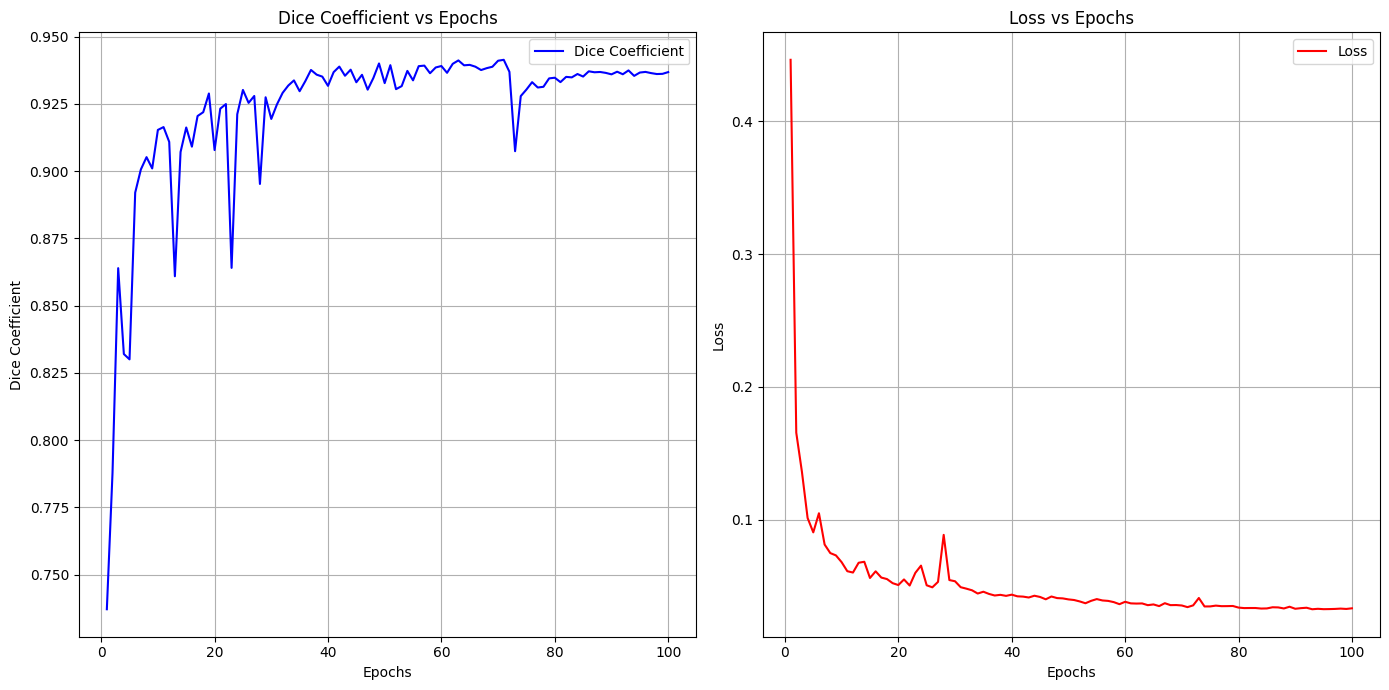

In [20]:
epochs = list(range(1, len(model_results["dice_liver"]) + 1))
plt.figure(figsize=(14, 7))

# dice
plt.subplot(1, 2, 1)
plt.plot(epochs, model_results["dice_liver"], label='Dice Coefficient', color='blue')
plt.title('Dice Coefficient vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.grid()

#loss
plt.subplot(1, 2, 2)
plt.plot(epochs, model_results["loss"], label='Loss', color='red')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()